# Visualize different poses in scatter plot

In [1]:
import joblib
import numpy as np
import pandas as pd
import holoviews as hv
import panel as pn
from holoviews import streams
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from aging.organization.paths import ValidationPaths
from aging.size_norm.util import flatten
from aging.plotting import format_plots, figure
hv.extension('bokeh', logo=False)
pn.extension()

In [2]:
format_plots()

In [3]:
data = joblib.load('/n/groups/datta/win/longtogeny/size_norm/models/pre_final_model-2023-09-30_v00/age_classification/transformed_age_classification_poses.p.gz')
pre_xform_data = joblib.load(ValidationPaths().age_classifier)

In [4]:
frames = []
pre_xform_frames = []
ages = []
for (age, path), v in data.items():
    frames.append(v)
    pre_xform_frames.append(pre_xform_data[(age, path)])
    ages.extend([age] * len(v))
frames = np.vstack(frames)
pre_xform_frames = np.vstack(pre_xform_frames)

In [9]:
age_df = pd.DataFrame({'age': ages, 'index': np.arange(len(ages))})
data_sample = age_df.groupby('age').sample(n=400, random_state=0).sort_index()
pca = PCA(n_components=10)
pcs = pca.fit_transform(flatten(frames[data_sample['index'].values]))
data_sample[['pc{}'.format(i) for i in range(pcs.shape[1])]] = pcs
data_sample = data_sample.query('pc0 > -500').copy()

In [10]:
age_df[['pc{}'.format(i) for i in range(pcs.shape[1])]] = pca.transform(flatten(frames))

In [6]:
data_sample['age'].unique()

array([  3,   4,   5,   7,   8,   9,  12,  16,  20,  24,  28,  32,  35,
        36,  40,  44,  48,  52,  56,  60,  64,  68,  72,  78,  80,  84,
        90, 103])

In [7]:
bounds = data_sample.min(), data_sample.max()

(-358.66534144956563, 543.4713991911374)

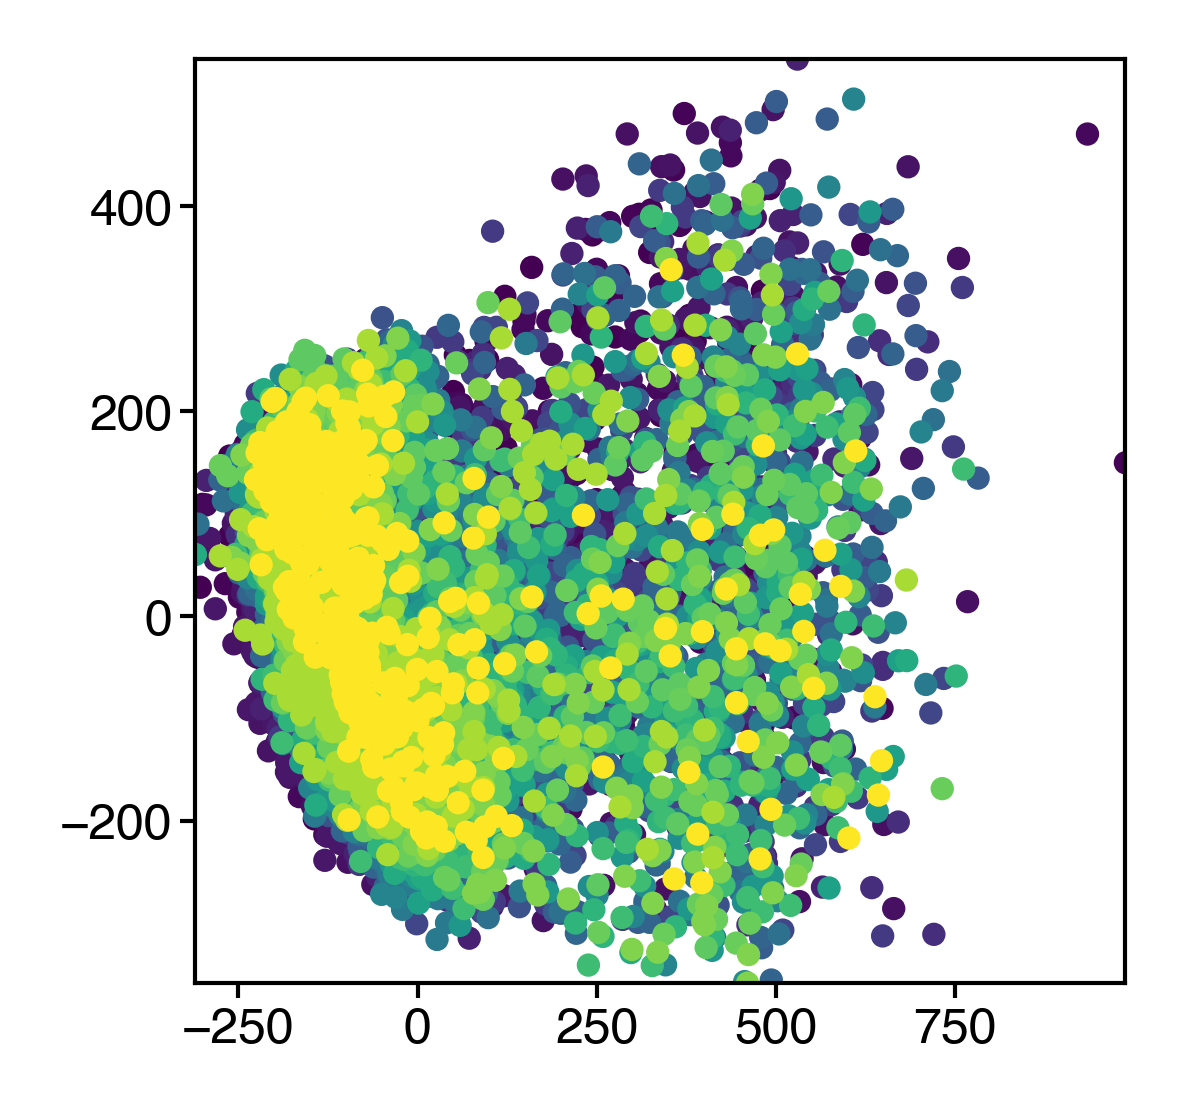

In [8]:
figure(2, 2)
tmp = data_sample
plt.scatter(tmp['pc0'], tmp['pc1'], c=tmp['age'], cmap='viridis', s=4, vmin=3, vmax=103)
plt.xlim(bounds[0]['pc0'], bounds[1]['pc0'])
plt.ylim(bounds[0]['pc1'], bounds[1]['pc1'])

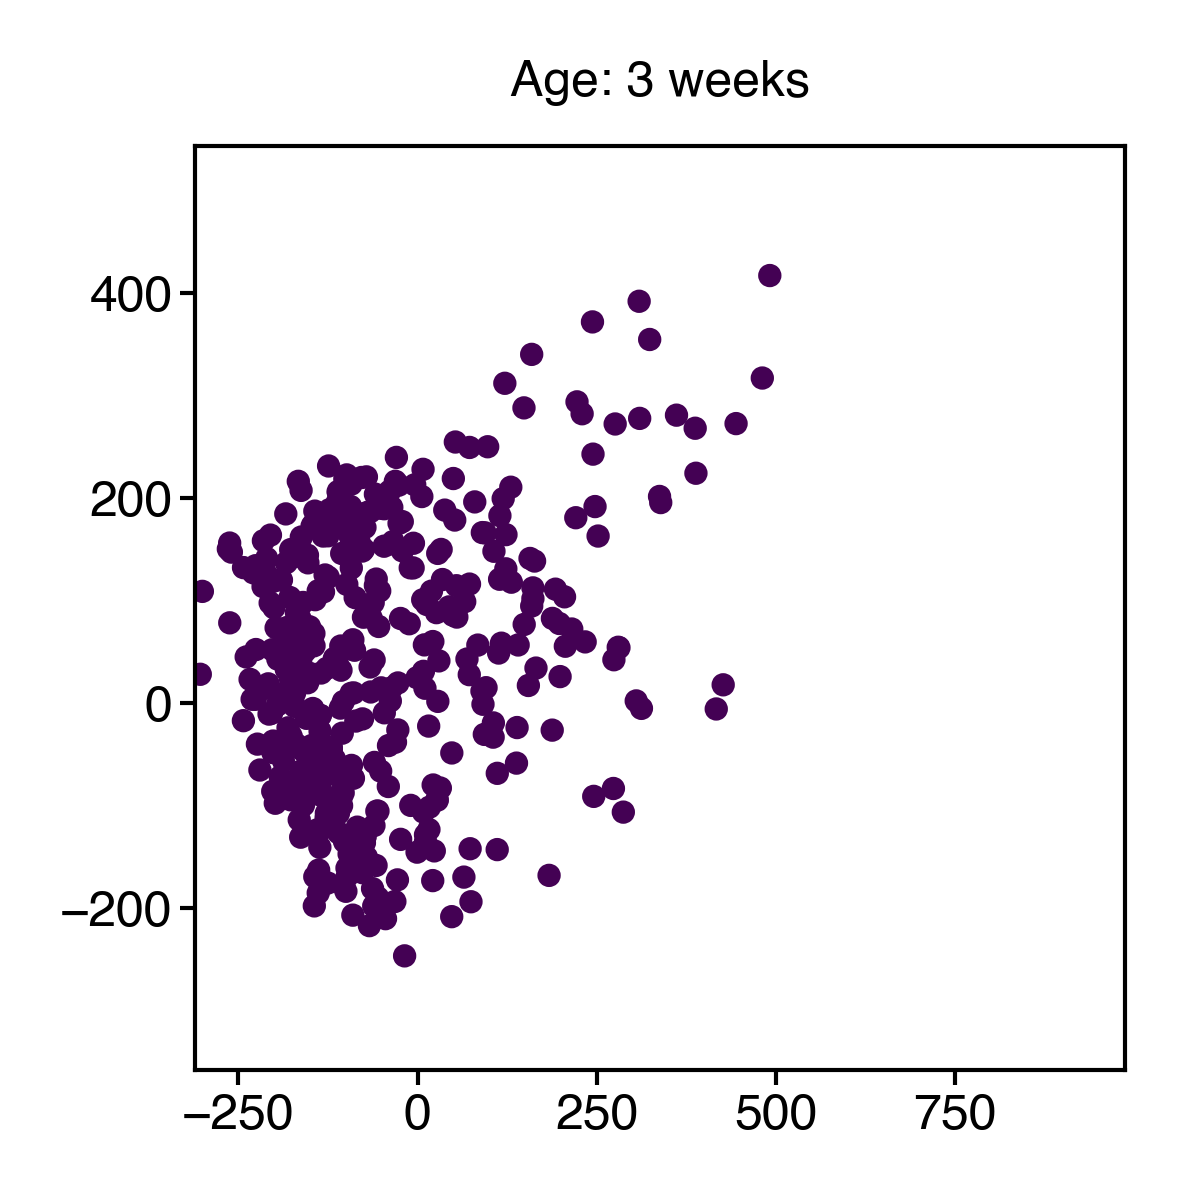

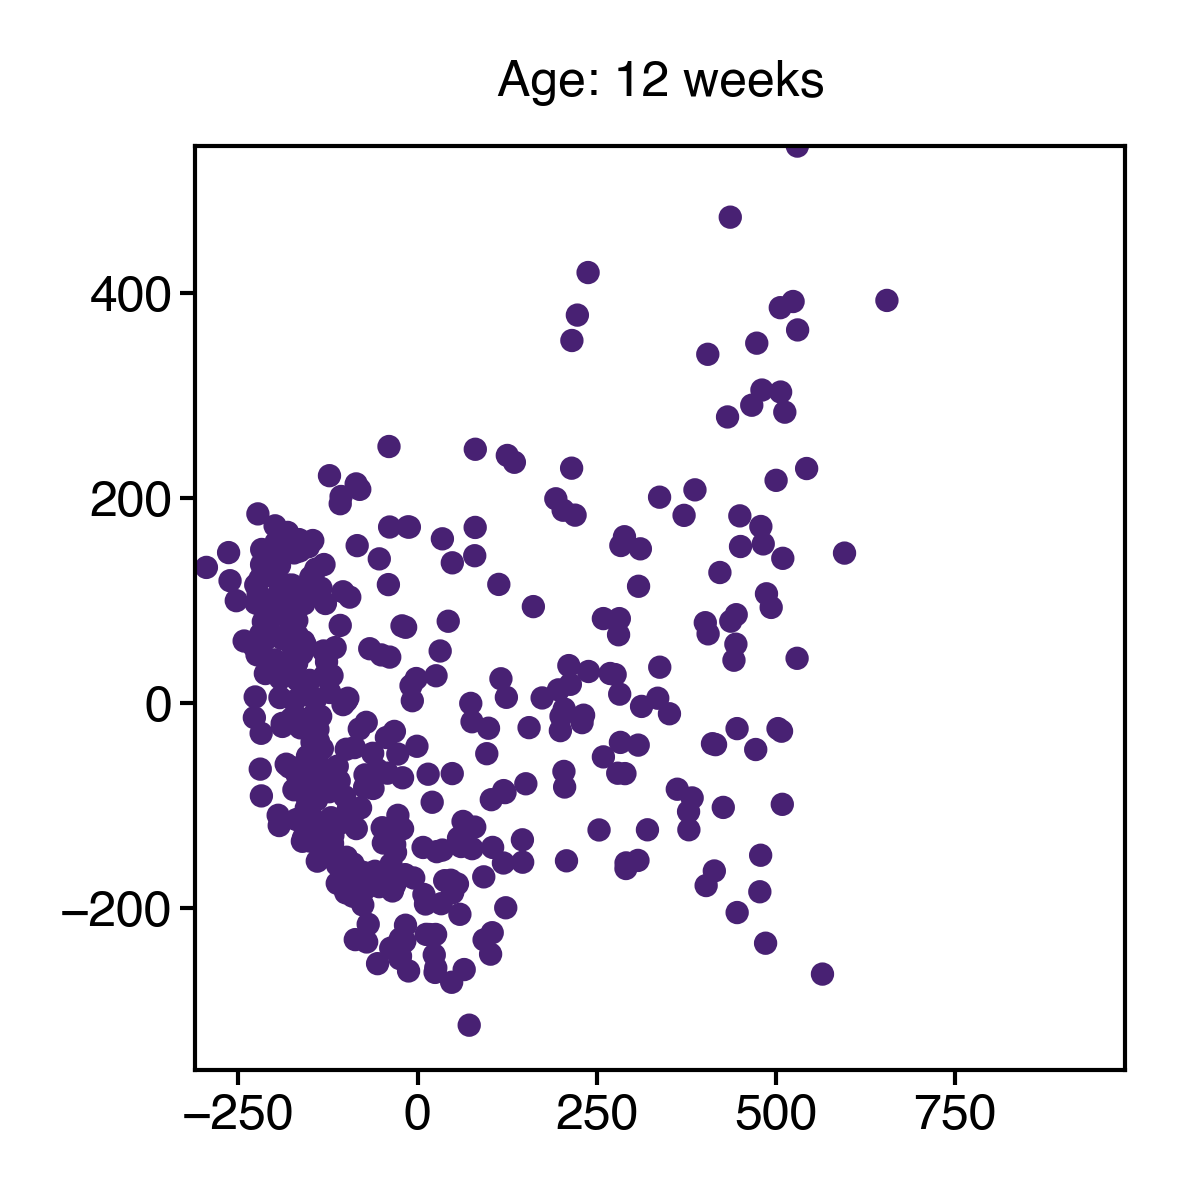

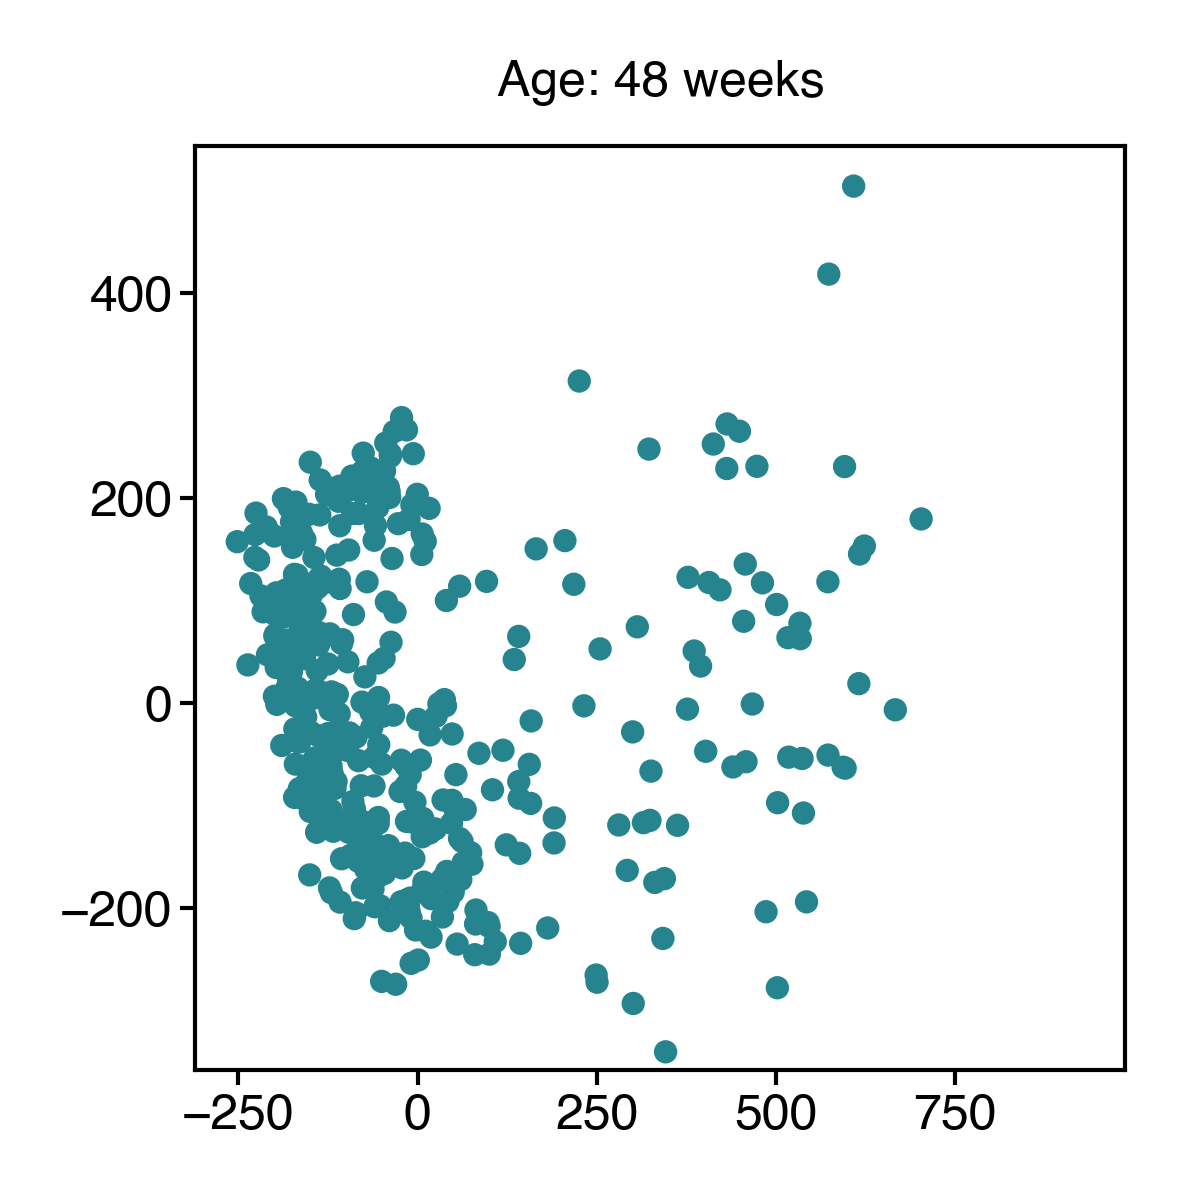

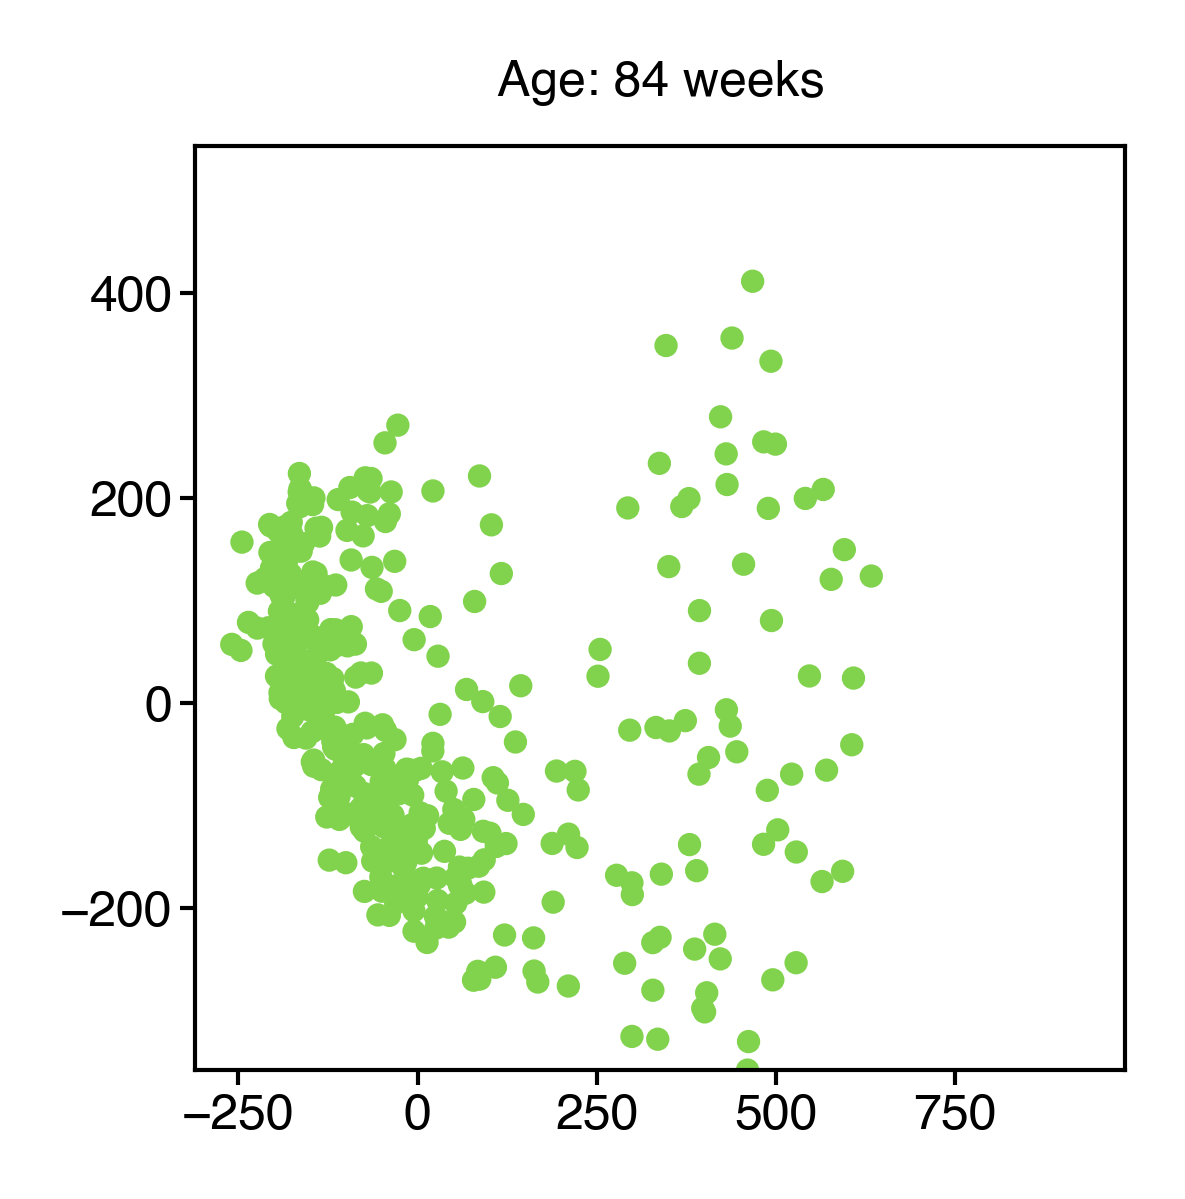

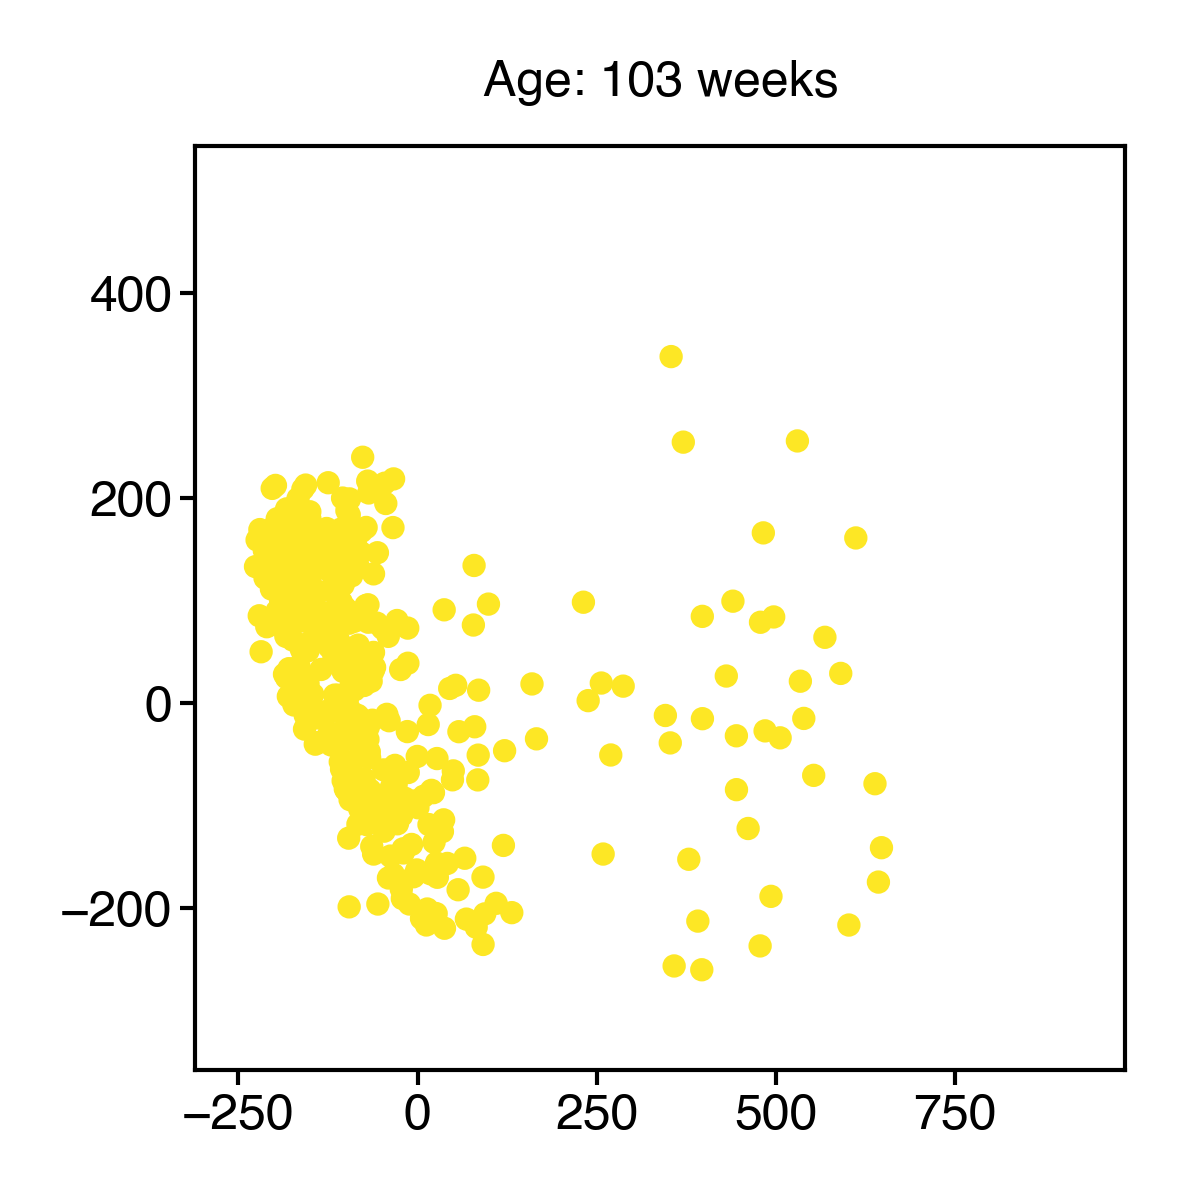

In [9]:
plot_ages = [3, 12, 48, 84, 103]
for _age in plot_ages:
    figure(2, 2)
    tmp = data_sample.query('age == @_age')
    plt.scatter(tmp['pc0'], tmp['pc1'], c=tmp['age'], cmap='viridis', s=4, vmin=3, vmax=103)
    plt.xlim(bounds[0]['pc0'], bounds[1]['pc0'])
    plt.ylim(bounds[0]['pc1'], bounds[1]['pc1'])
    plt.title('Age: {} weeks'.format(_age))

In [10]:
select = pn.widgets.Select(options=list(data_sample["age"].unique()))

min_pcs = data_sample[["pc0", "pc1"]].min()
max_pcs = data_sample[["pc0", "pc1"]].max()


def plot_scatter(age):
    tmp = data_sample.query("age == @age")
    return (
        hv.Points(tmp, kdims=["pc0", "pc1"], vdims="age")
        .redim(
            pc0=hv.Dimension("pc0", range=(min_pcs["pc0"], max_pcs["pc0"])),
            pc1=hv.Dimension("pc1", range=(min_pcs["pc1"], max_pcs["pc1"])),
        )
        .opts(
            color="age",
            cmap="viridis",
            clim=(3, 103),
            line_color="black",
            line_width=0.15,
            size=7,
            title="Age: {} weeks".format(age),
        )
    )


scatter = hv.DynamicMap(plot_scatter, streams=dict(age=select.param.value))

tap = streams.Tap(source=scatter, x=0, y=0)


def plot_img(x, y, age):
    # find closest point
    tmp = data_sample.query("age == @age")
    idx = np.argmin(
        np.linalg.norm(tmp[["pc0", "pc1"]].values - np.array([x, y]), axis=1)
    )
    # get frame from original data
    row = tmp.iloc[idx]
    frame = frames[int(row["index"])]
    # plot
    return (
        hv.Image(frame)
        .relabel("Age: {} weeks".format(age))
        .opts(cmap="cubehelix", clim=(0, 100))
    )


points = []

red_pt = hv.opts.Points(size=14, color="red", alpha=0.7)
blue_pt = hv.opts.Points(size=14, color="cyan", alpha=0.7)


def add_points(x, y):
    if len(points) < 7 and (x != 0 or y != 0):
        points.append((x, y))
    # find closest point
    try:
        idx = np.argmin(np.linalg.norm(np.array(points) - np.array([x, y]), axis=1))
        pts = points.copy()
        pts.pop(idx)
        return hv.Points(pts).opts(red_pt) * hv.Points([points[idx]]).opts(blue_pt)
    except ValueError:
        return hv.Points(points).opts(red_pt) * hv.Points([]).opts(blue_pt)


pointer = hv.DynamicMap(add_points, streams=[tap])

dm_streams = dict(x=tap.param.x, y=tap.param.y, age=select.param.value)
dmap = hv.DynamicMap(plot_img, streams=dm_streams)
pn.Row(select, (scatter * pointer + dmap))

Row
    [0] Select(options=[3, 4, 5, 7, 8, ...], value=3)
    [1] HoloViews(Layout)

In [12]:
min_pcs = data_sample[["pc0", "pc1"]].min()
max_pcs = data_sample[["pc0", "pc1"]].max()


tmp = data_sample
scatter = (
    hv.Points(tmp, kdims=["pc0", "pc1"], vdims="age")
    .redim(
        pc0=hv.Dimension("pc0", range=(min_pcs["pc0"], max_pcs["pc0"])),
        pc1=hv.Dimension("pc1", range=(min_pcs["pc1"], max_pcs["pc1"])),
    )
    .opts(
        color="age",
        cmap="viridis",
        clim=(3, 103),
        line_color="black",
        line_width=0.15,
        size=7,
    )
)


tap = streams.Tap(source=scatter, x=0, y=0)


def plot_img(x, y):
    idx = np.argmin(
        np.linalg.norm(tmp[["pc0", "pc1"]].values - np.array([x, y]), axis=1)
    )
    # get frame from original data
    row = tmp.iloc[idx]
    frame = frames[int(row["index"])]
    # plot
    return (
        hv.Image(frame)
        .relabel("Age: {} weeks".format(row.age))
        .opts(cmap="cubehelix", clim=(0, 100))
    )


points = []

red_pt = hv.opts.Points(size=14, color="red", alpha=0.7)


def add_points(x, y):
    return hv.Points([(x, y)]).opts(red_pt)


pointer = hv.DynamicMap(add_points, streams=[tap])

dm_streams = dict(x=tap.param.x, y=tap.param.y)
dmap = hv.DynamicMap(plot_img, streams=dm_streams)
scatter * pointer + dmap

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Overlay
         .Points.I  :Points   [pc0,pc1]   (age)
         .Points.II :Points   [x,y]
   .DynamicMap.II :DynamicMap   []
      :Image   [x,y]   (z)

In [37]:
scatter = (
    hv.Points(data_sample, kdims=["pc0", "pc1"], vdims="age")
    .opts(
        color="age",
        cmap="viridis",
        clim=(3, 103),
        line_color="black",
        line_width=0.15,
        size=7,
    )
)


tap = streams.Tap(source=scatter, x=0, y=0)

point_frames = {}
og_point_frames = {}

def get_similar_frames(x, y, n_neighbors=8):
    if x == 0 and y == 0:
        return hv.Image(np.zeros((80, 80))).opts(cmap="cubehelix", clim=(0, 100), width=600, height=100)
    frames_per_age = {}
    og_frames_per_age = {}
    for age, _df in age_df.groupby("age"):
        dist = np.linalg.norm(_df[["pc0", "pc1"]].values - np.array([x, y]), axis=1)
        keep = np.argsort(dist)[:n_neighbors]
        # get frame from original data
        keep_df = _df.iloc[keep]
        _frames = frames[keep_df["index"].astype(int)]
        _og_frames = pre_xform_frames[keep_df["index"].astype(int)]
        med_frame = np.median(_frames, axis=0)
        frames_per_age[age] = med_frame
        og_frames_per_age[age] = np.median(_og_frames, axis=0)
    point_frames[(x, y)] = frames_per_age
    og_point_frames[(x, y)] = og_frames_per_age
    return hv.Image(np.concatenate(list(og_frames_per_age.values()), axis=1)).opts(cmap="cubehelix", clim=(0, 100), width=600, height=100)


red_pt = hv.opts.Points(size=14, color="red", alpha=0.7)

def add_points(x, y):
    return hv.Points([(x, y)]).opts(red_pt)


pointer = hv.DynamicMap(add_points, streams=[tap])

dm_streams = dict(x=tap.param.x, y=tap.param.y)
dmap = hv.DynamicMap(get_similar_frames, streams=dm_streams)
scatter * pointer + dmap

BokehModel(combine_events=True, render_bundle={'docs_json': {'3bde0261-5622-4a56-9b5c-7e53a4bf0085': {'version…

In [38]:
keys = list(og_point_frames)

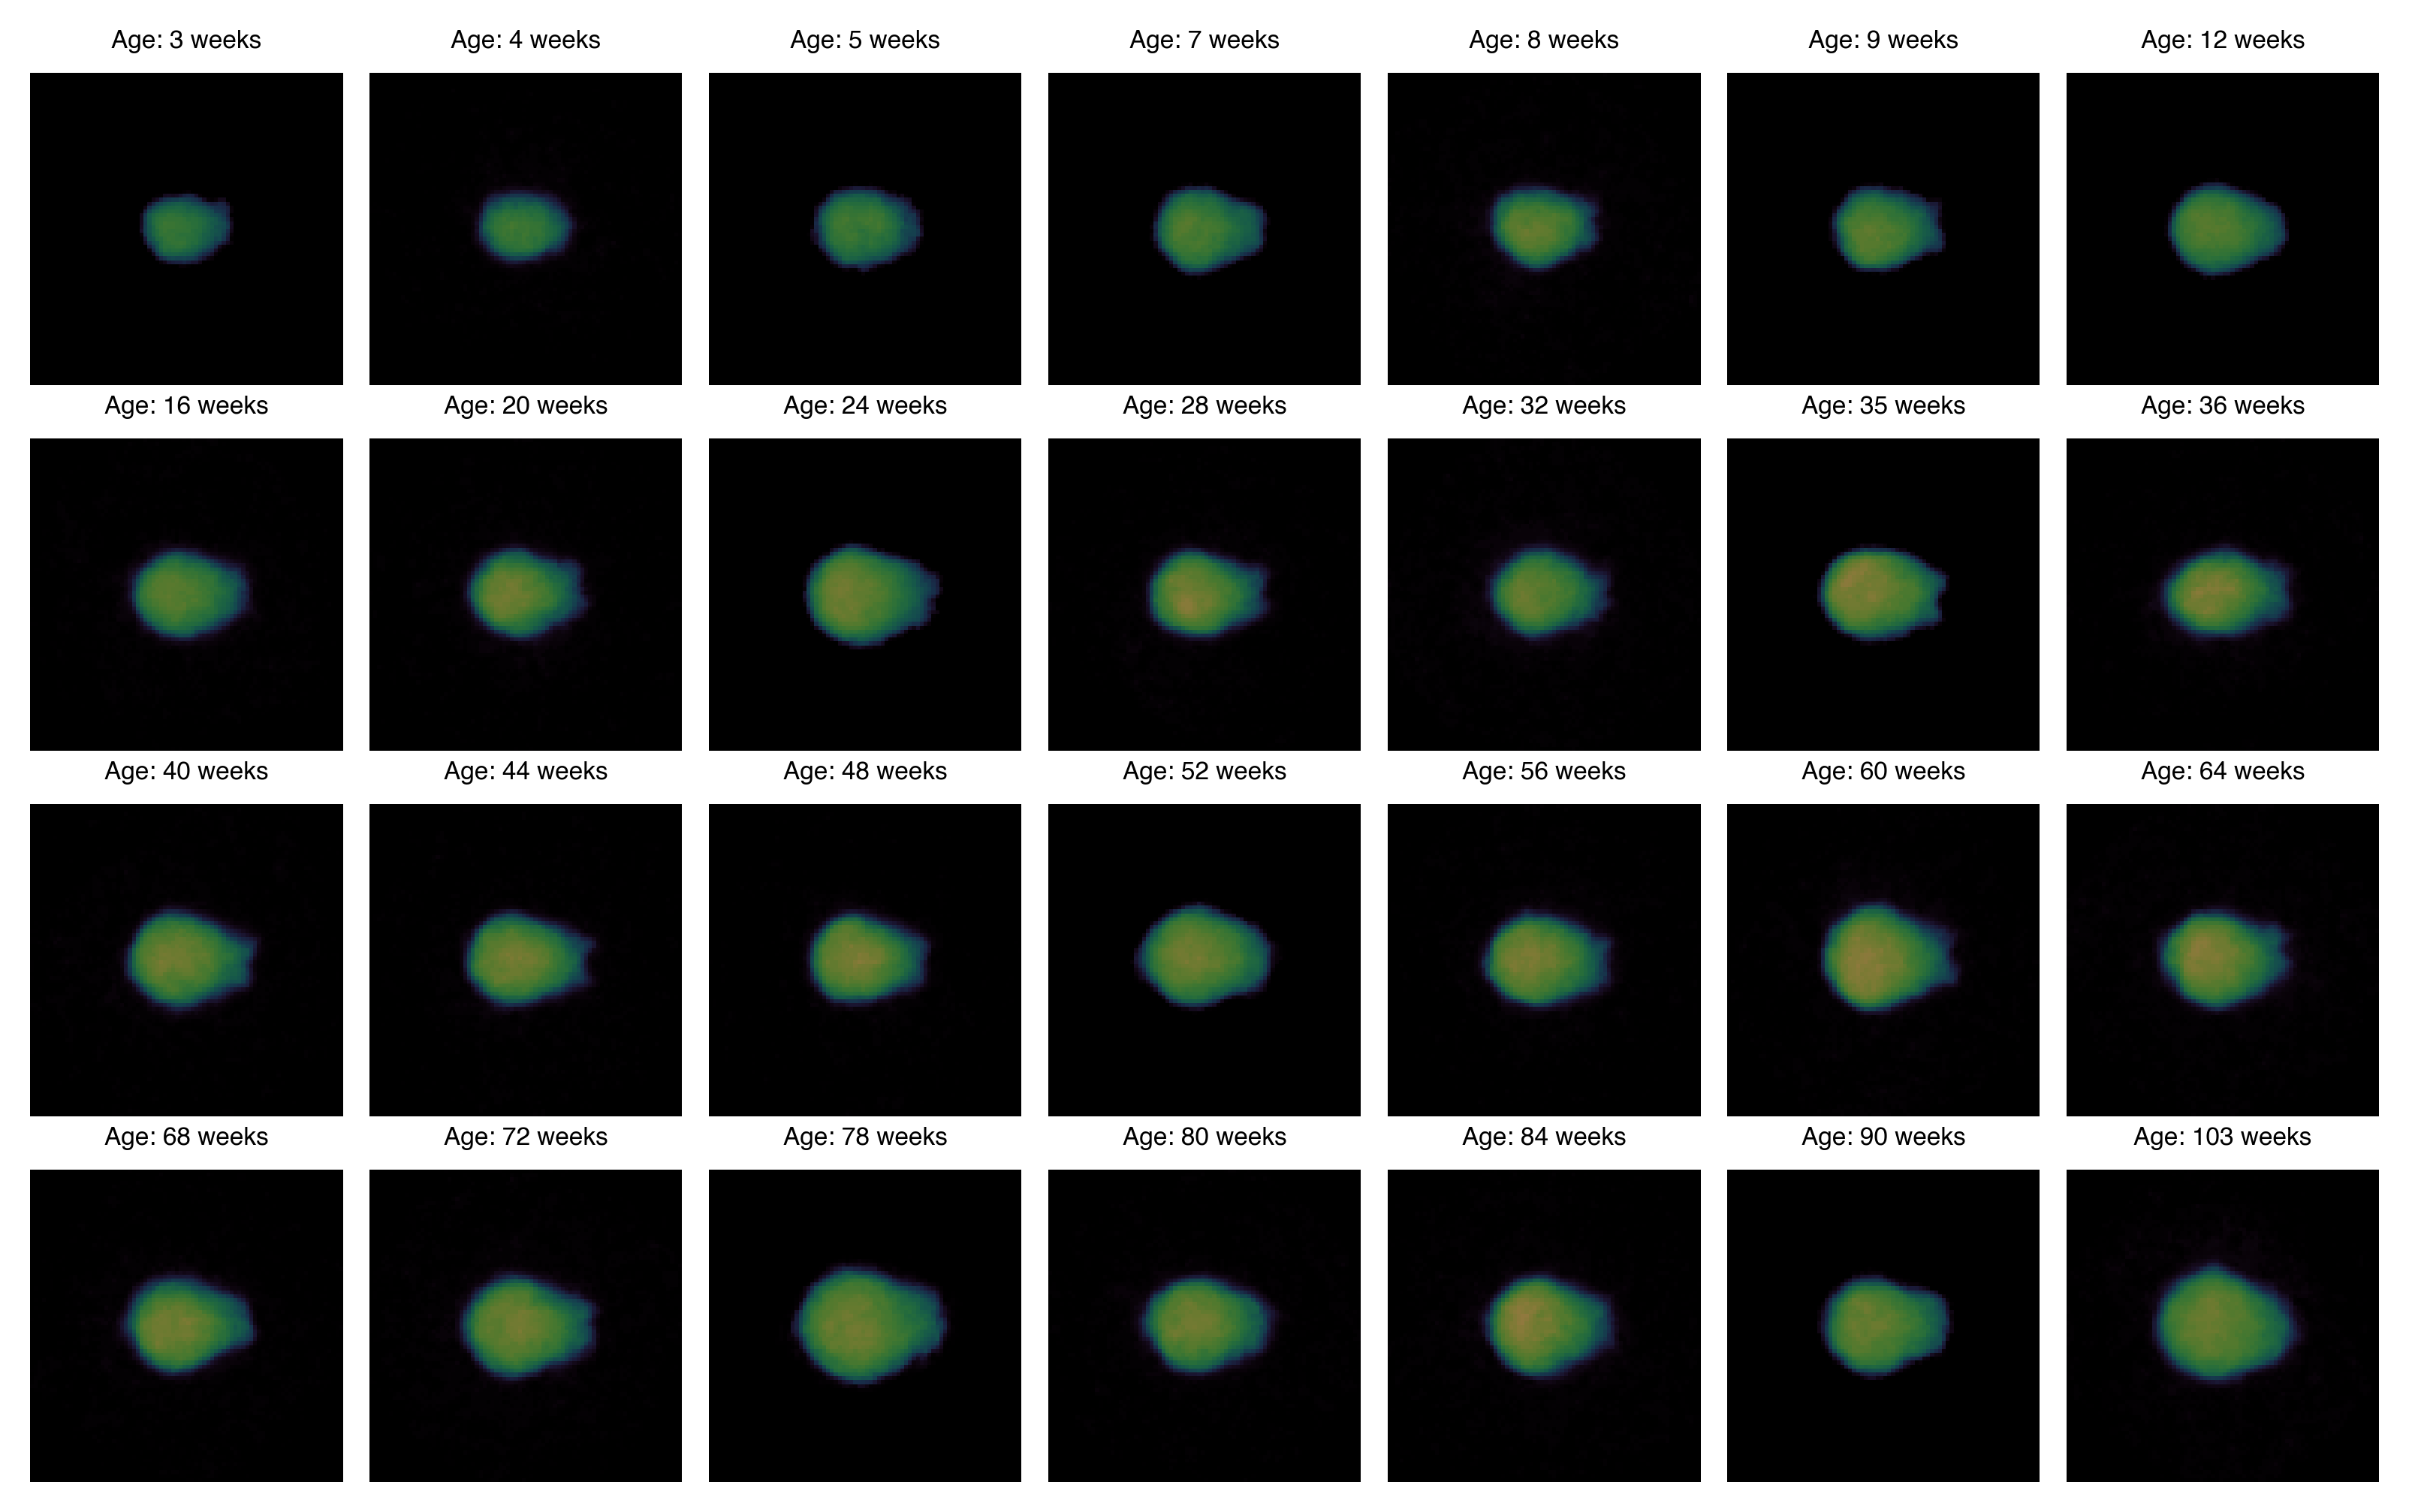

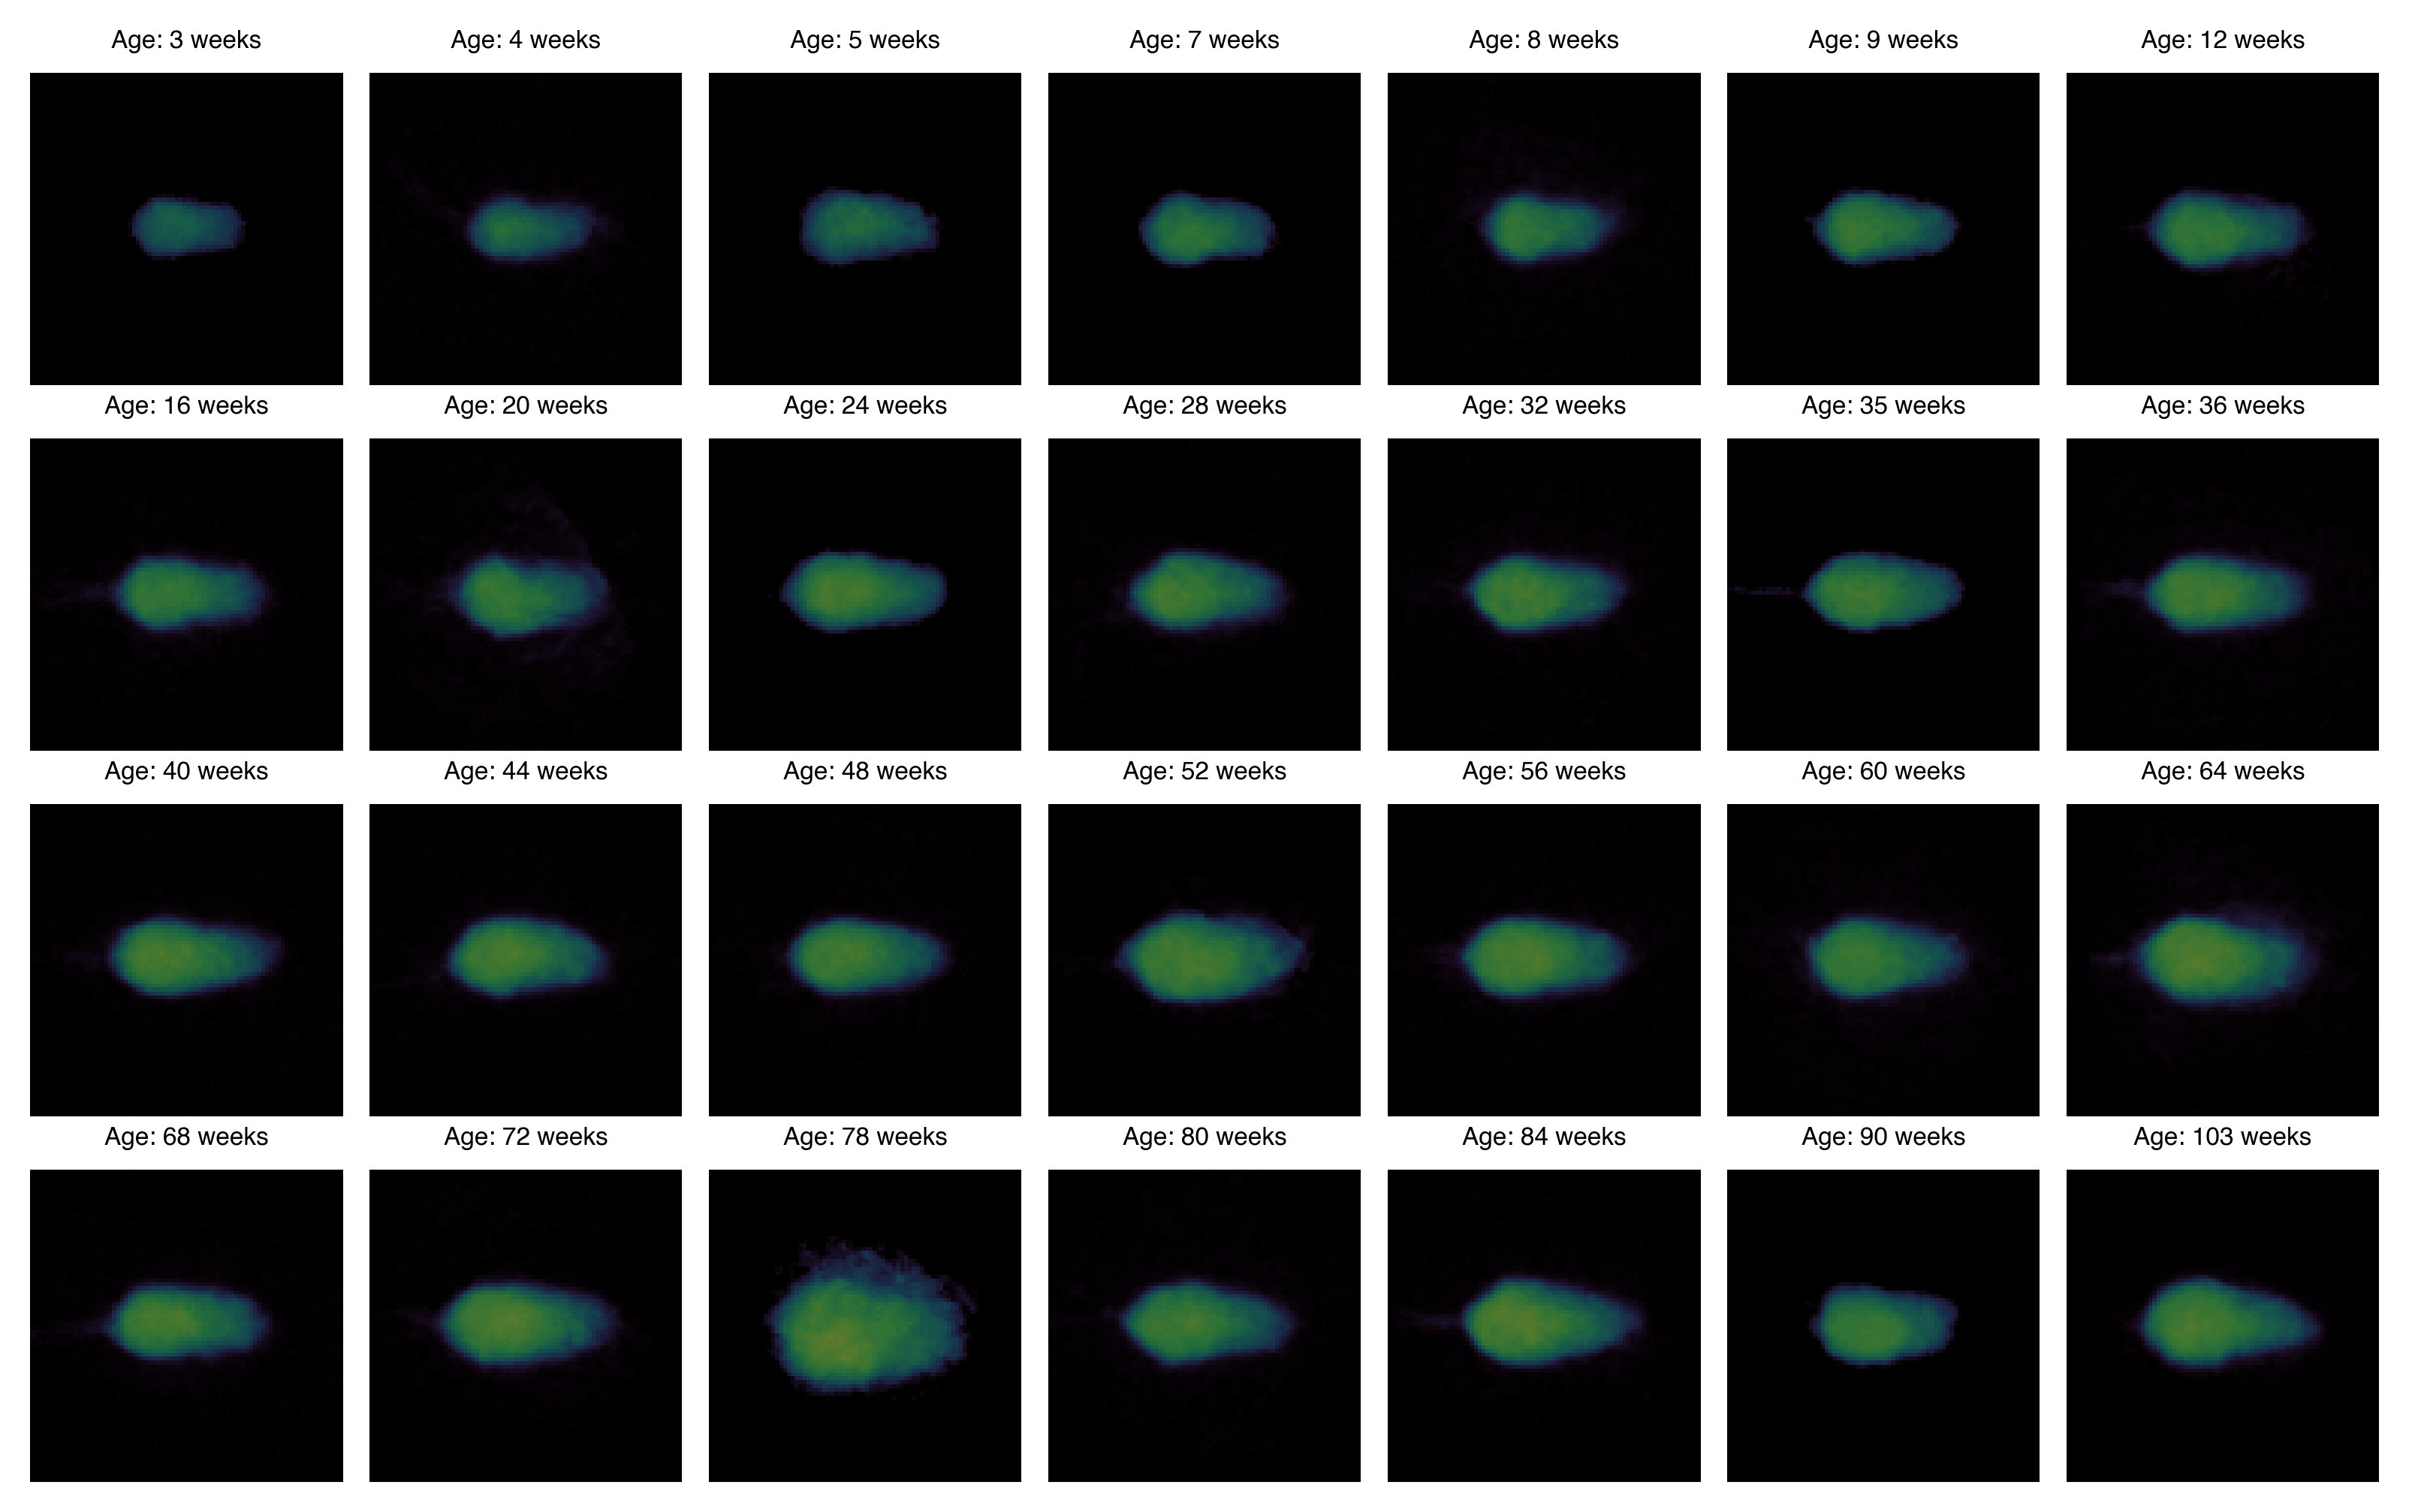

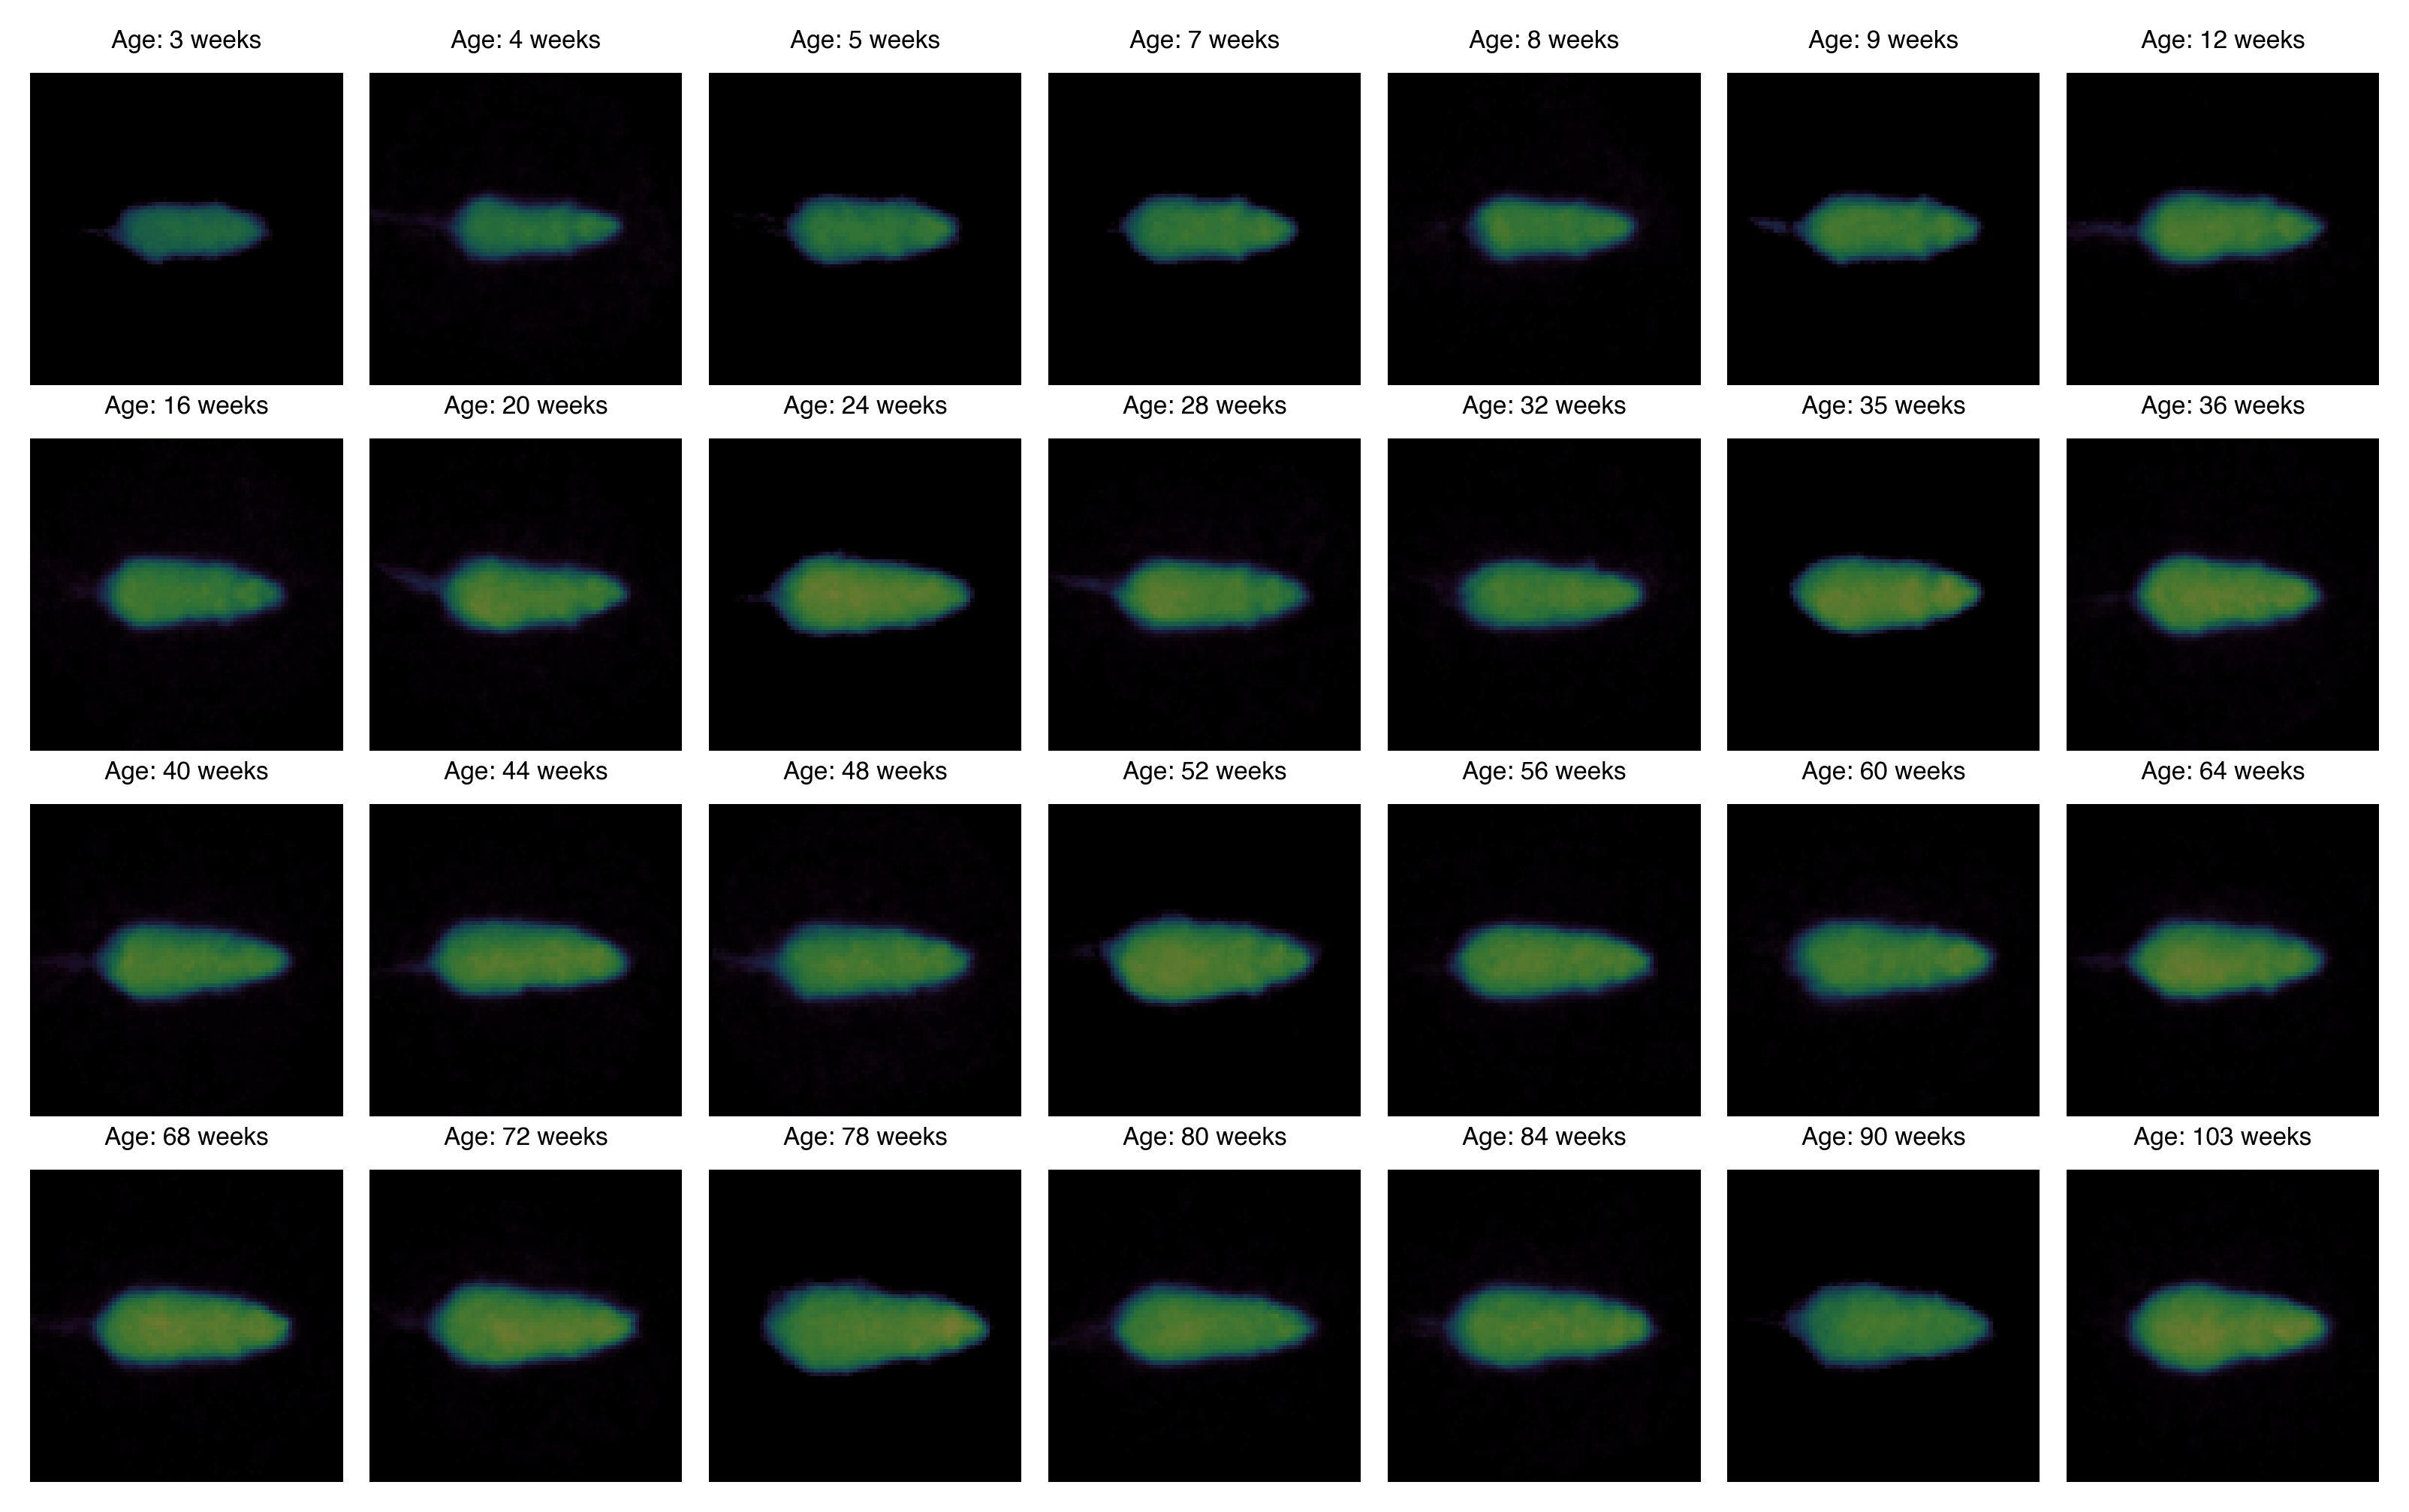

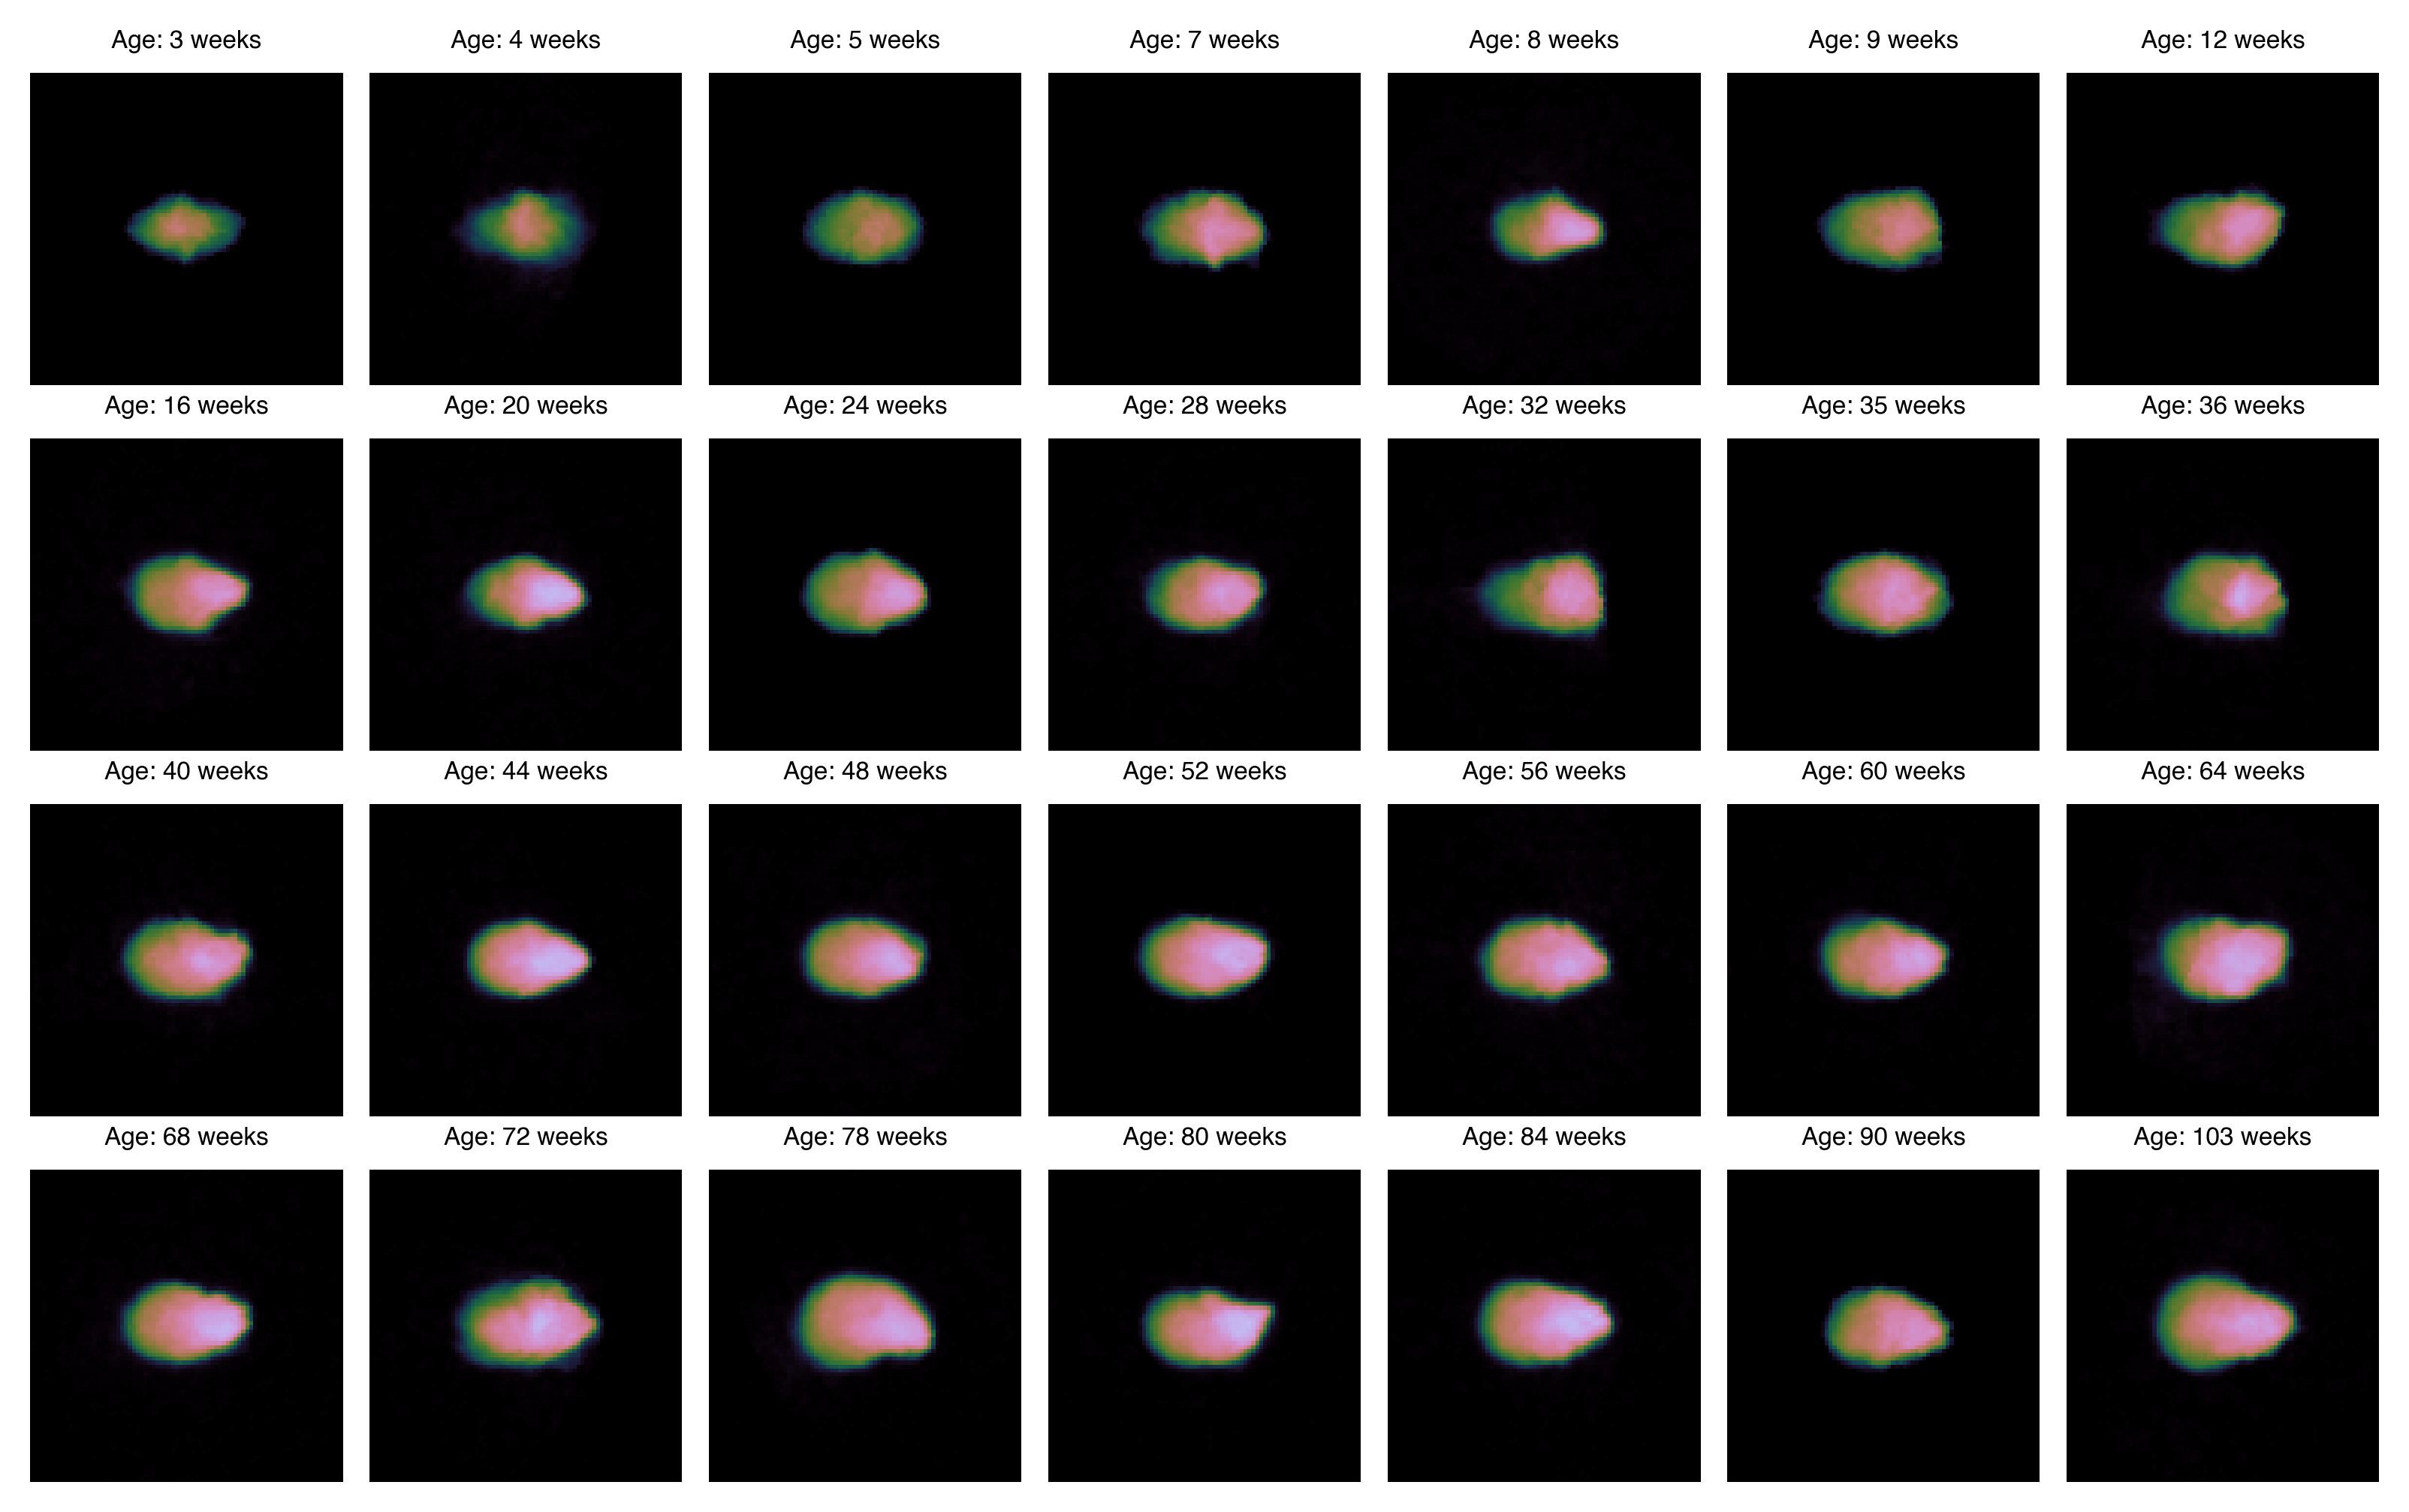

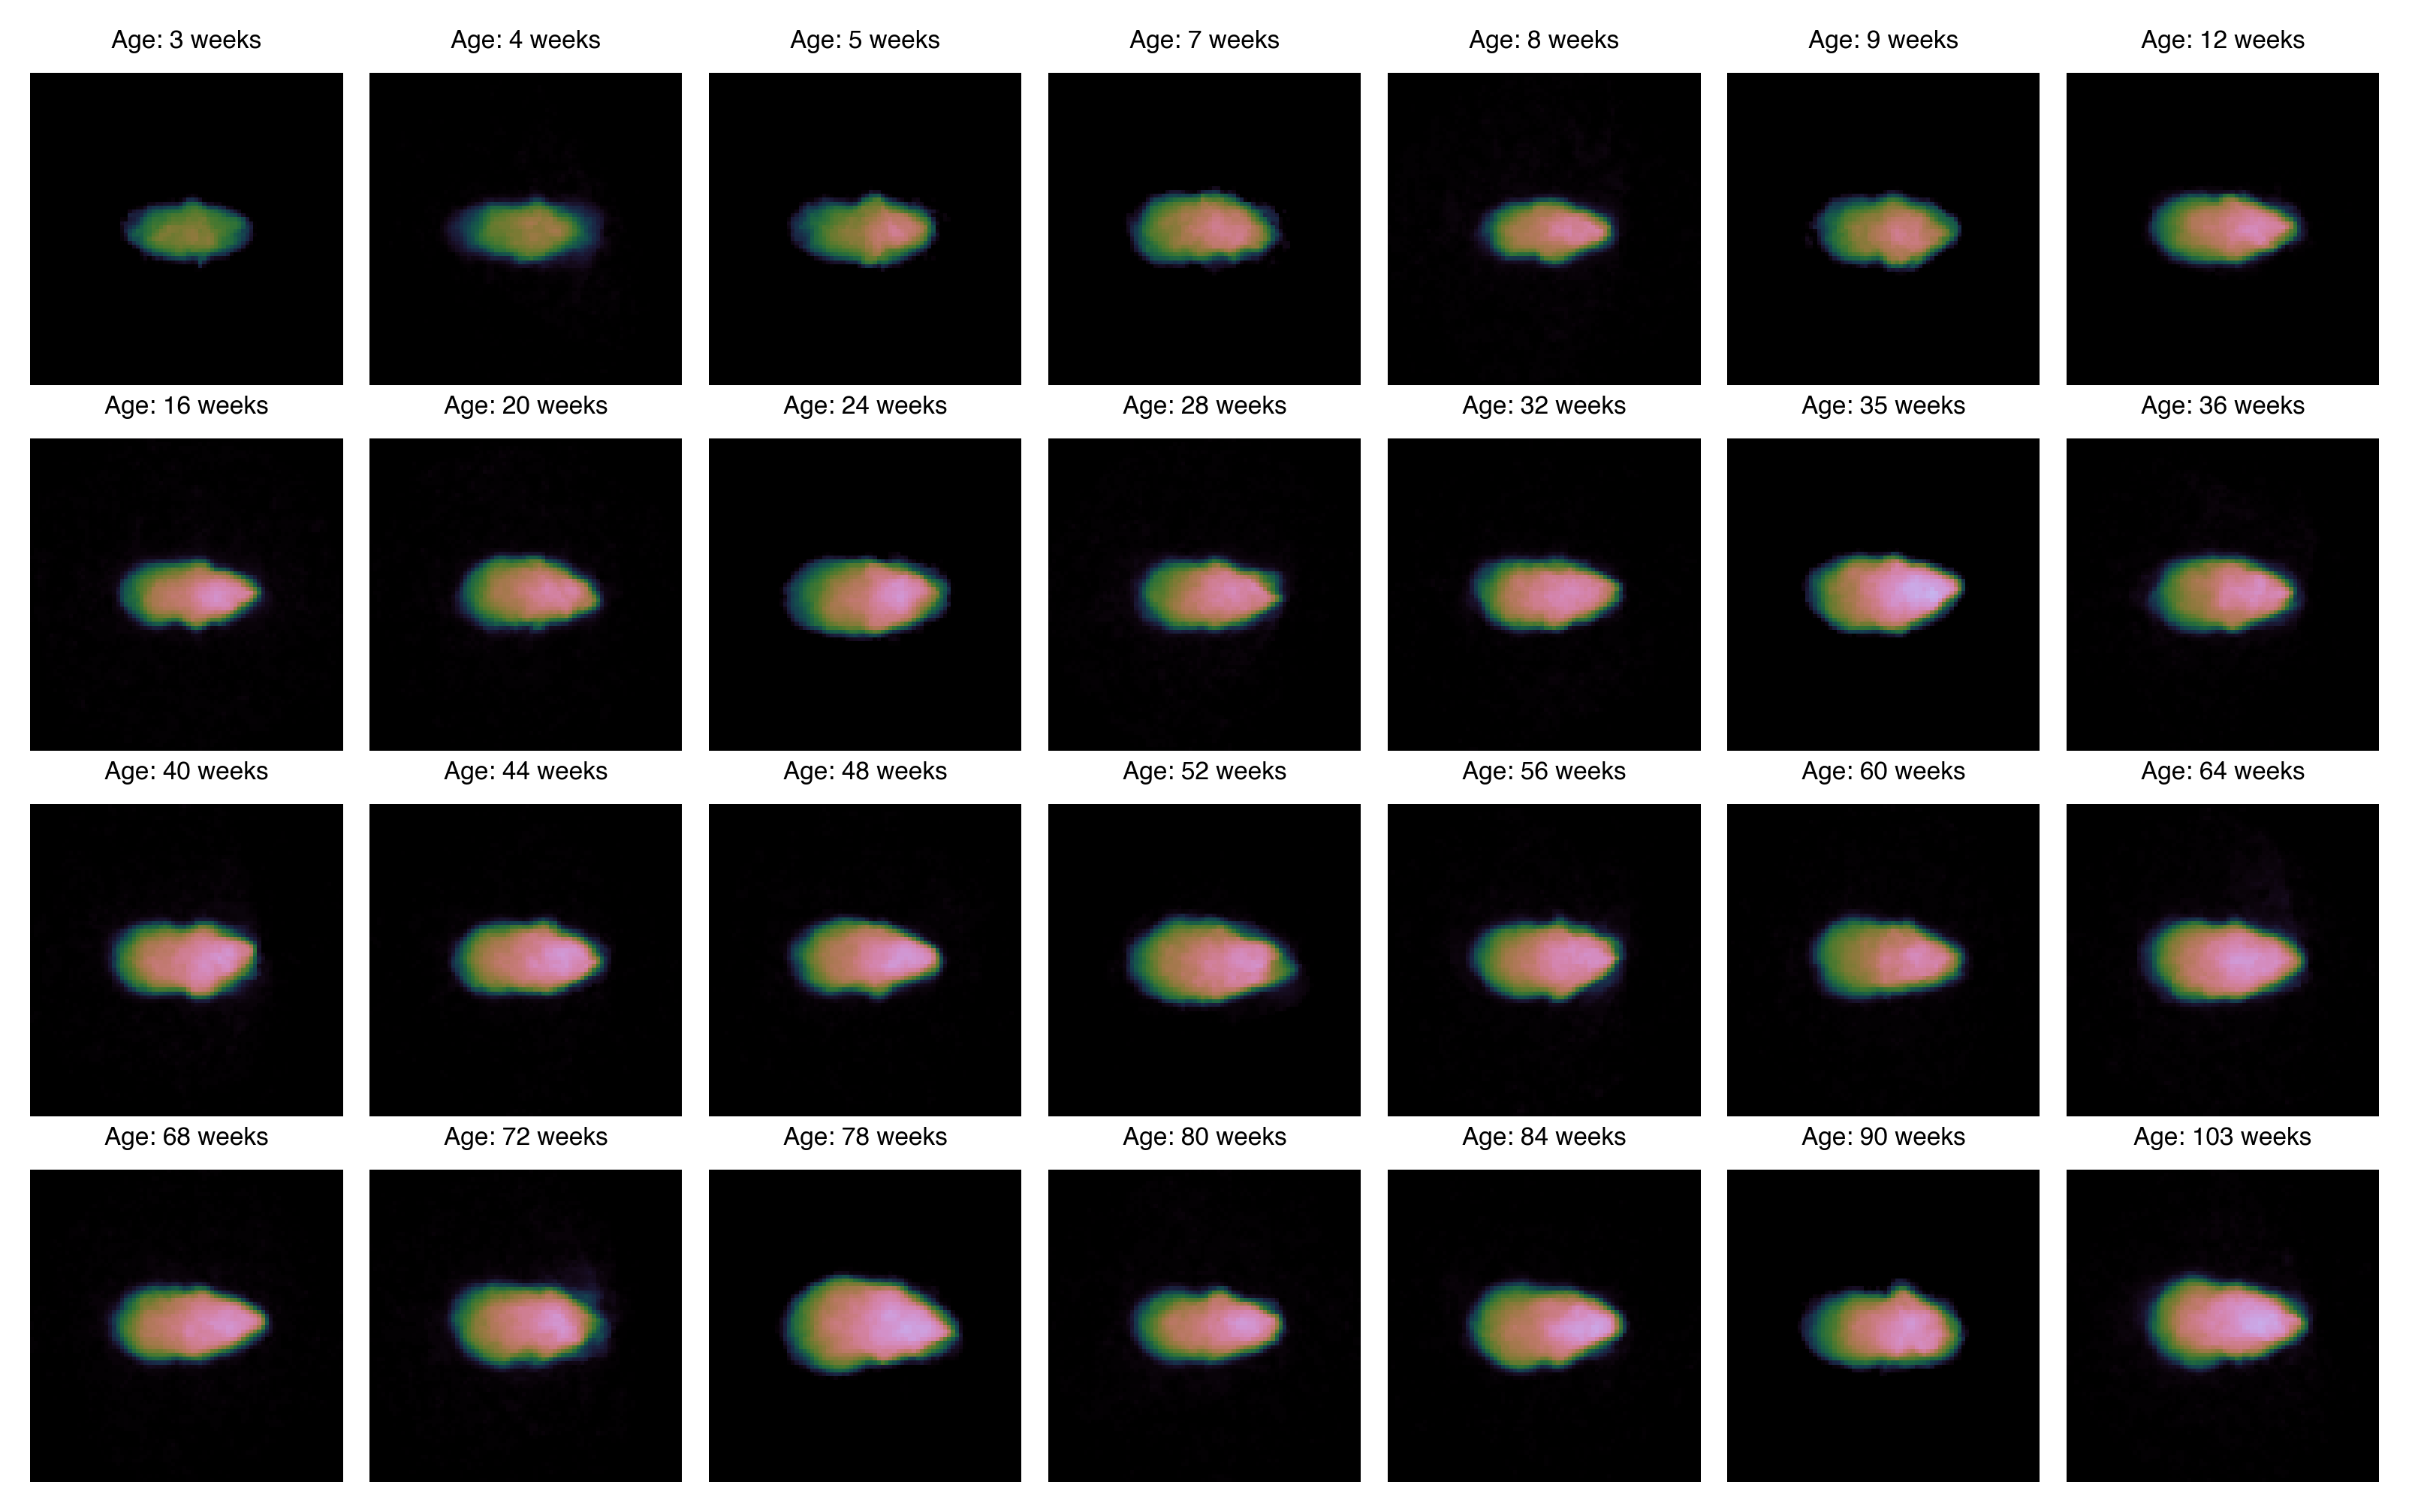

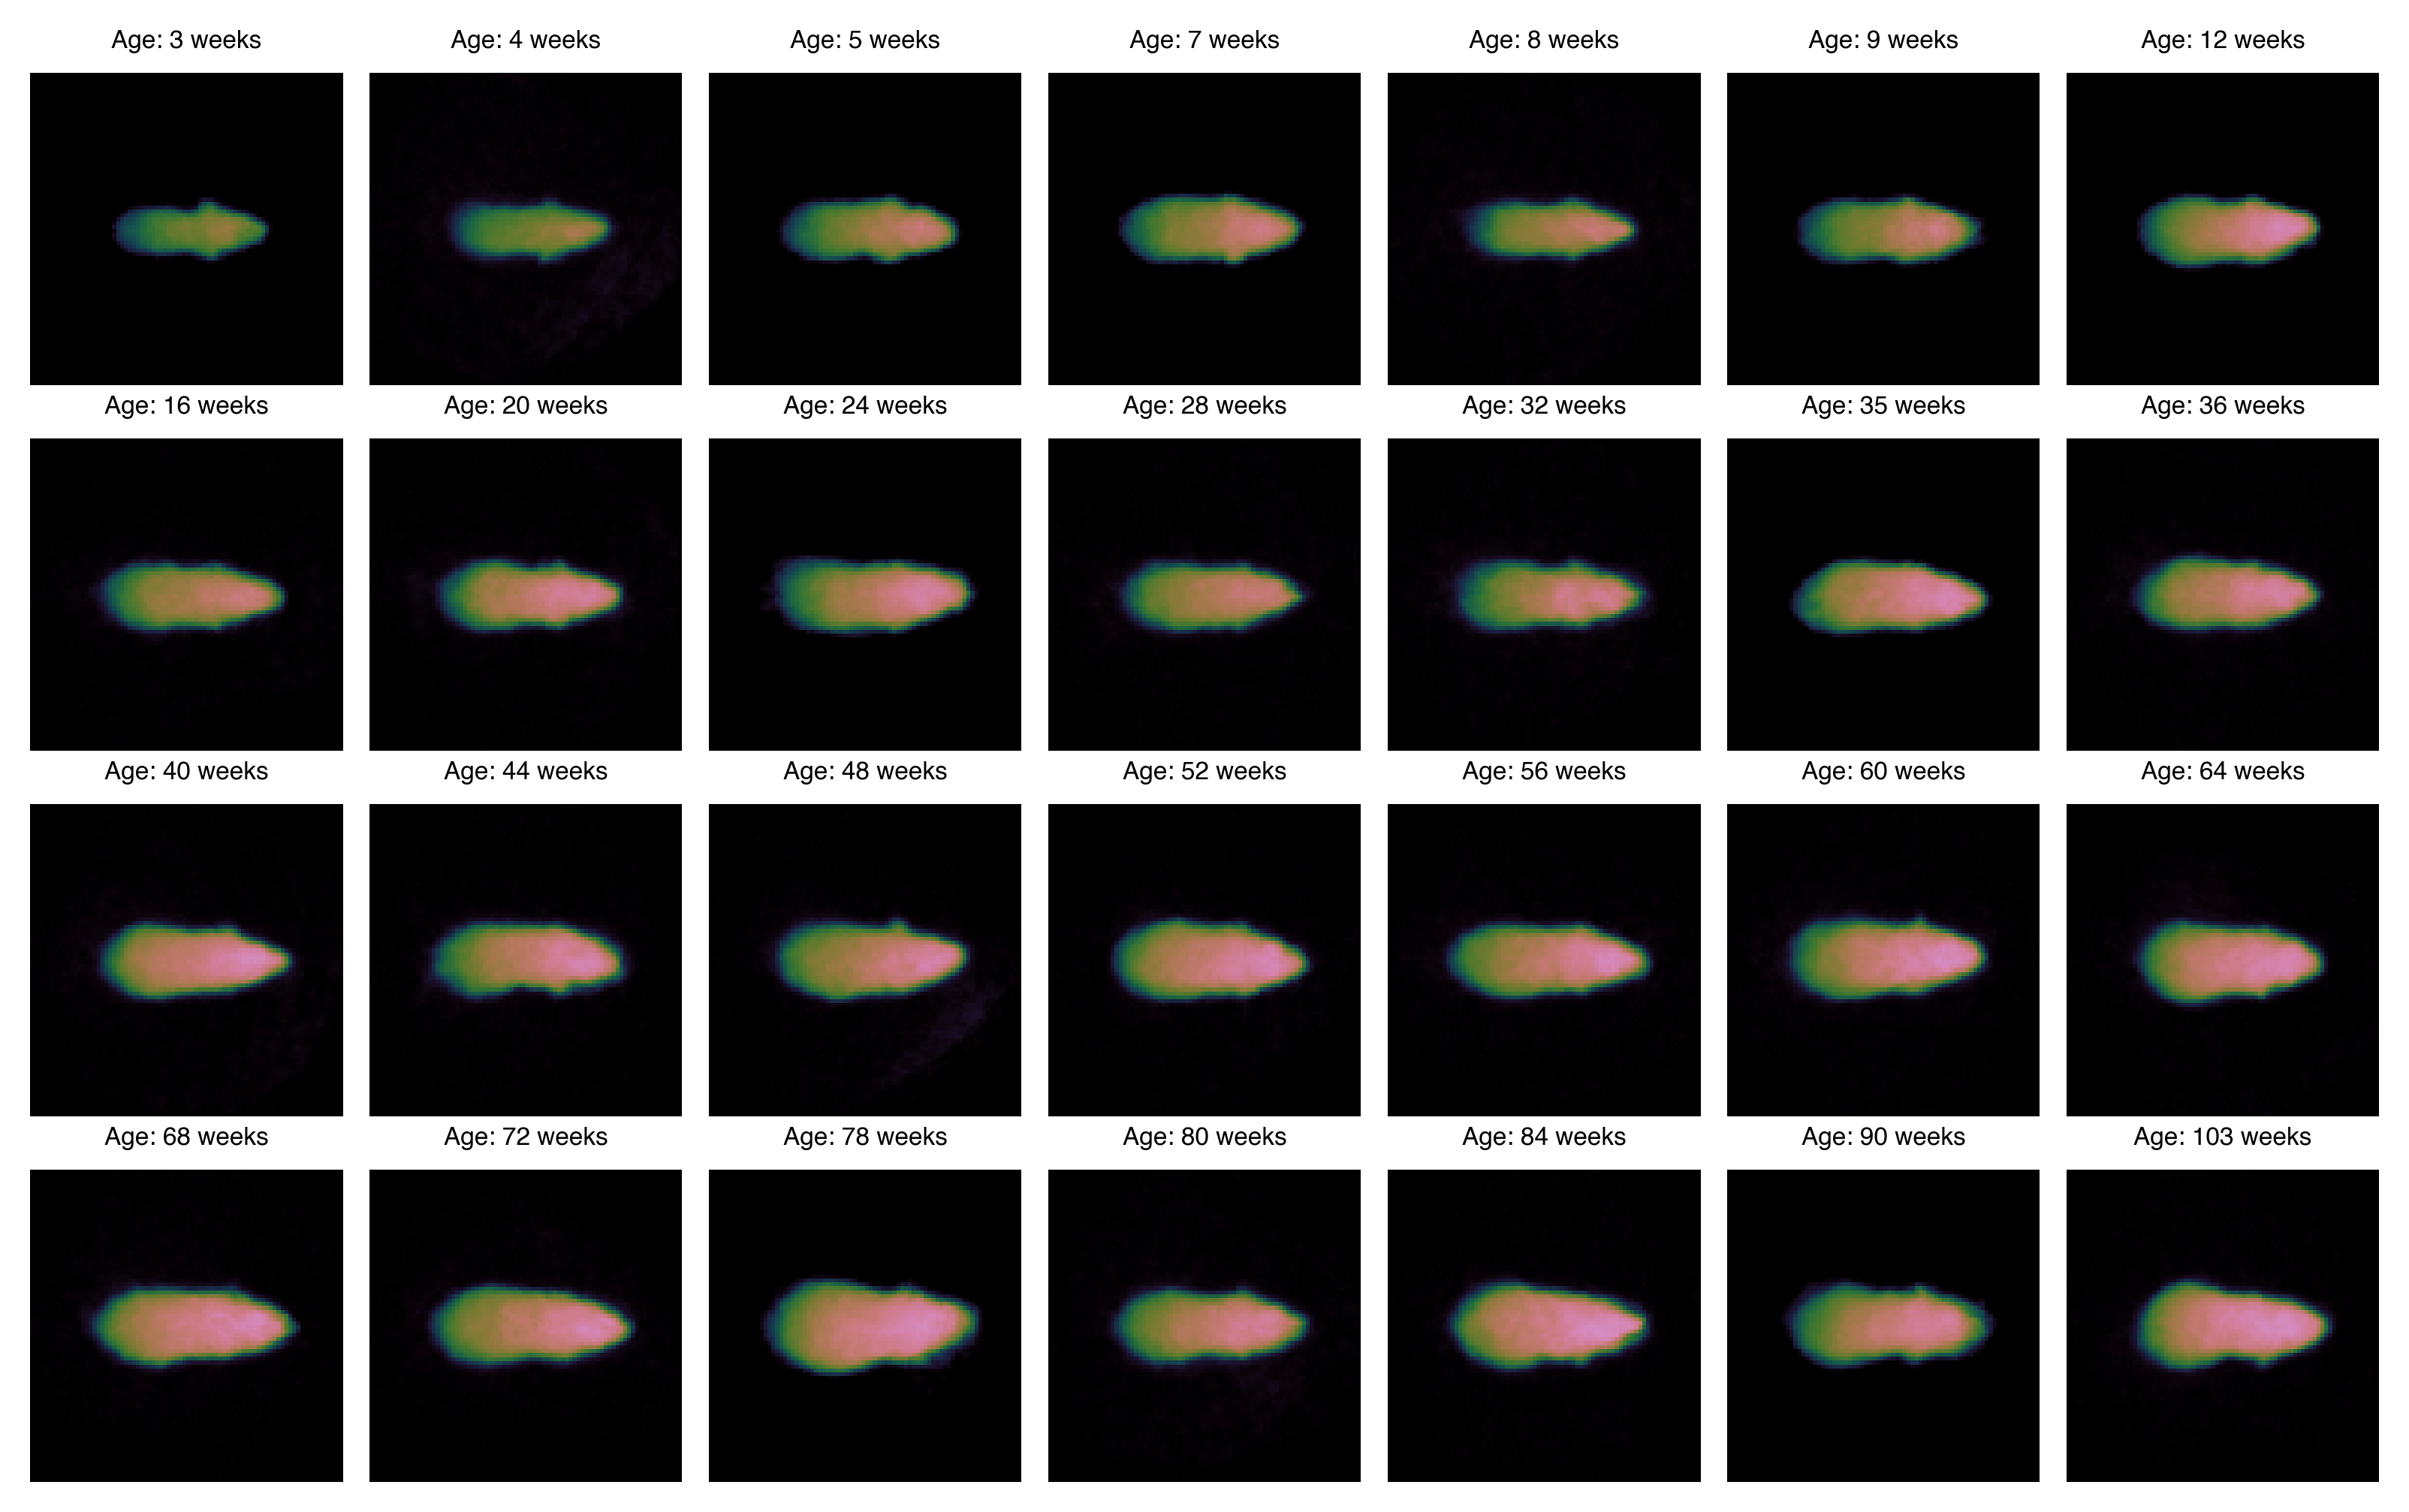

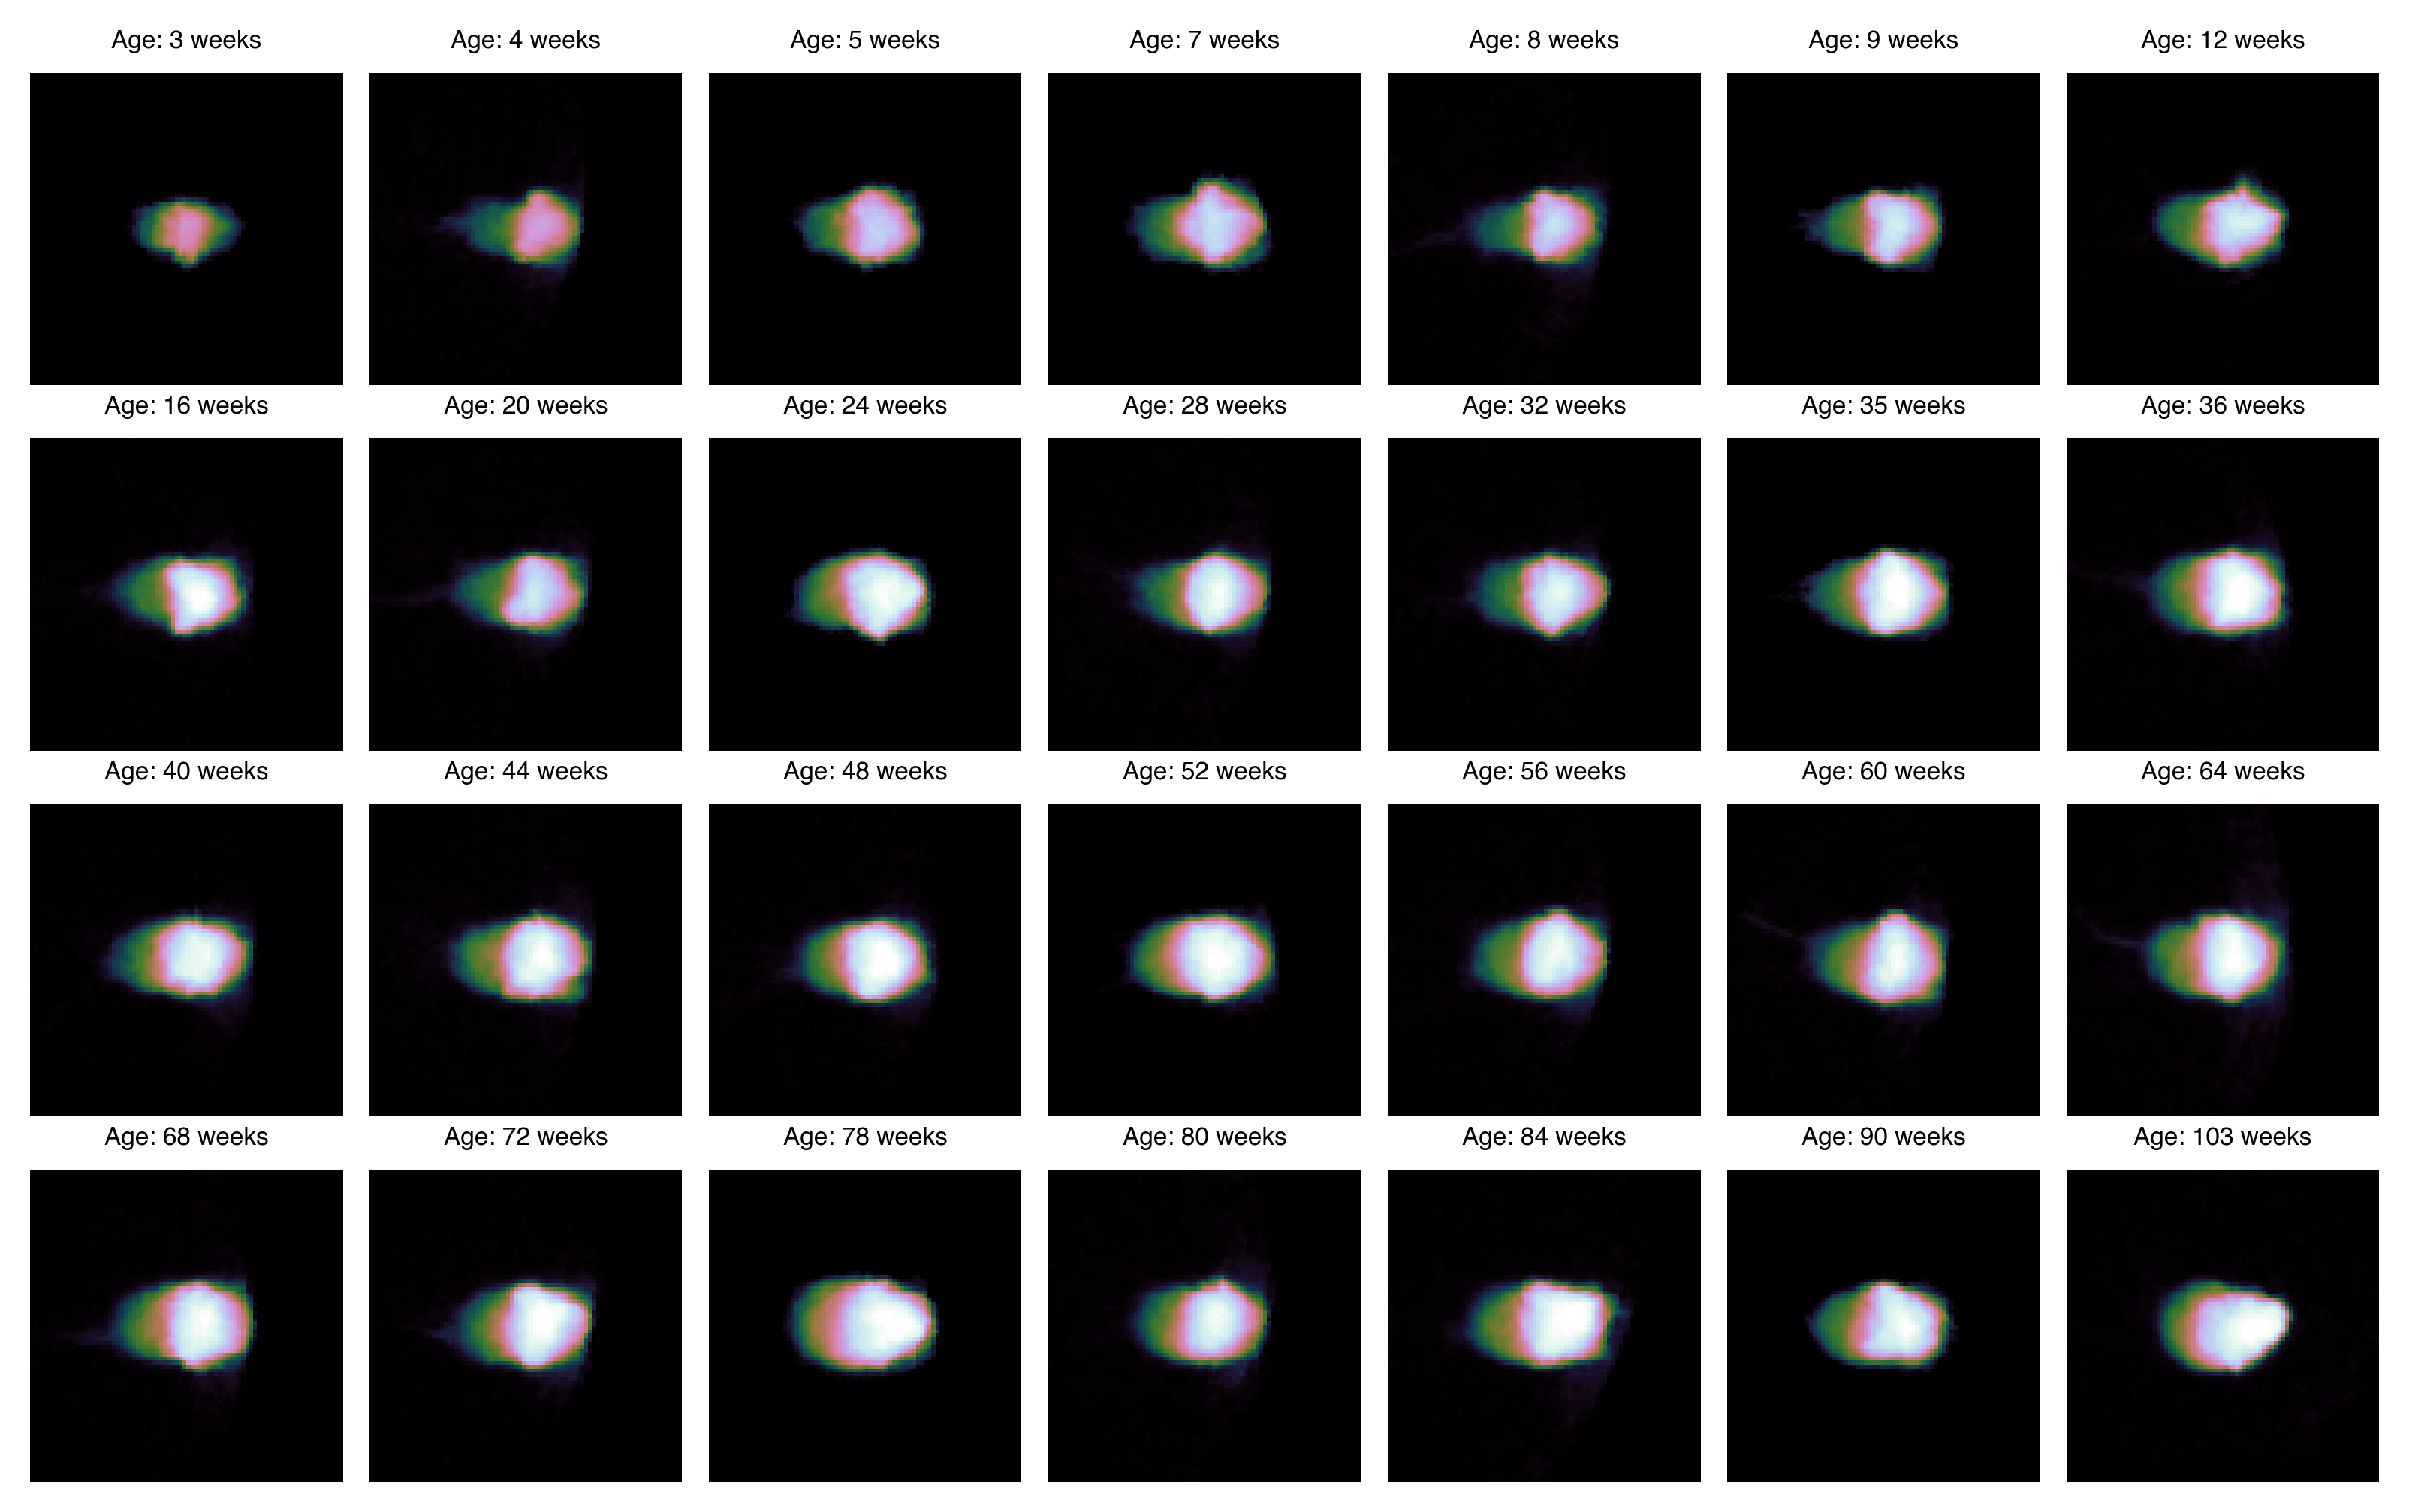

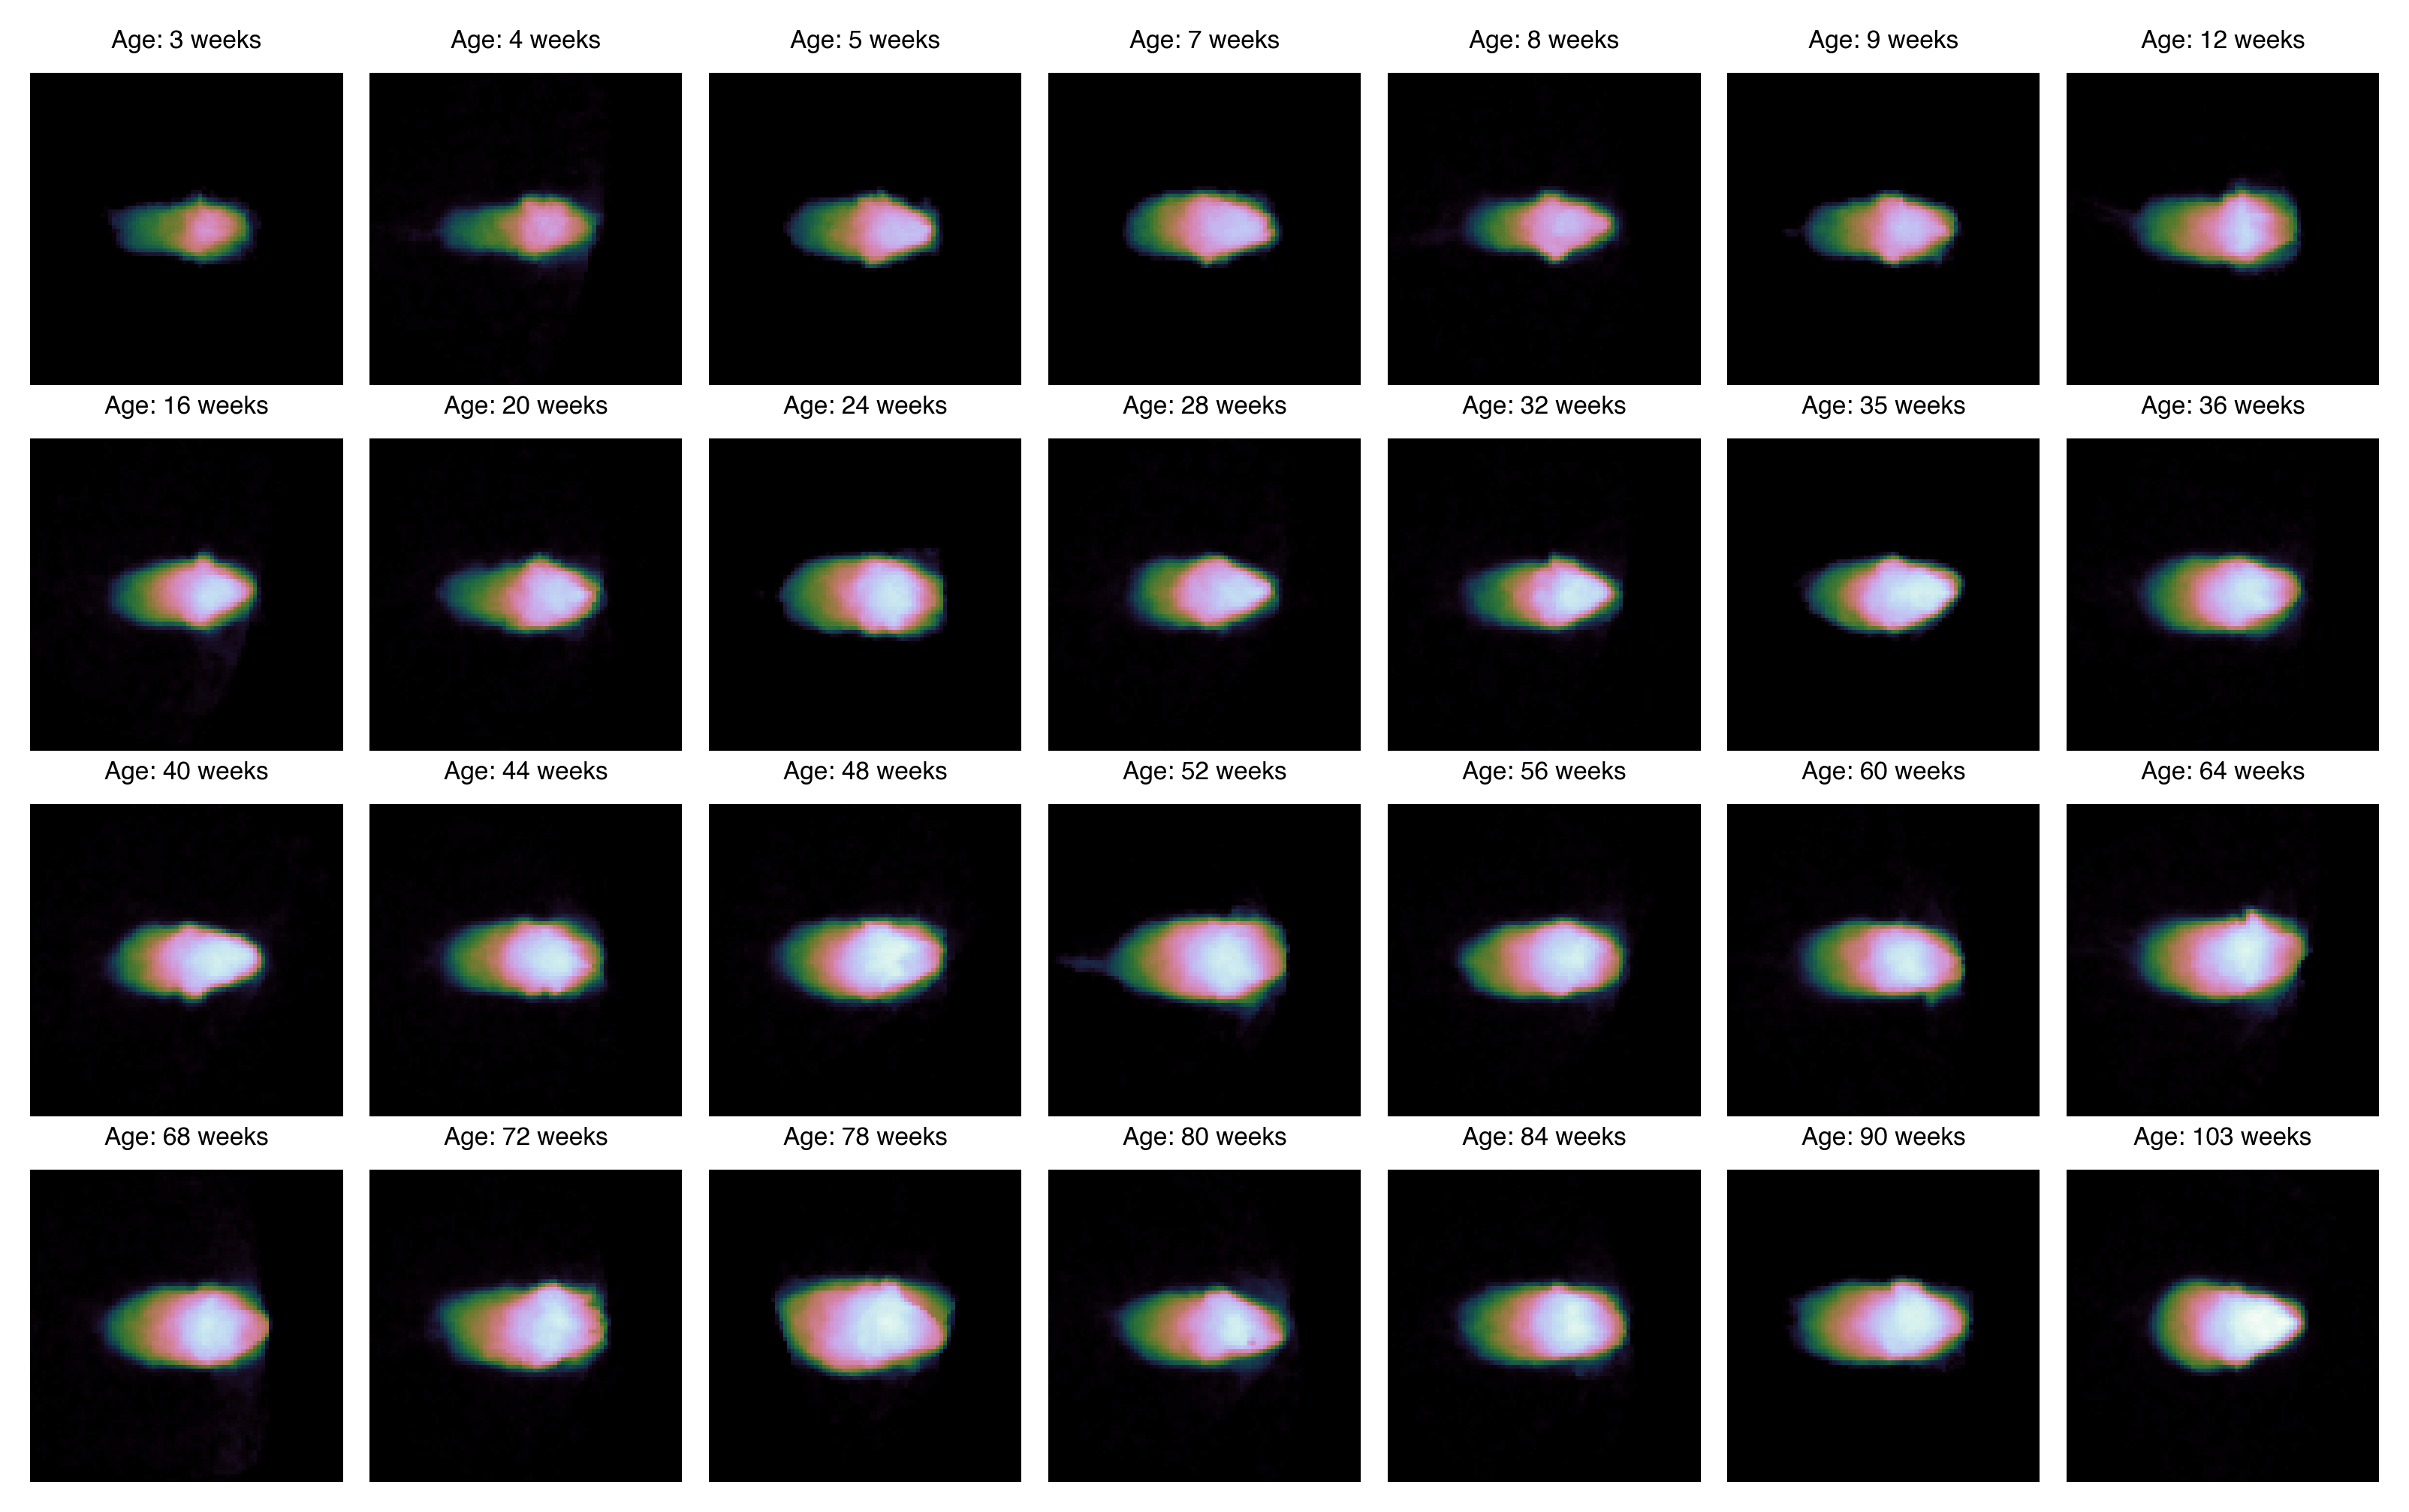

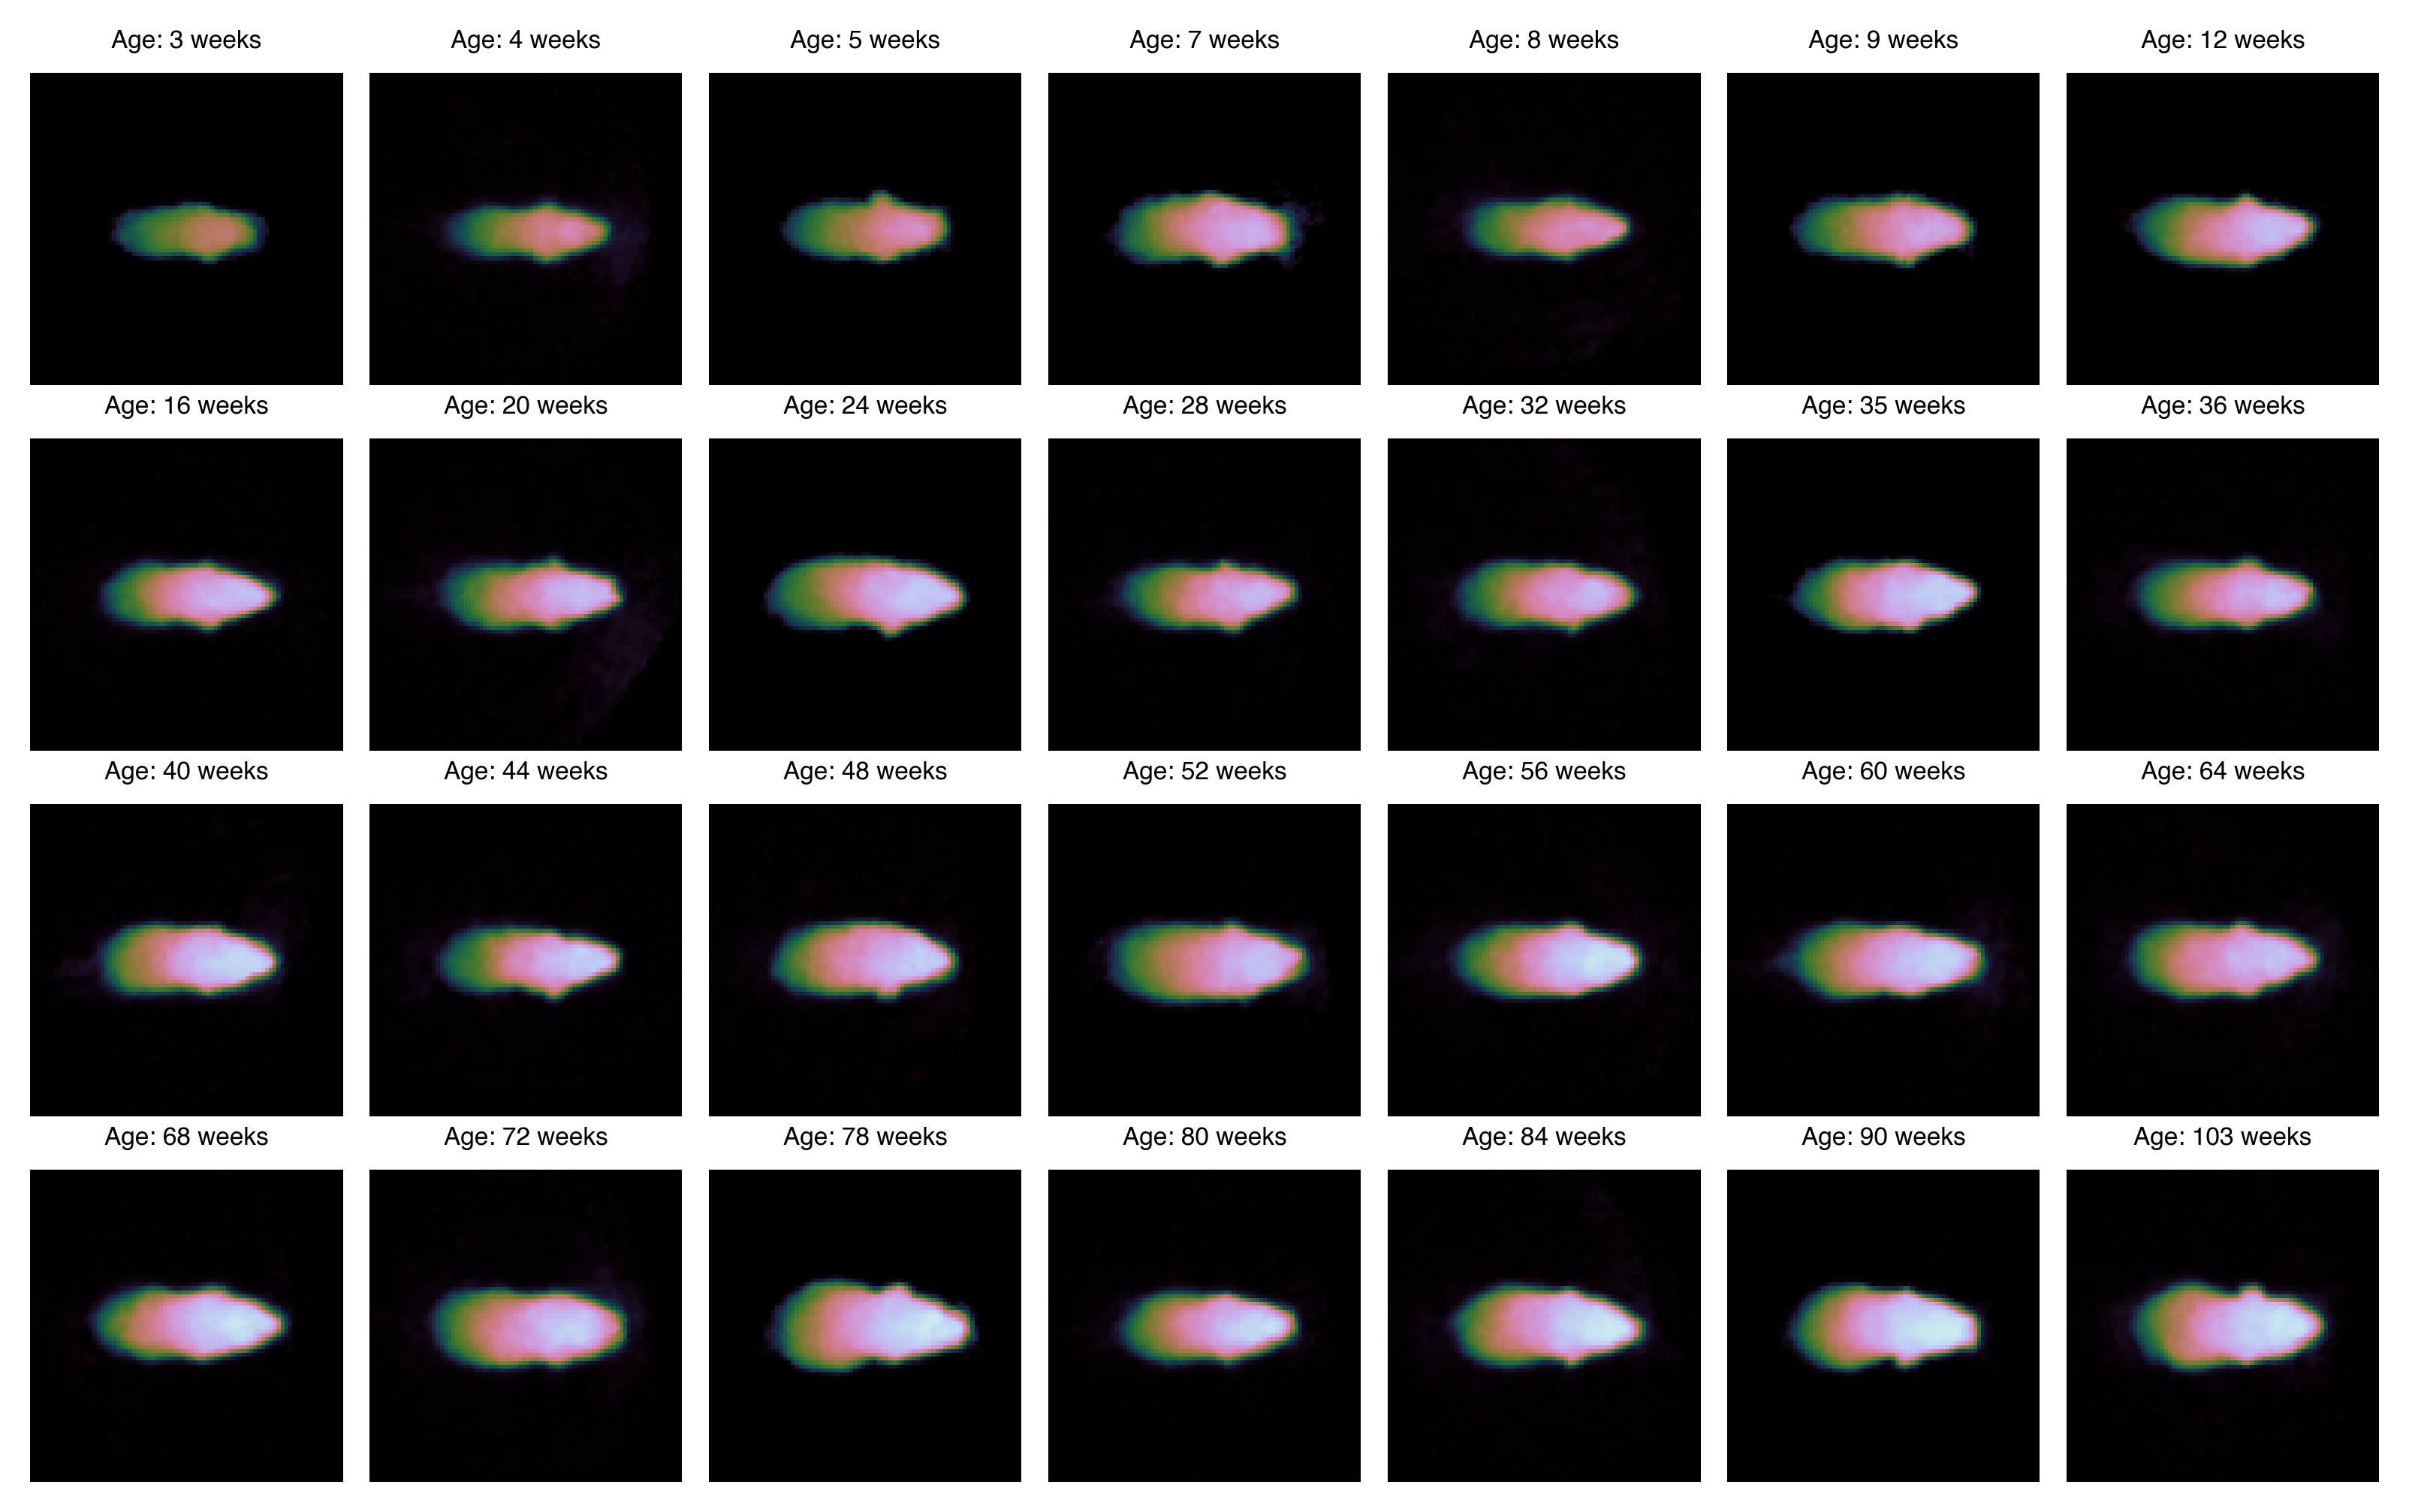

In [39]:
for key in keys:
    fig, ax = plt.subplots(4, 7, figsize=(8, 5))

    plt_frames = og_point_frames[key]

    for a, (_age, _frame) in zip(ax.flat, plt_frames.items()):
        a.imshow(_frame, cmap="cubehelix", clim=(0, 100))
        a.set(title="Age: {} weeks".format(_age), aspect="equal")
        a.axis("off")
    fig.tight_layout()

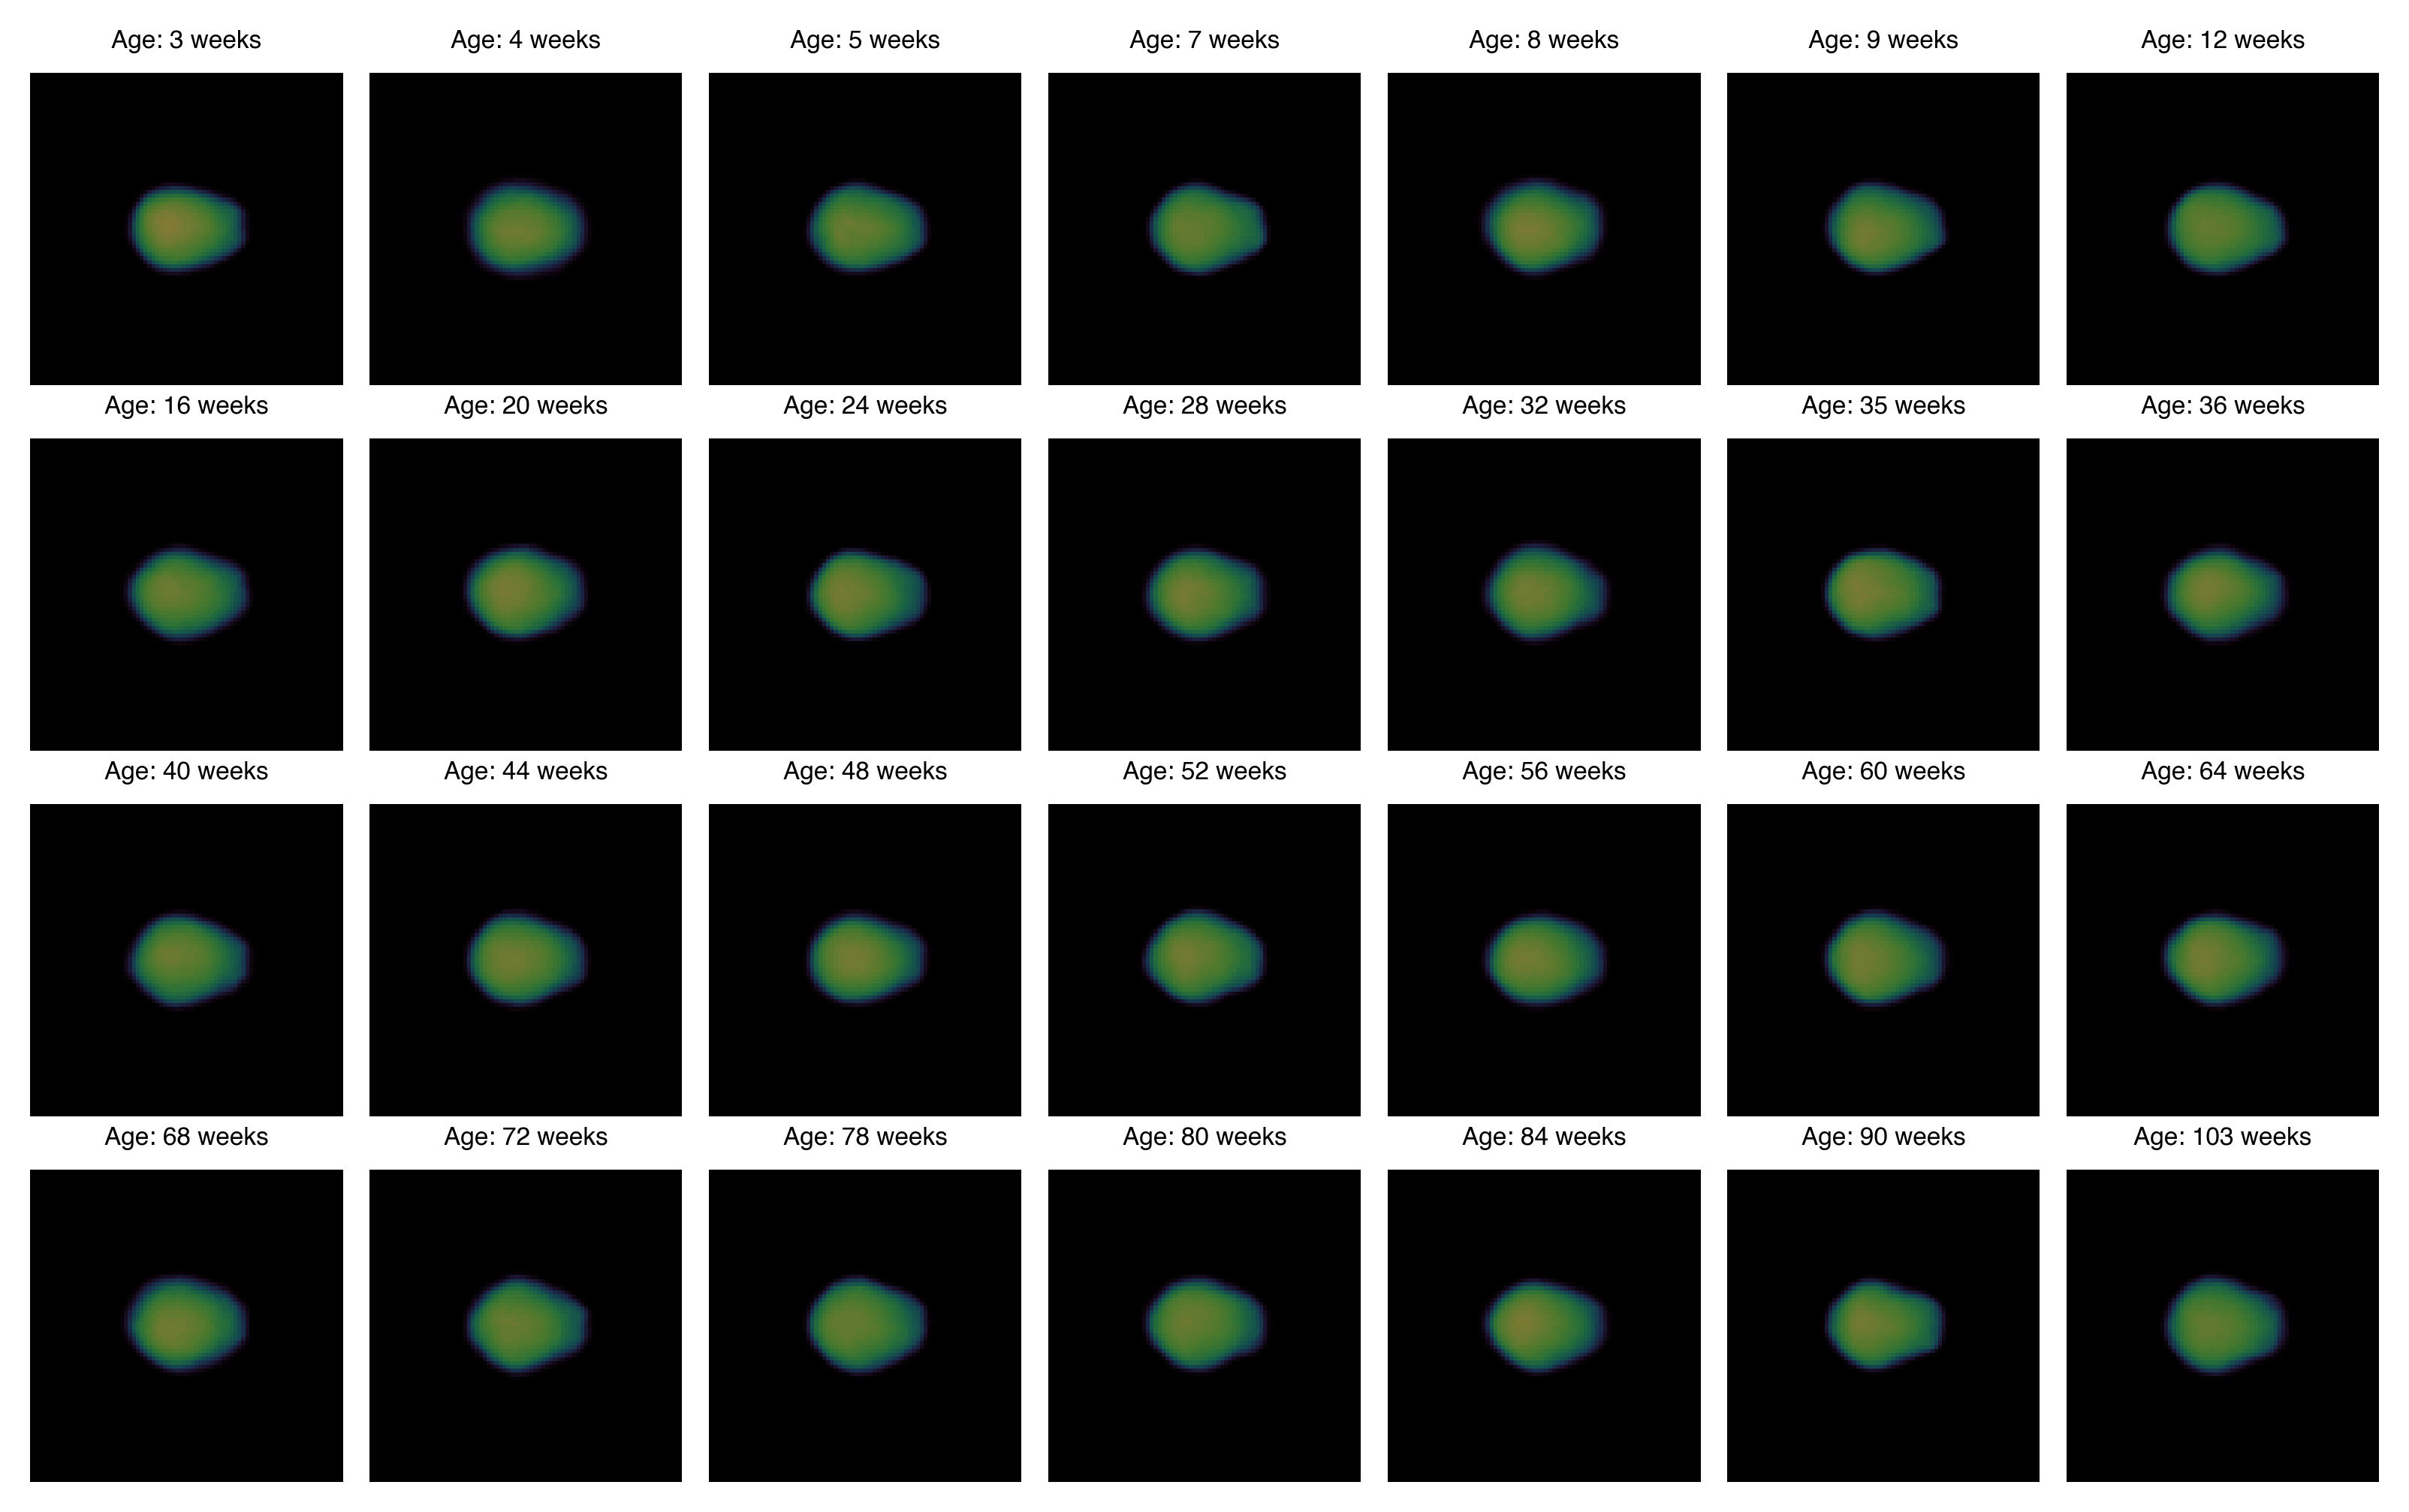

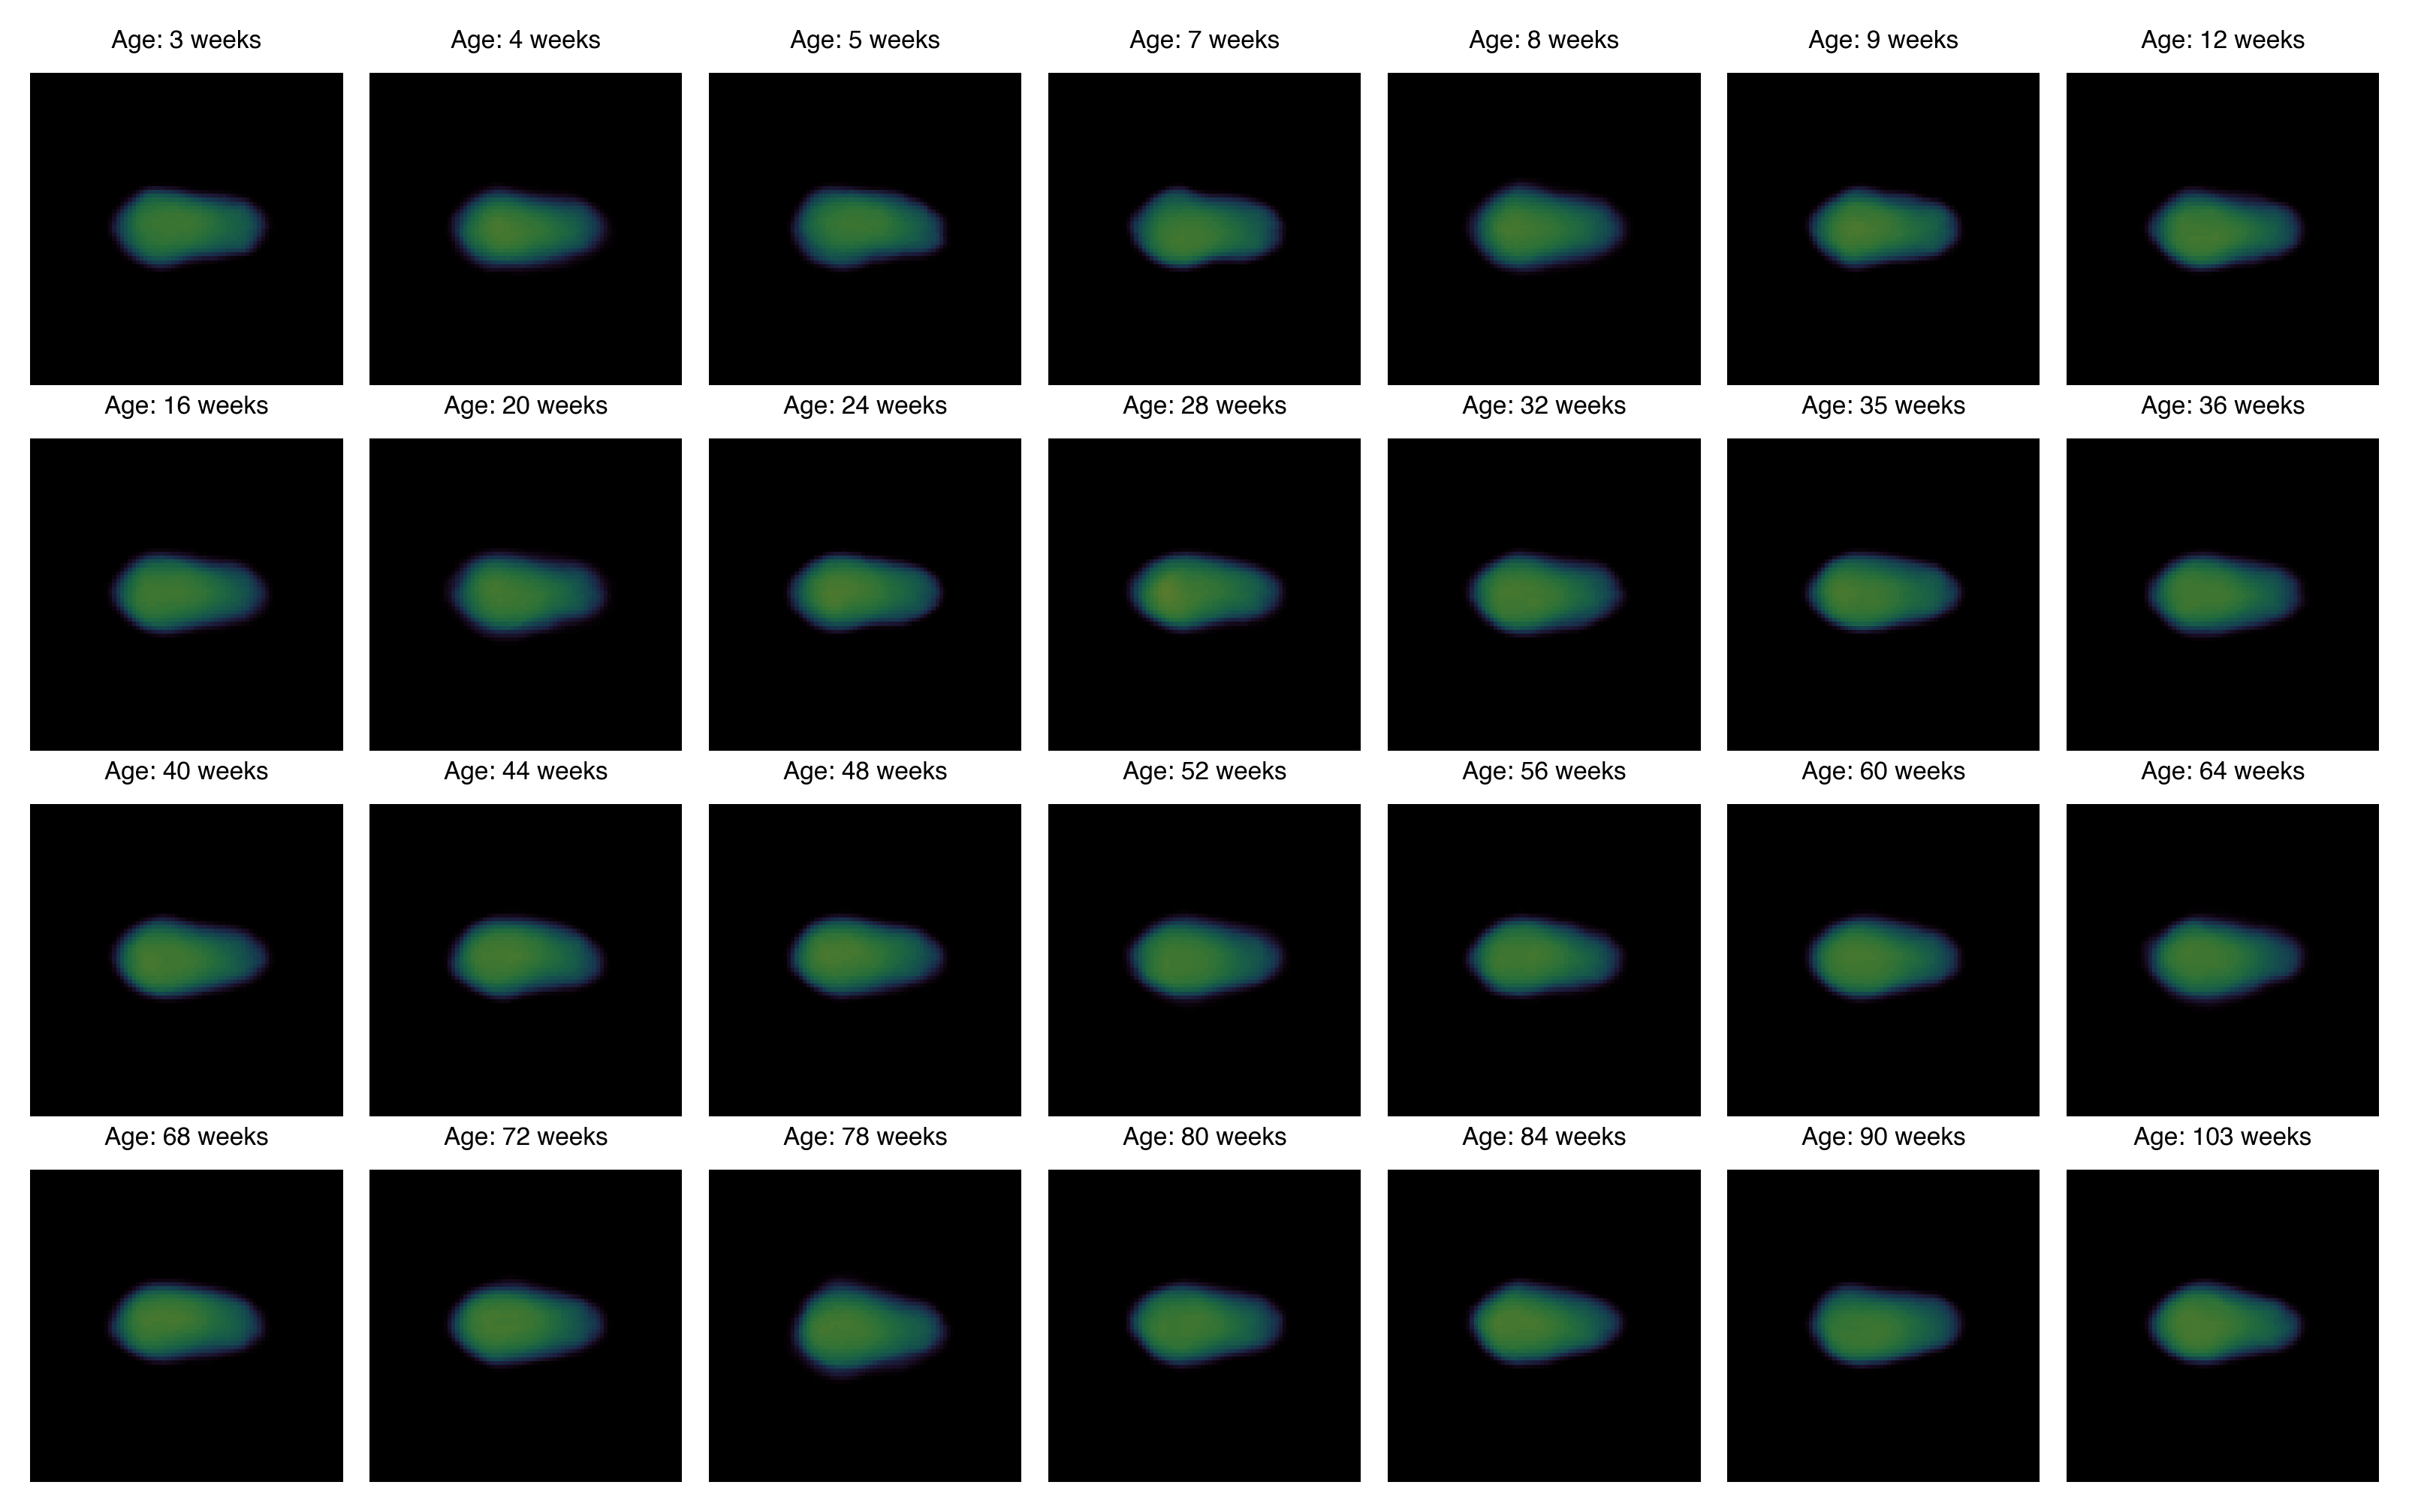

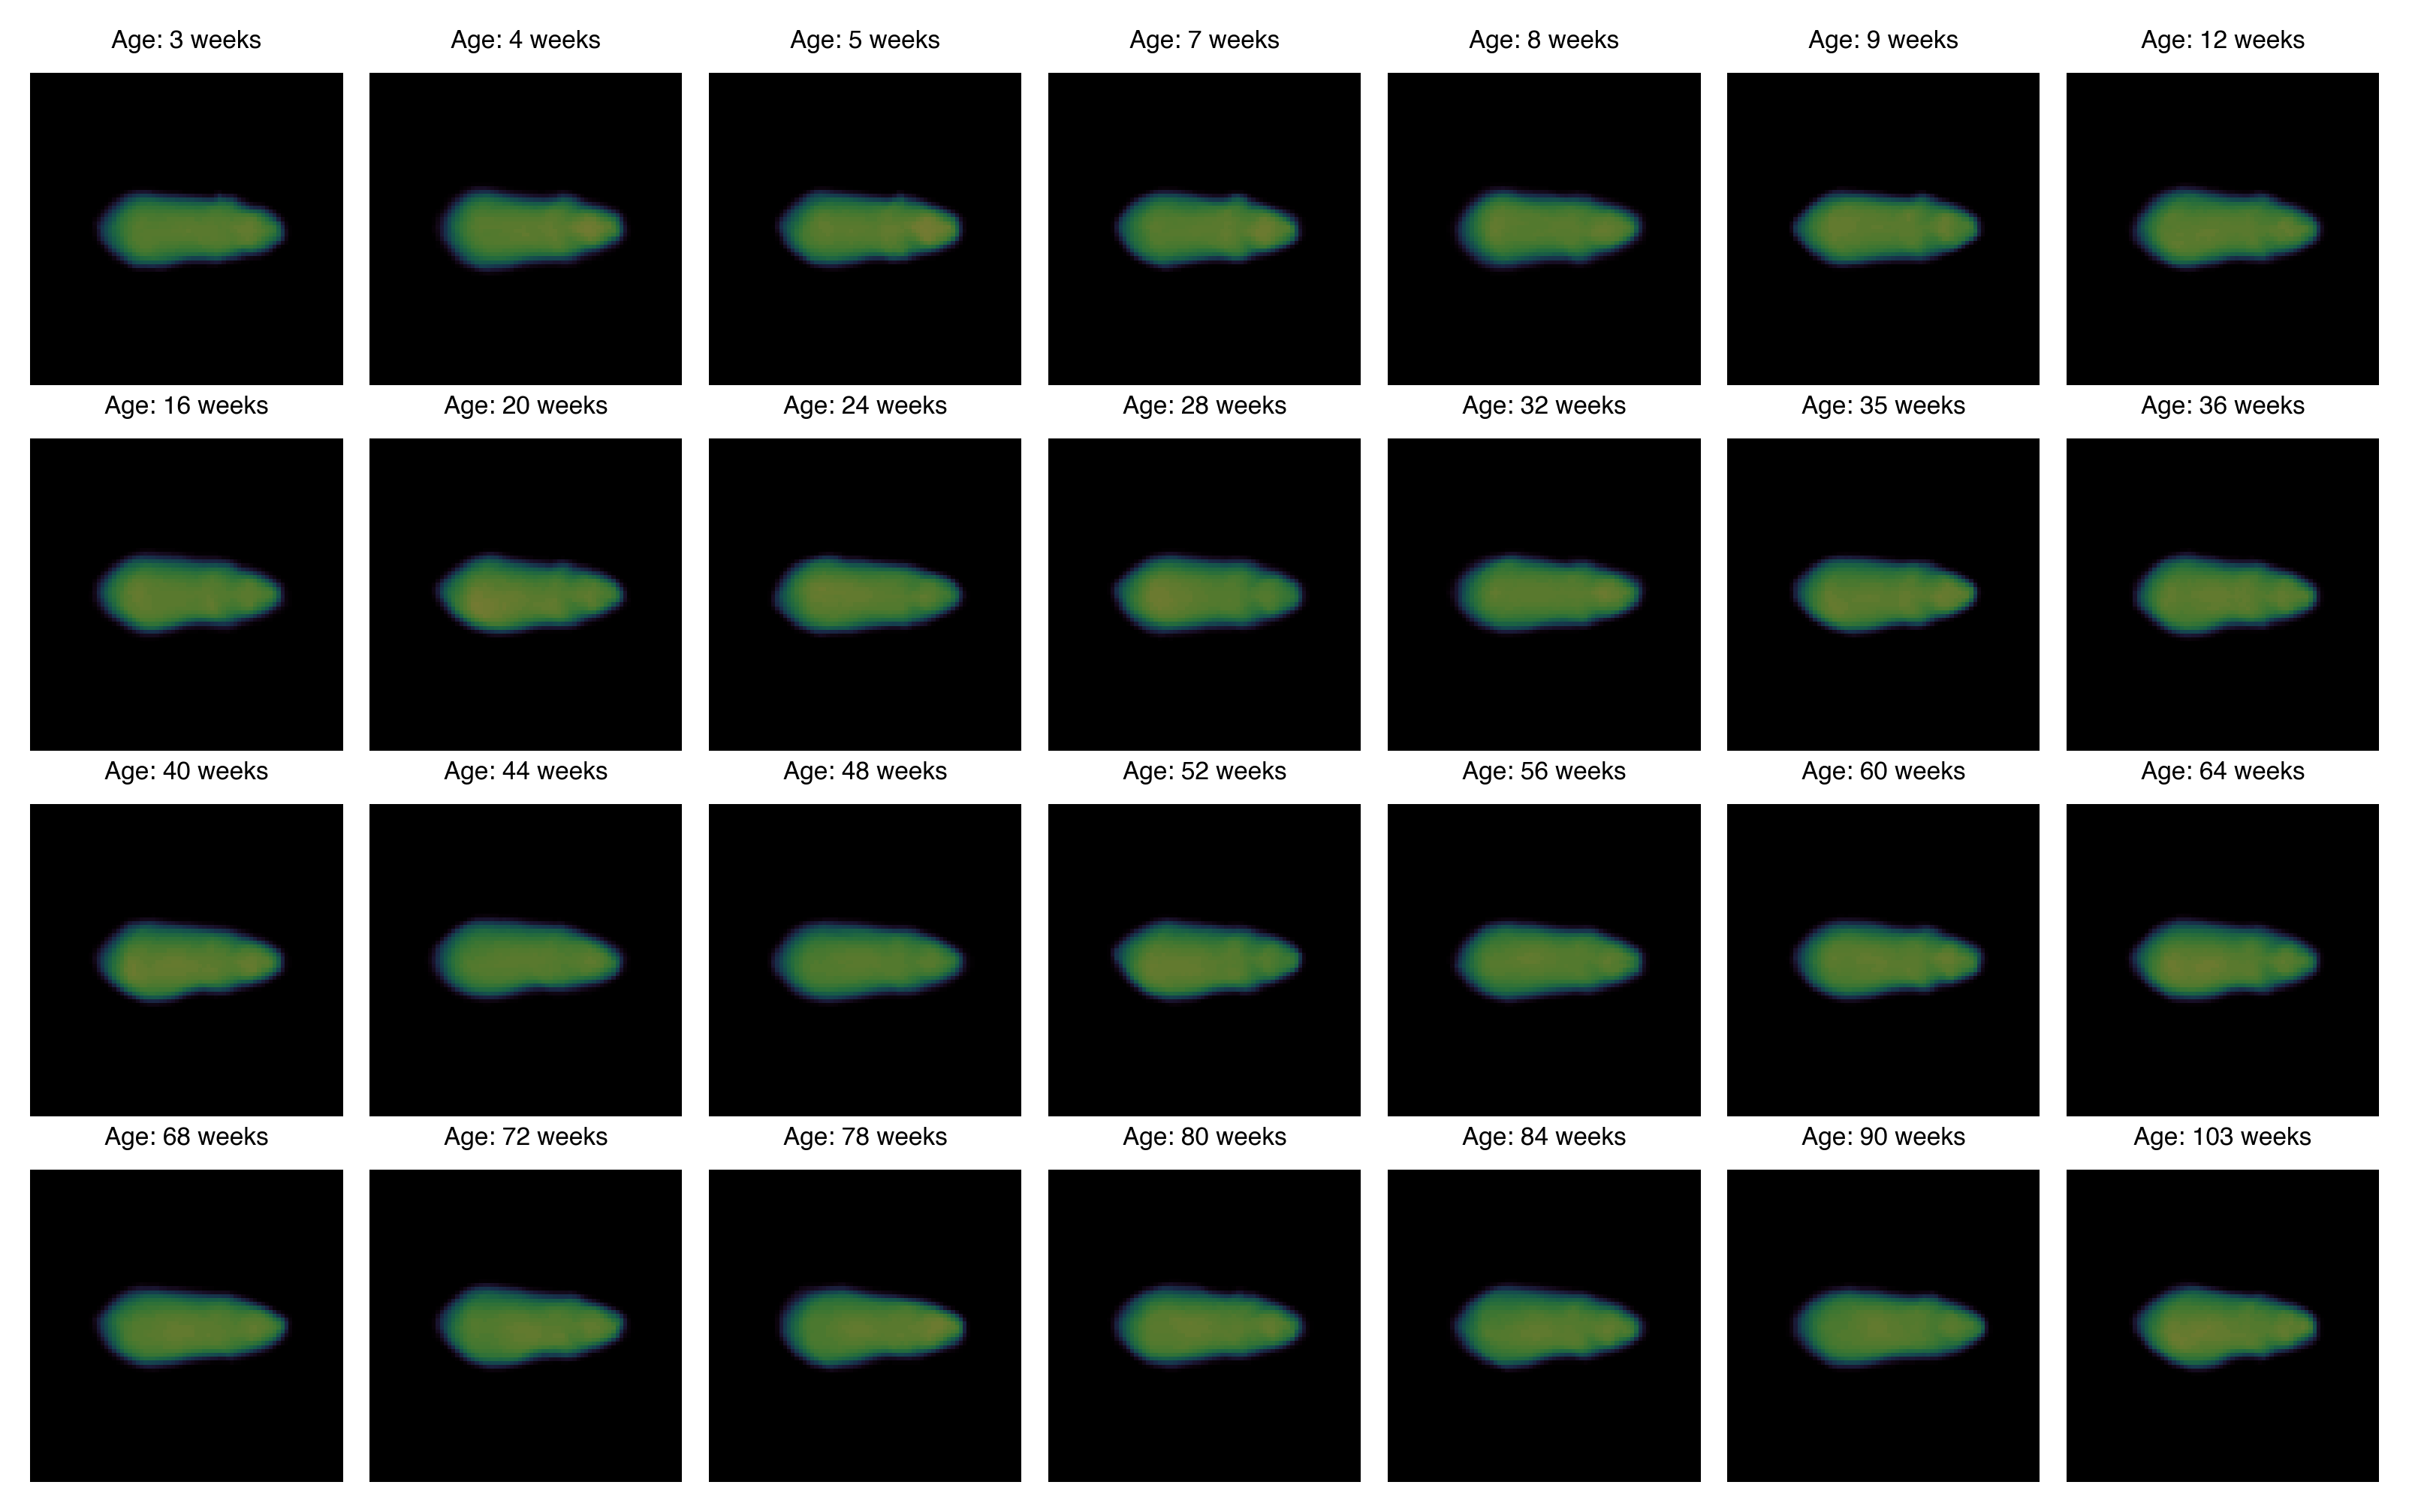

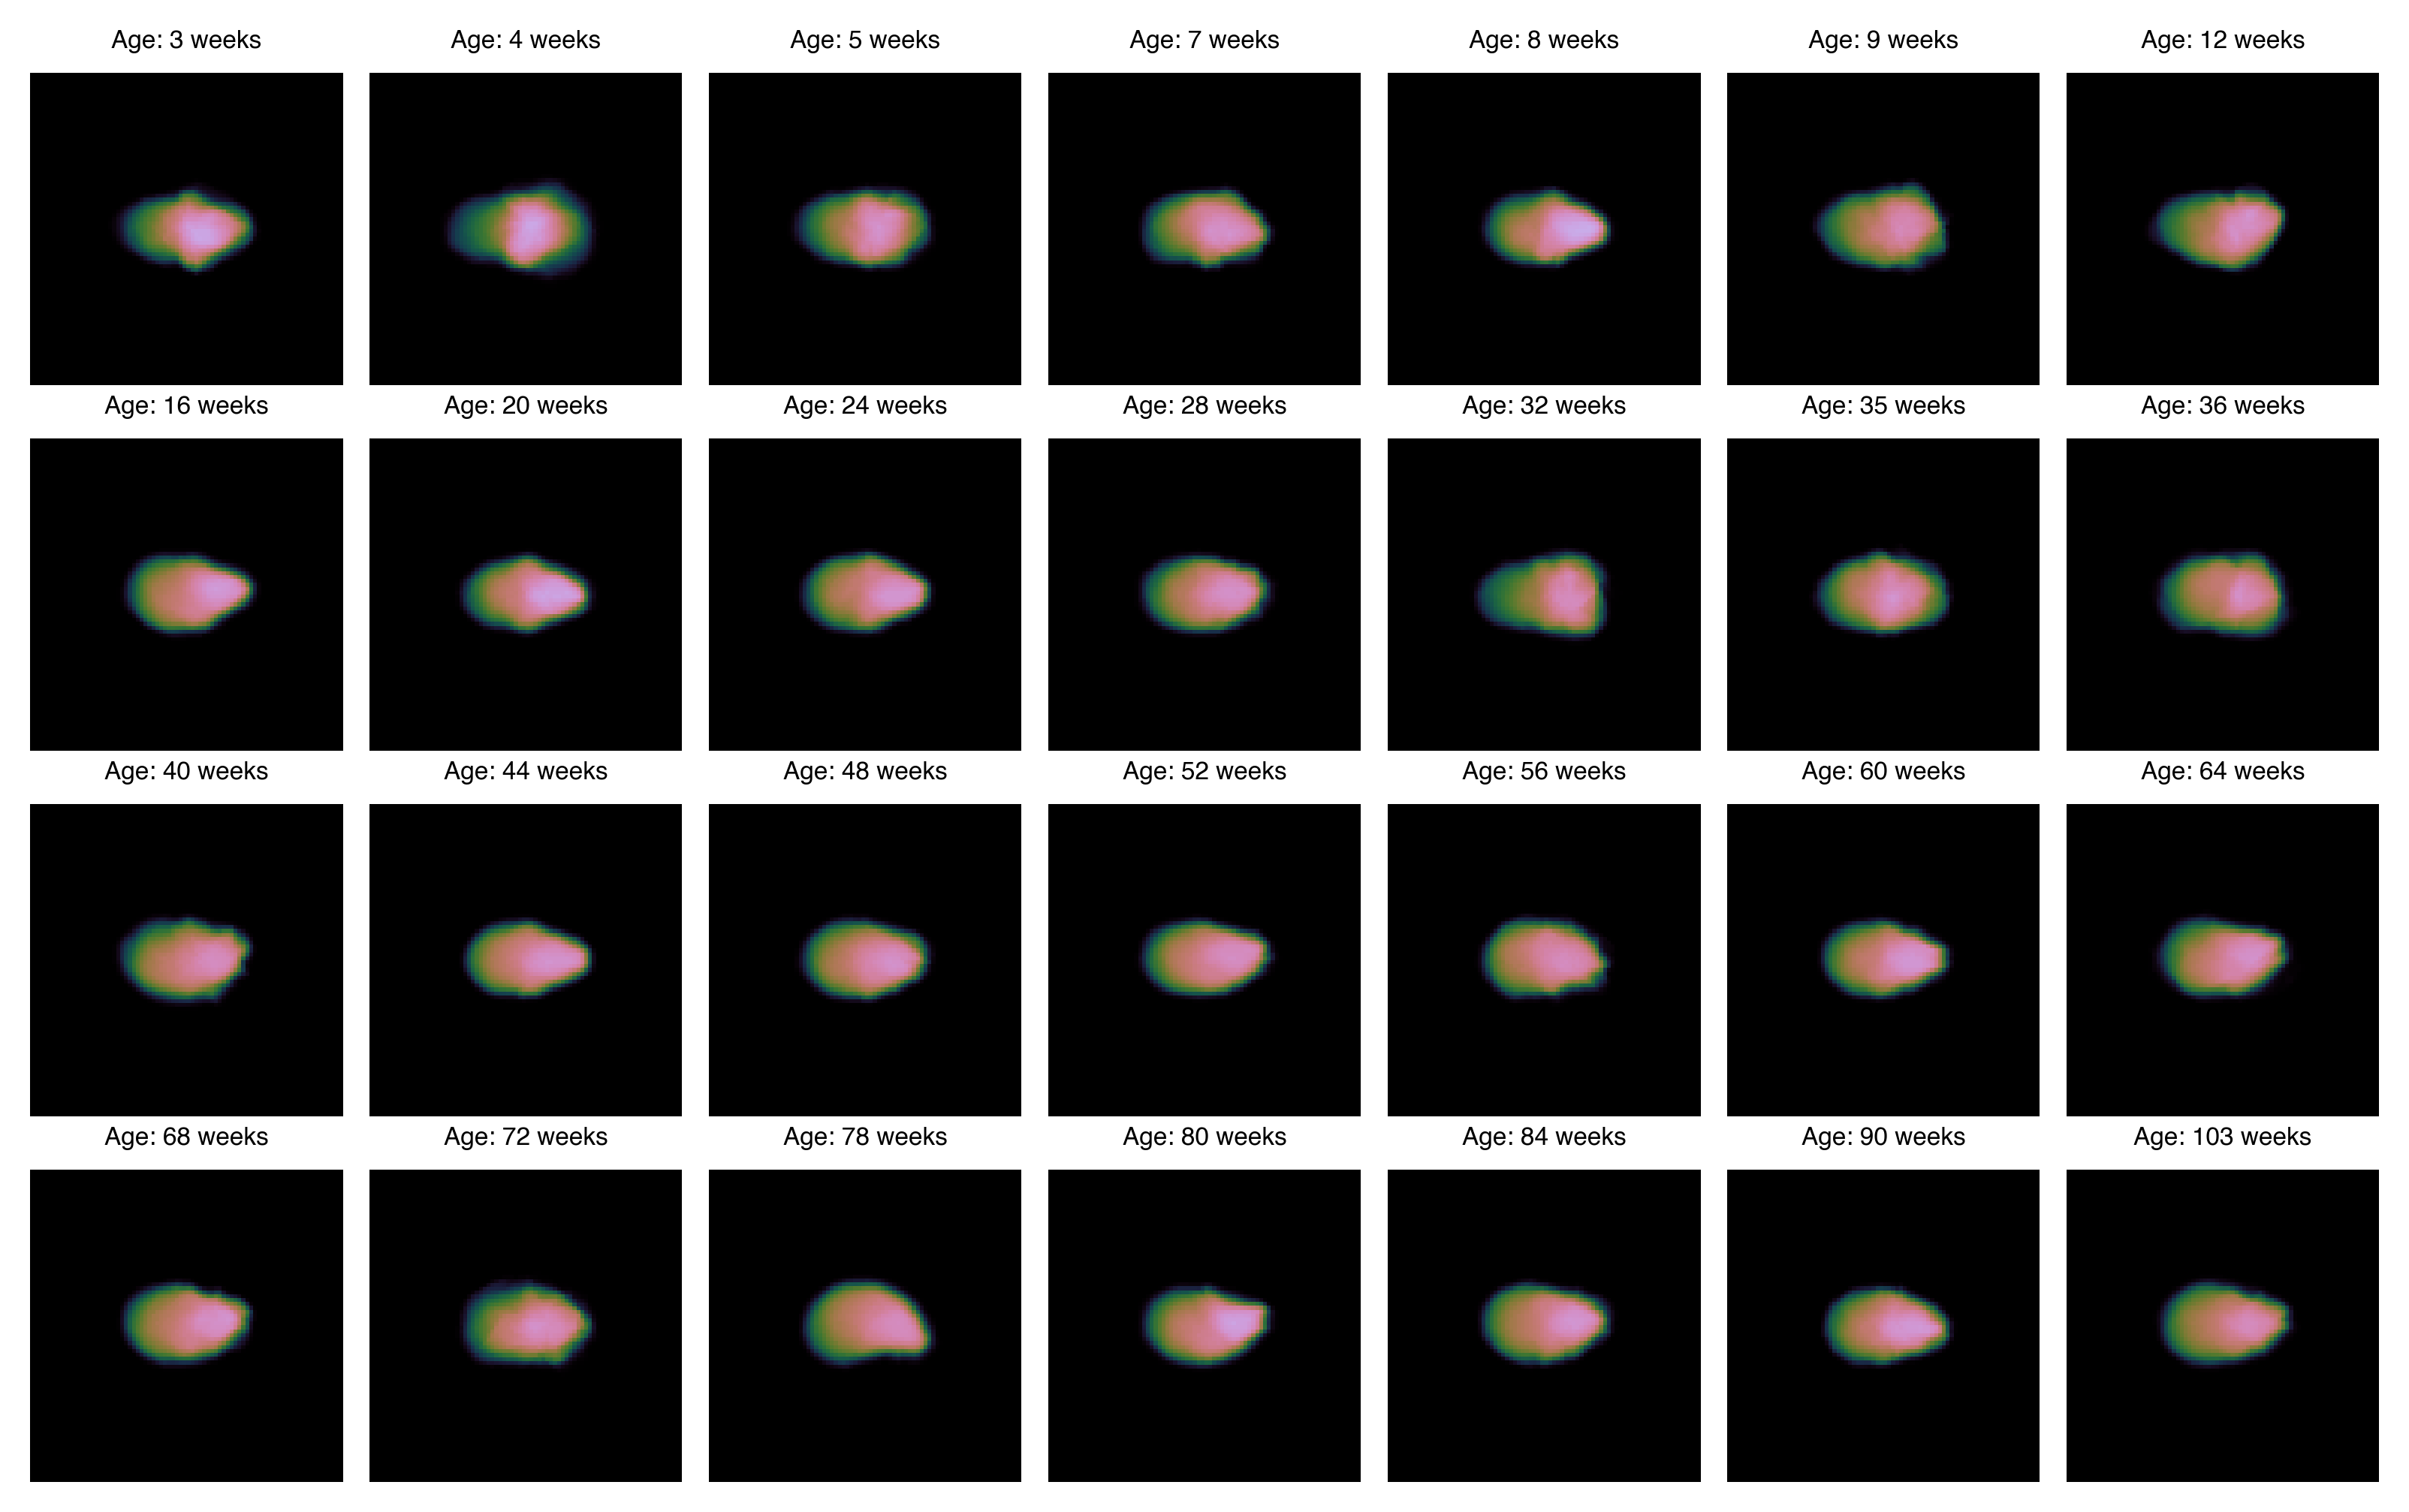

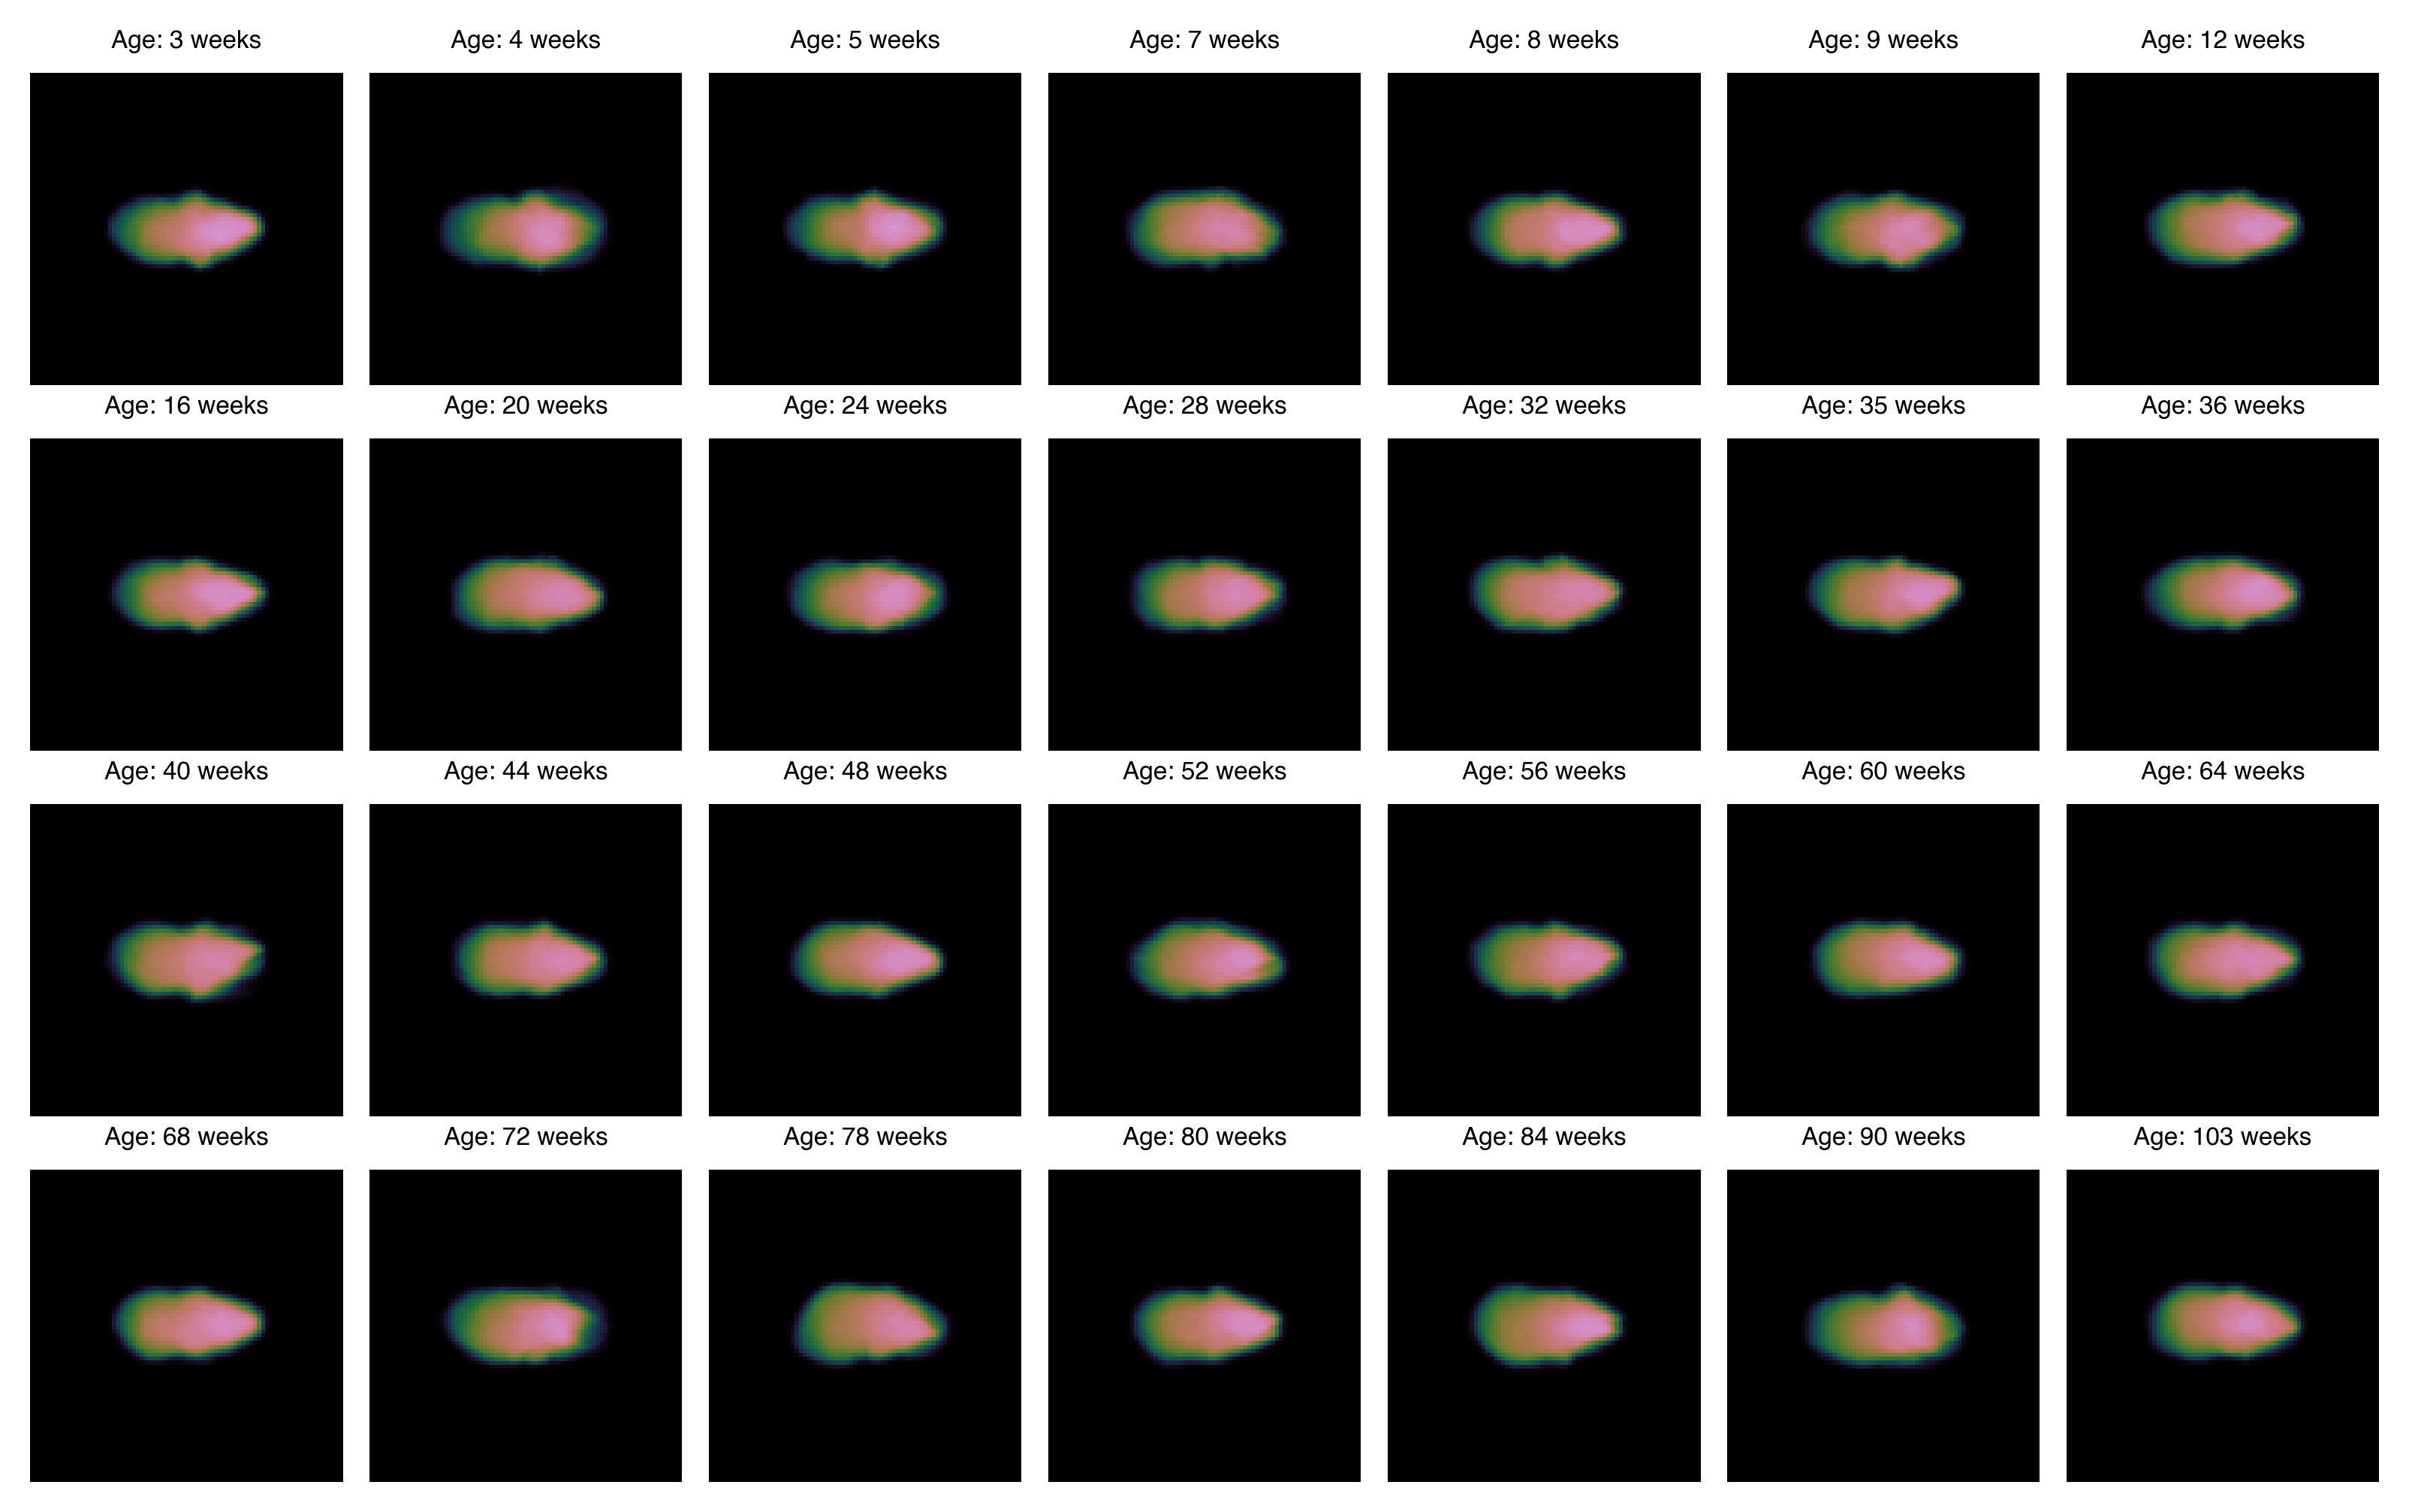

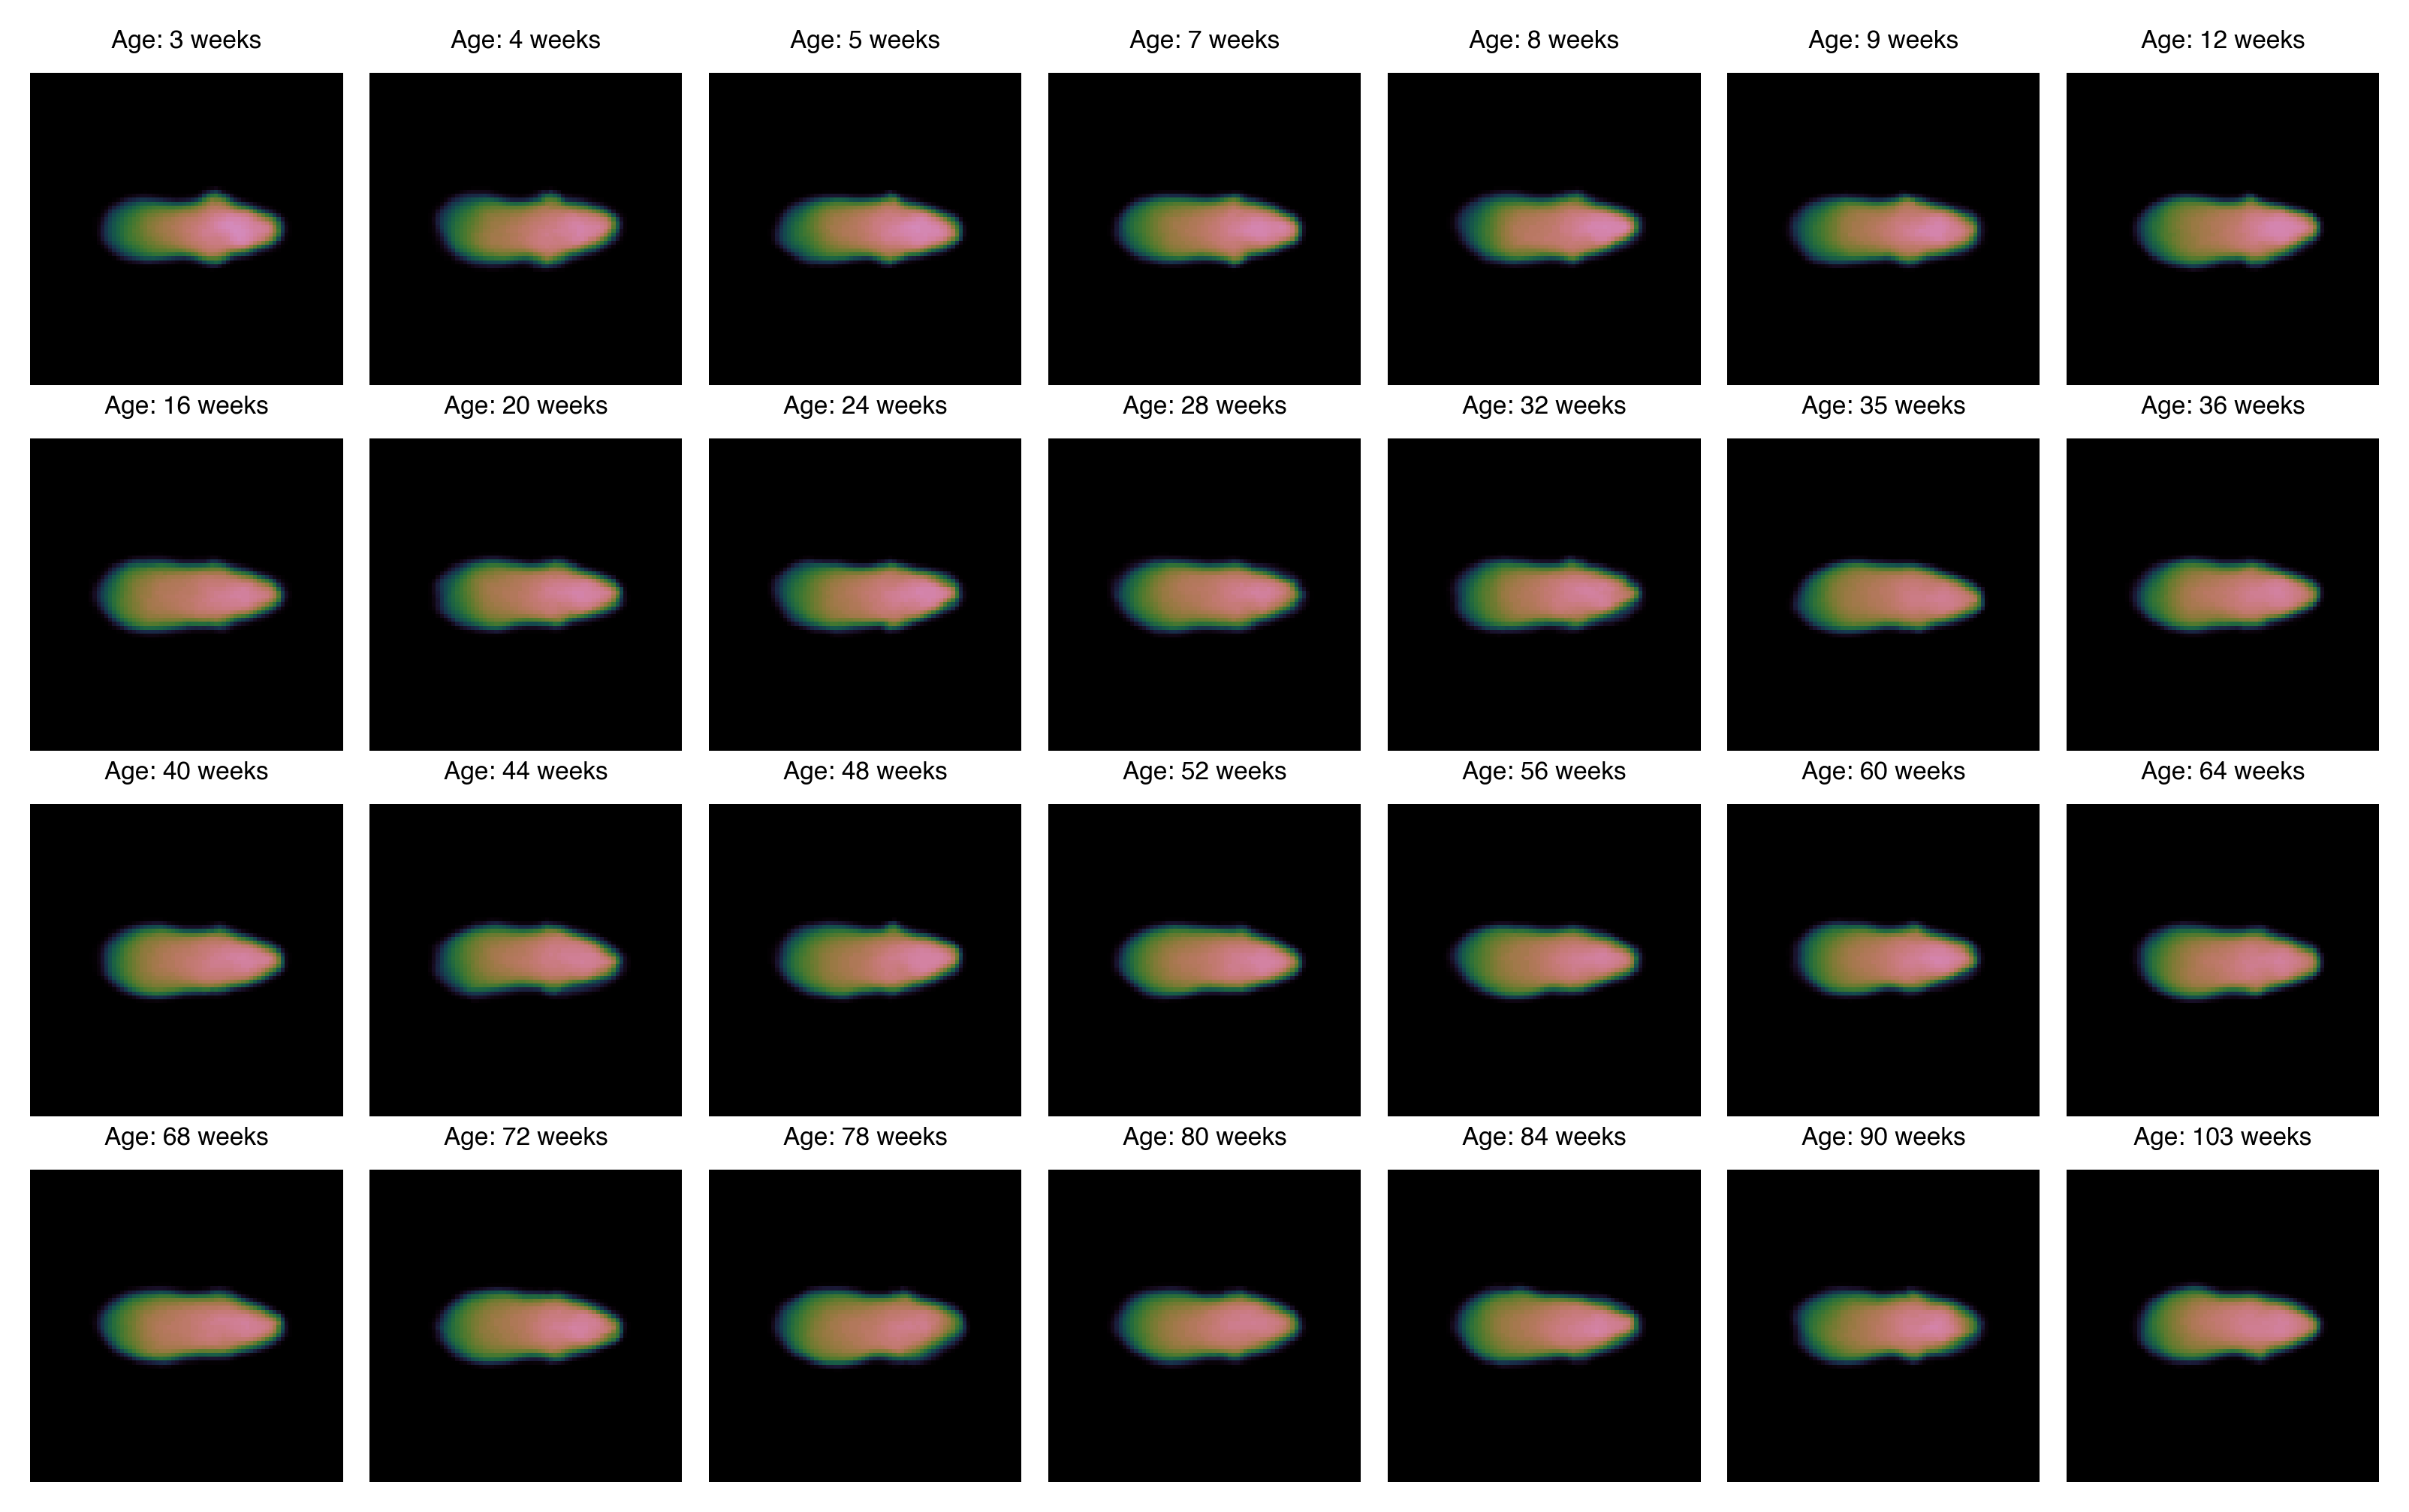

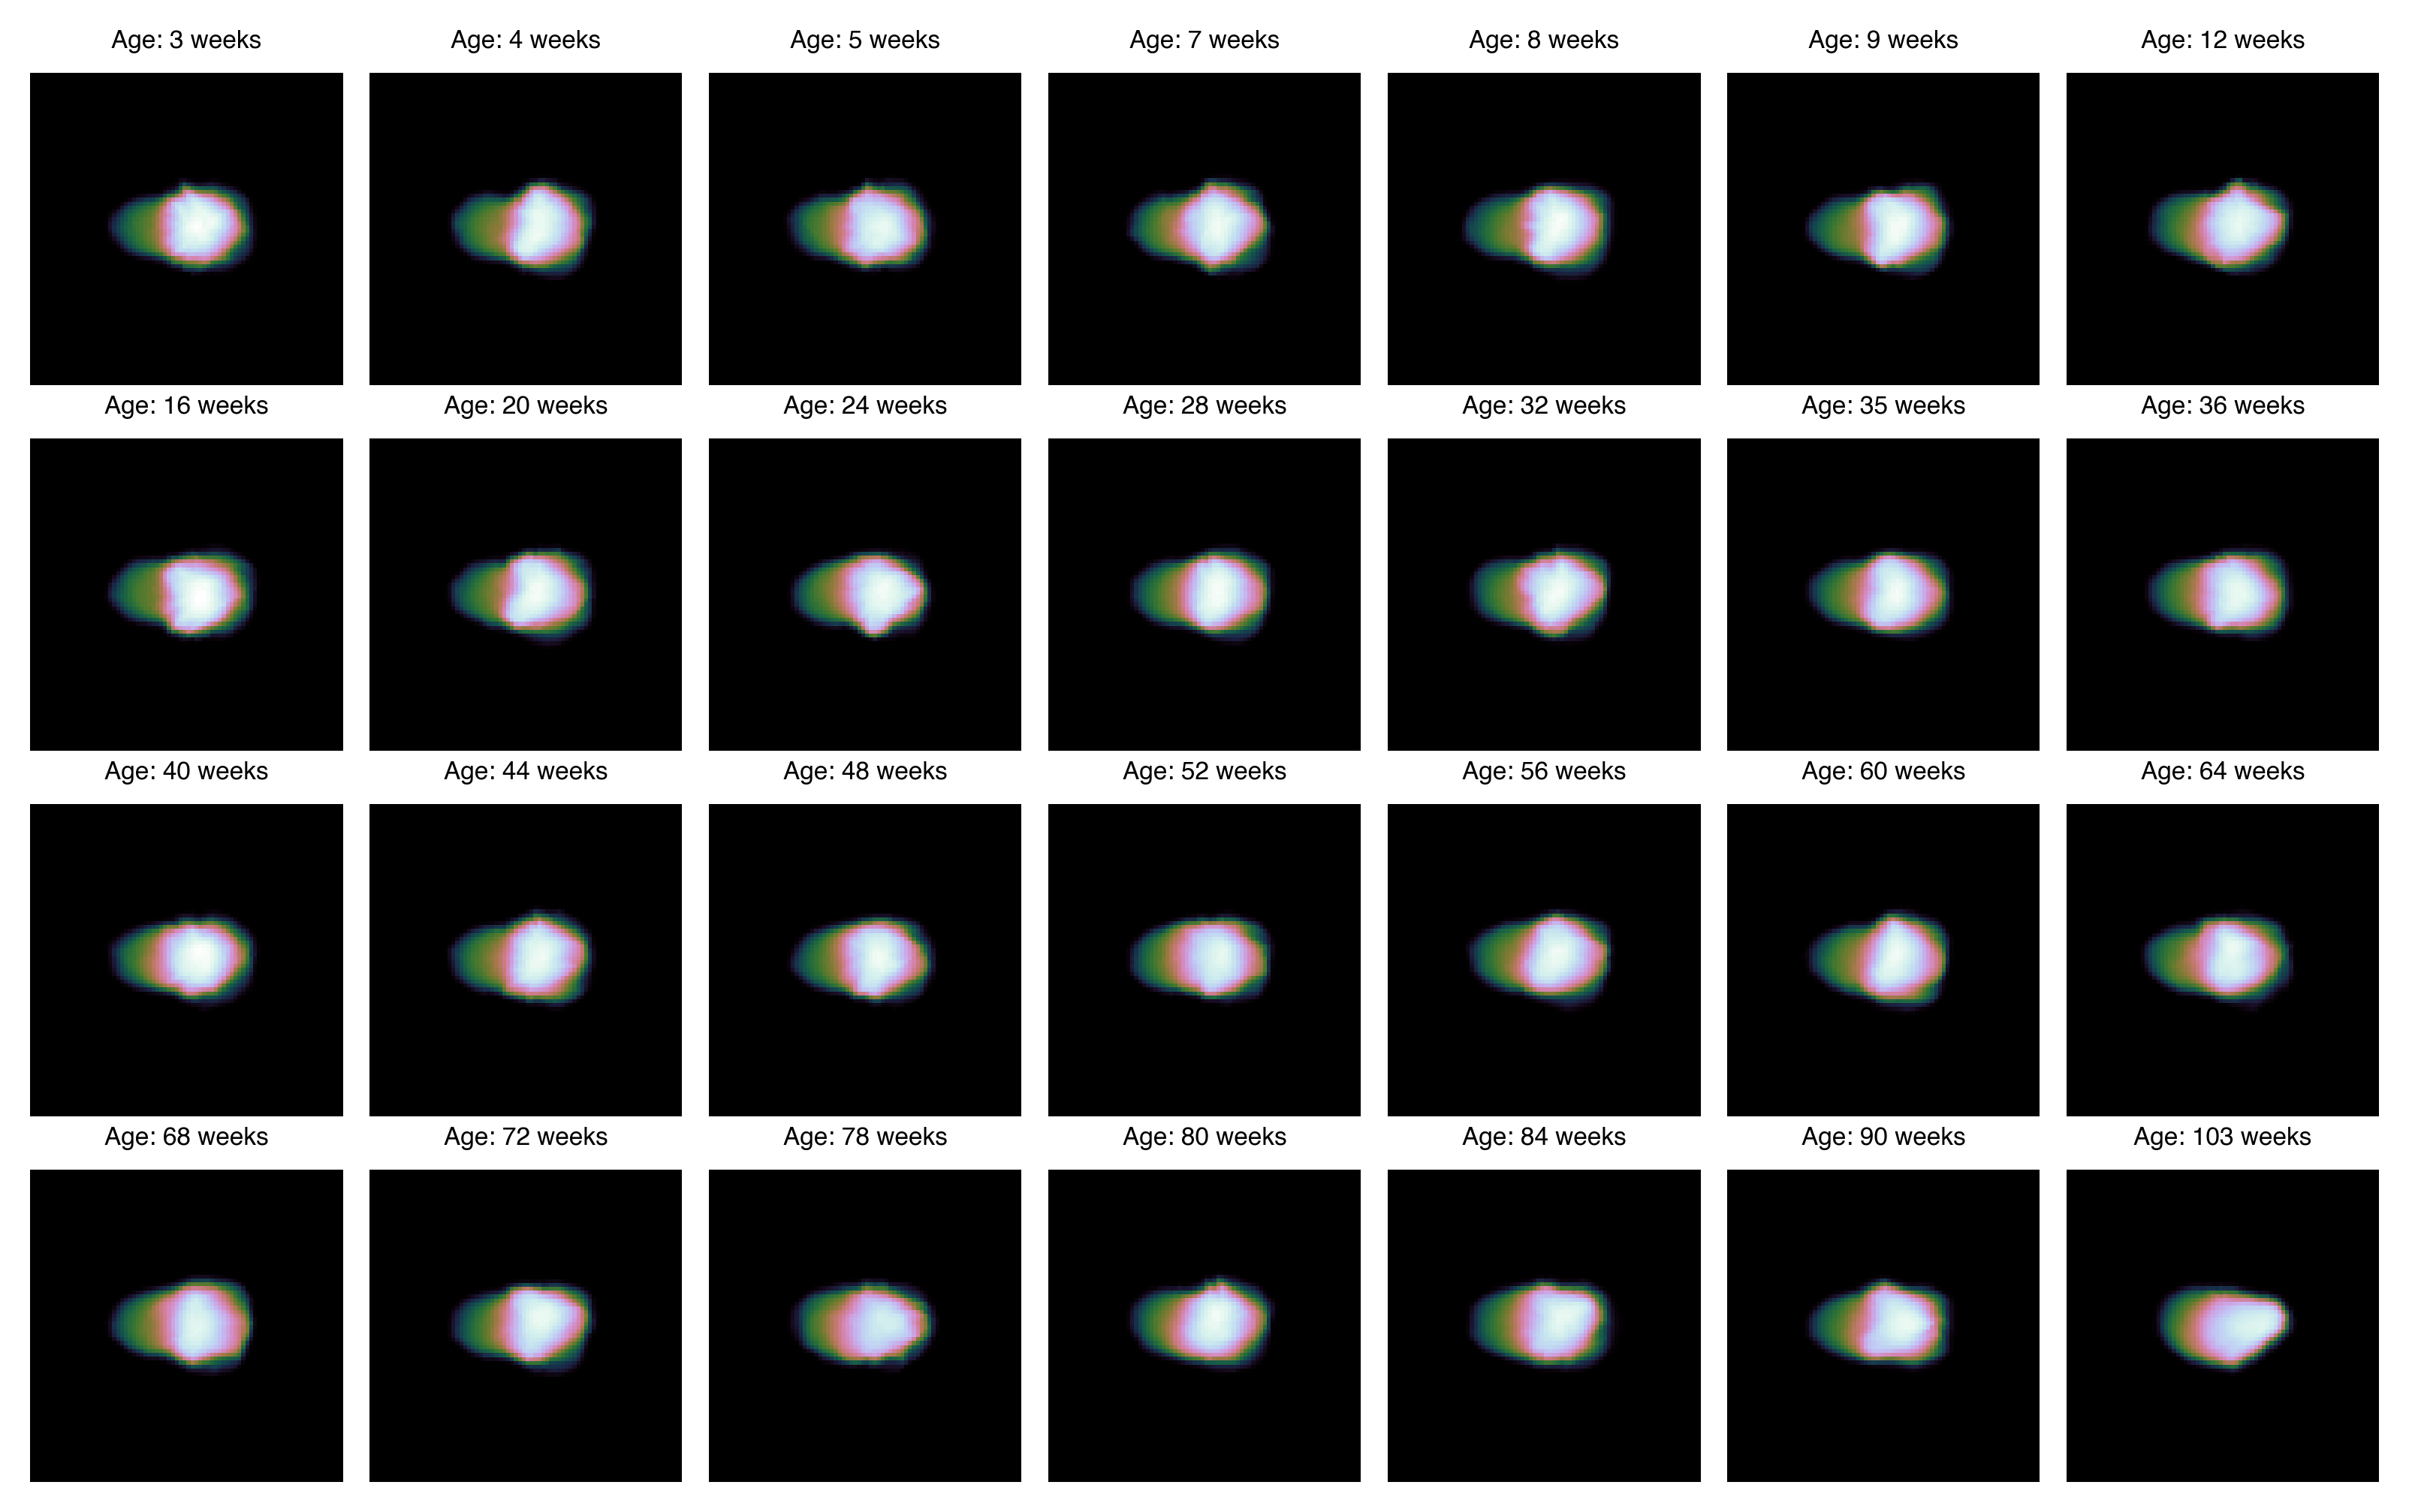

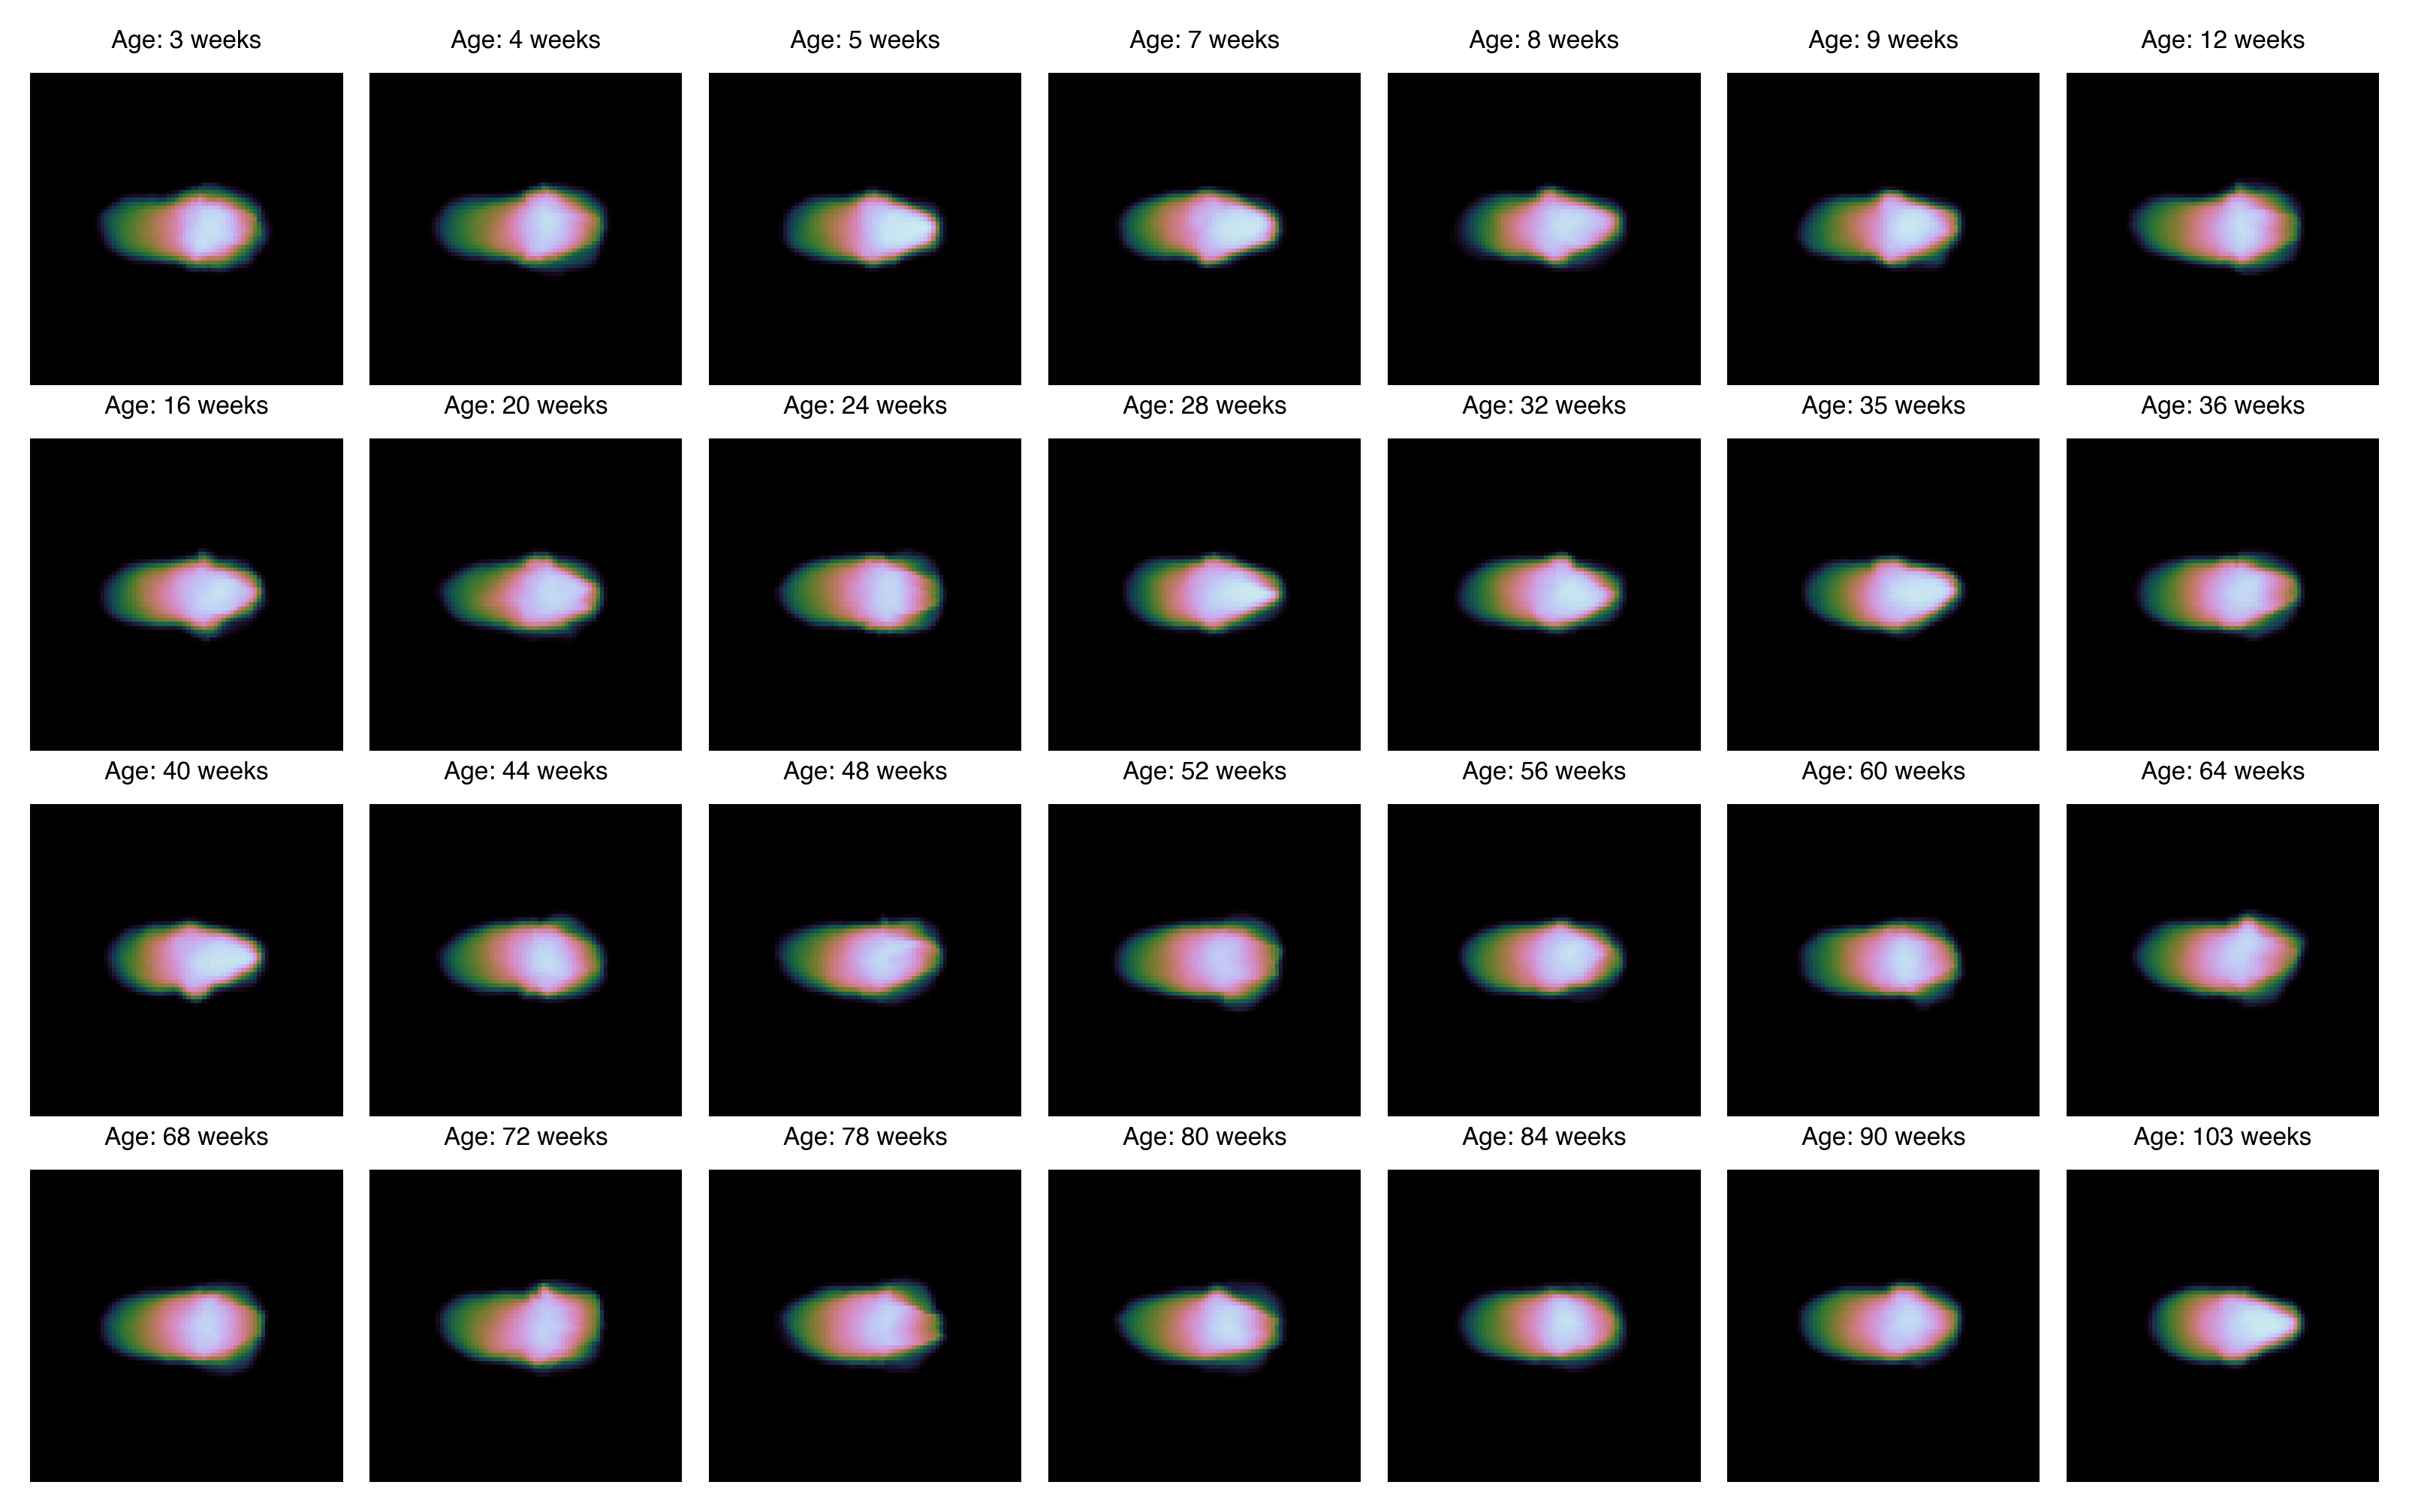

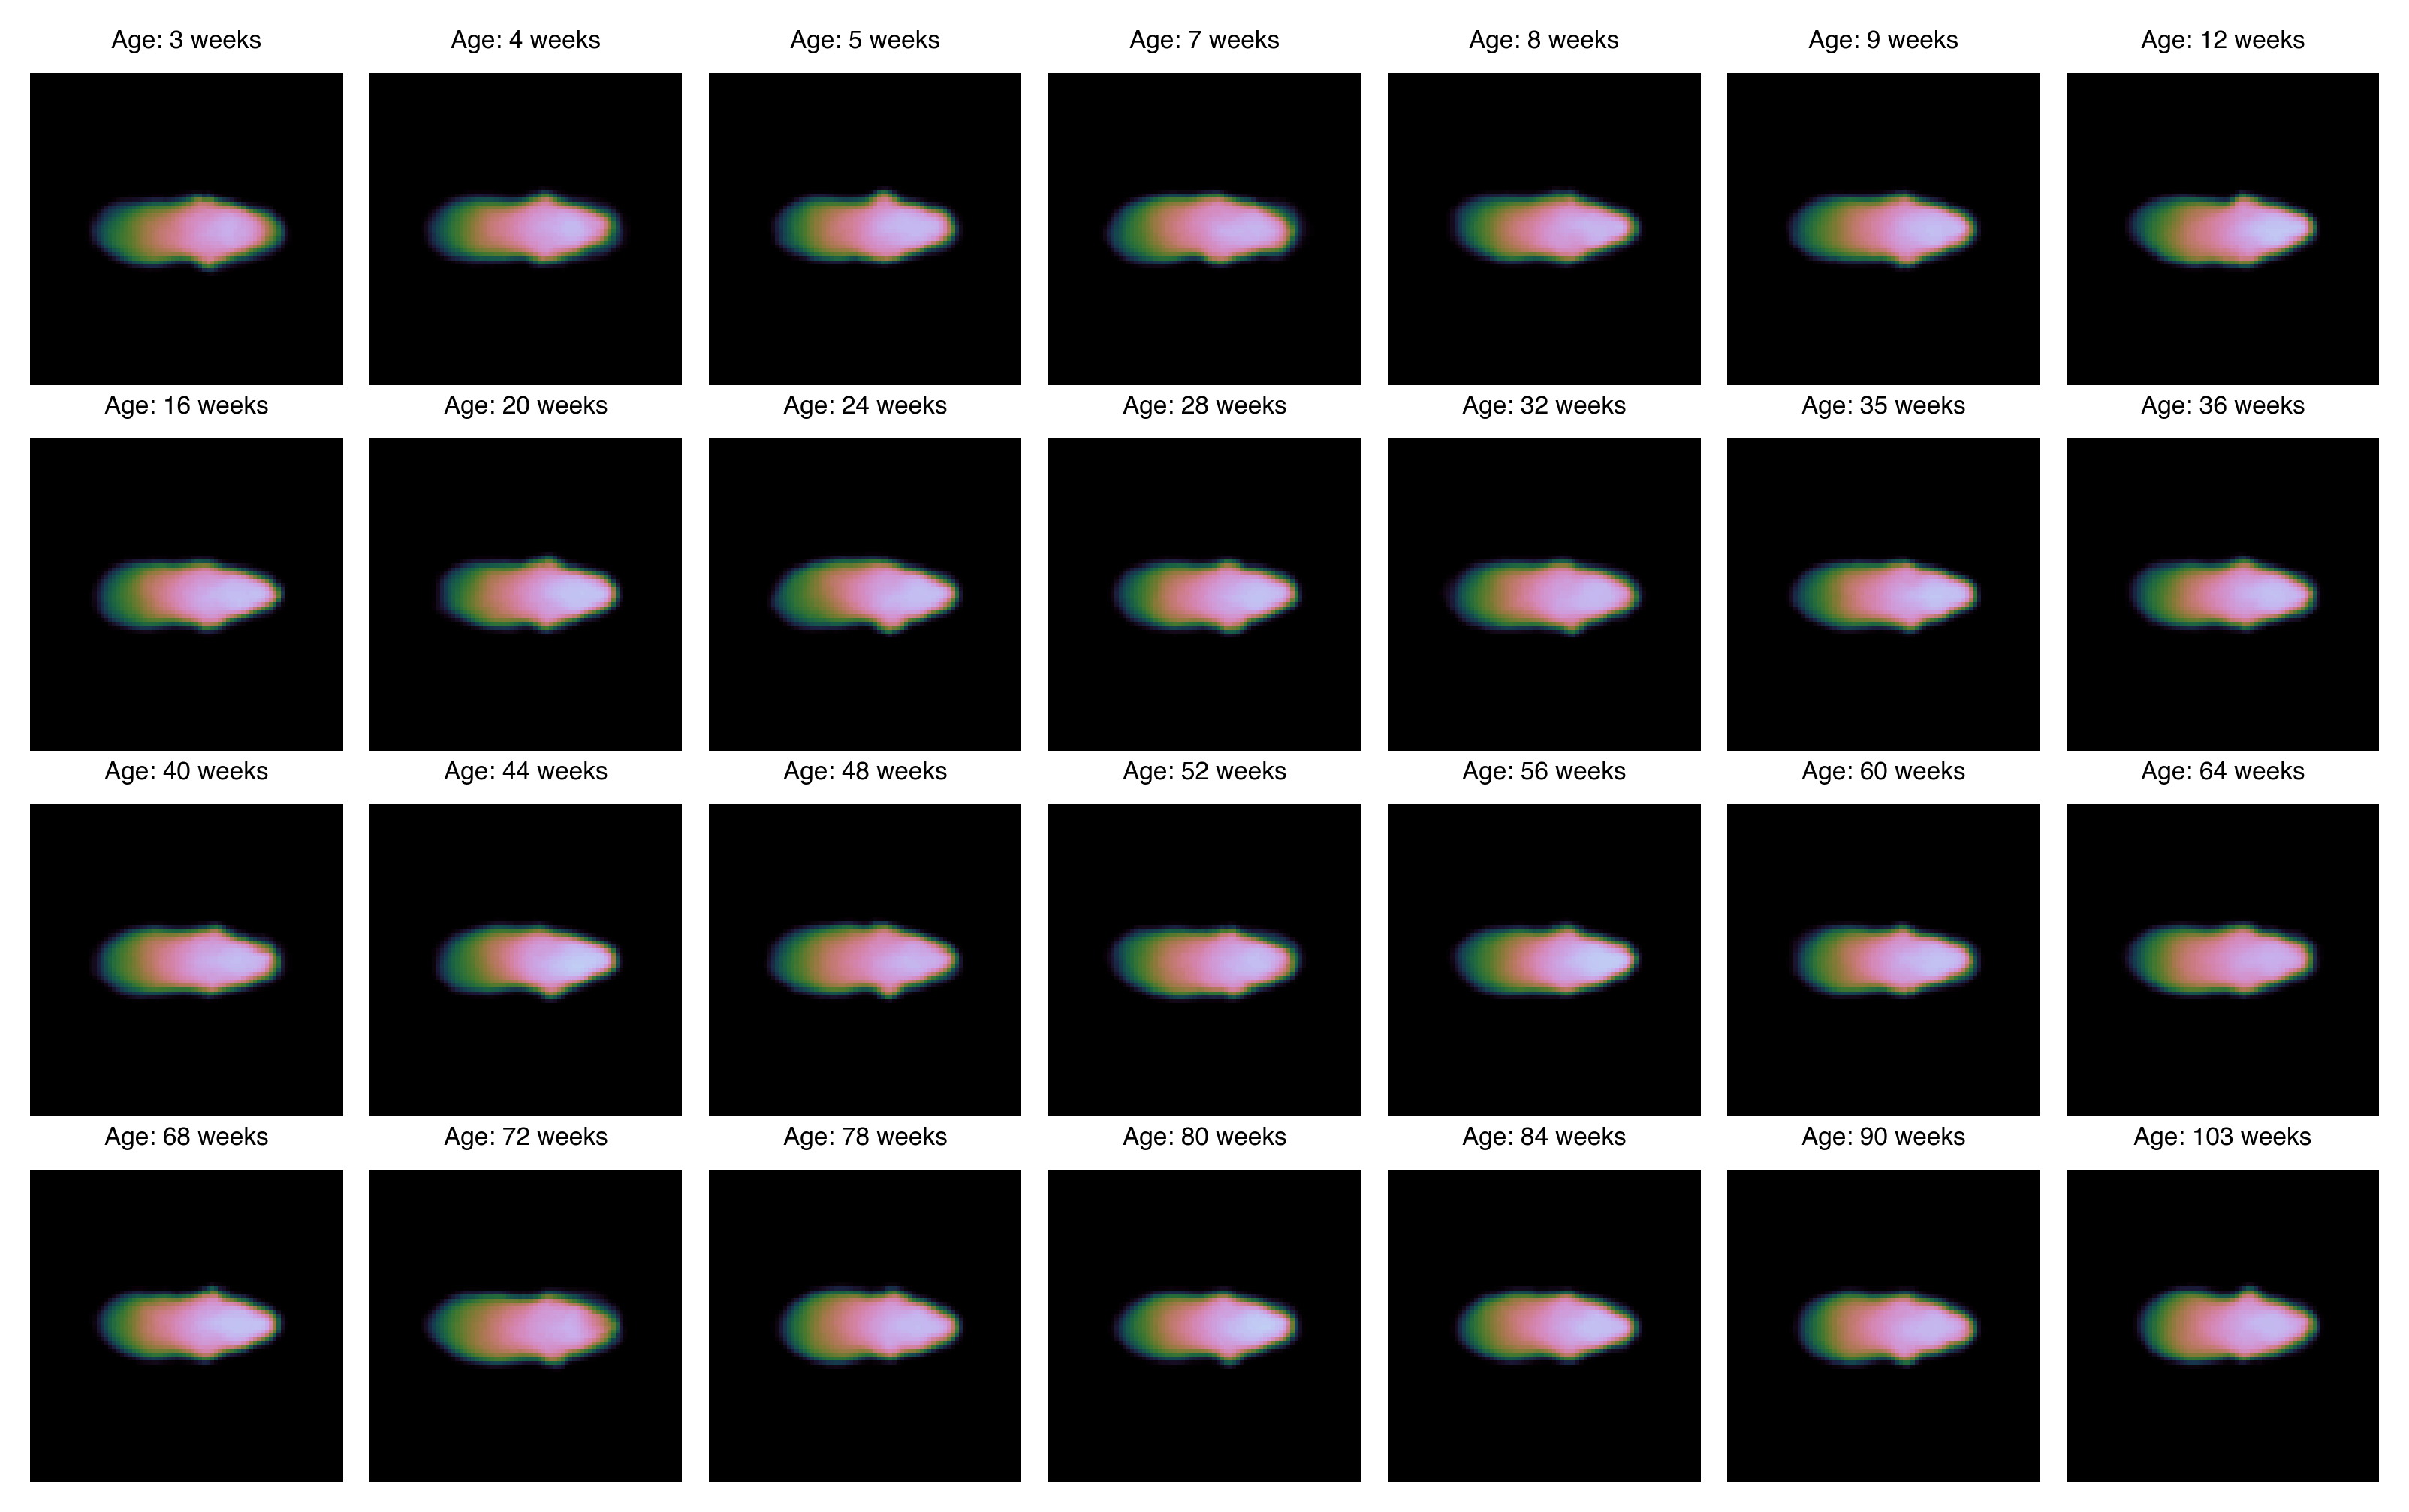

In [40]:
for key in keys:
    fig, ax = plt.subplots(4, 7, figsize=(8, 5))

    plt_frames = point_frames[key]

    for a, (_age, _frame) in zip(ax.flat, plt_frames.items()):
        a.imshow(_frame, cmap="cubehelix", clim=(0, 100))
        a.set(title="Age: {} weeks".format(_age), aspect="equal")
        a.axis("off")
    fig.tight_layout()

In [41]:
from toolz import sliding_window, partition_all

In [42]:
# compute differences between ages
# for key in keys:
#     fig, ax = plt.subplots(4, 7, figsize=(8, 5))

#     plt_frames = og_point_frames[key]

#     diffs = [f2 - f1 for f1, f2 in sliding_window(2, plt_frames.values())]
#     age_titles = [(a1, a2) for a1, a2 in sliding_window(2, plt_frames.keys())]

#     for a, _age, _frame in zip(ax.flat, age_titles, diffs):
#         a.imshow(_frame, cmap="RdBu_r", clim=(-20, 20))
#         a.set(title="Age: {} weeks".format(_age), aspect="equal")
#         a.axis("off")
#     ax.flatten()[-1].remove()
#     fig.tight_layout()

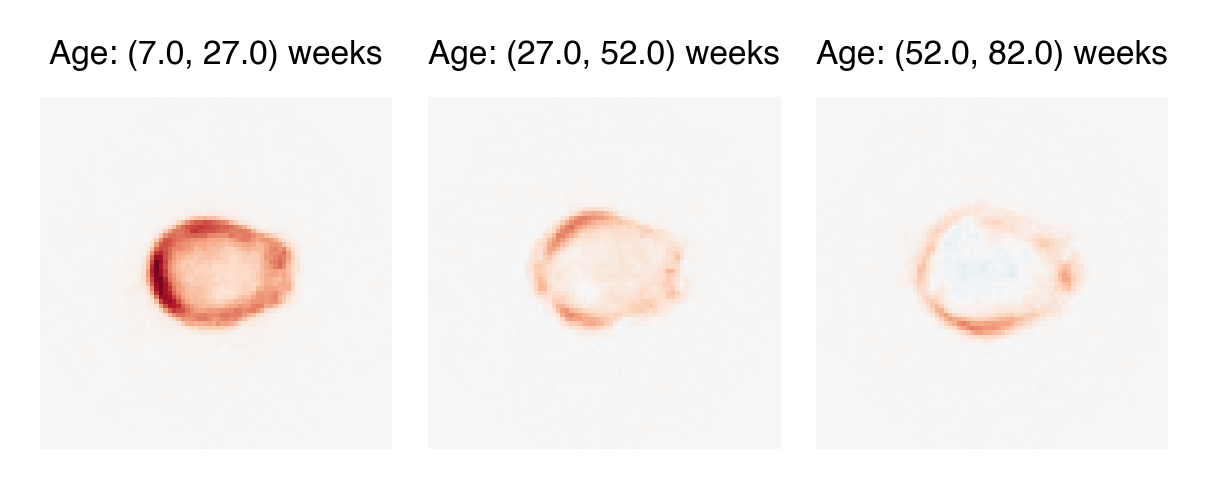

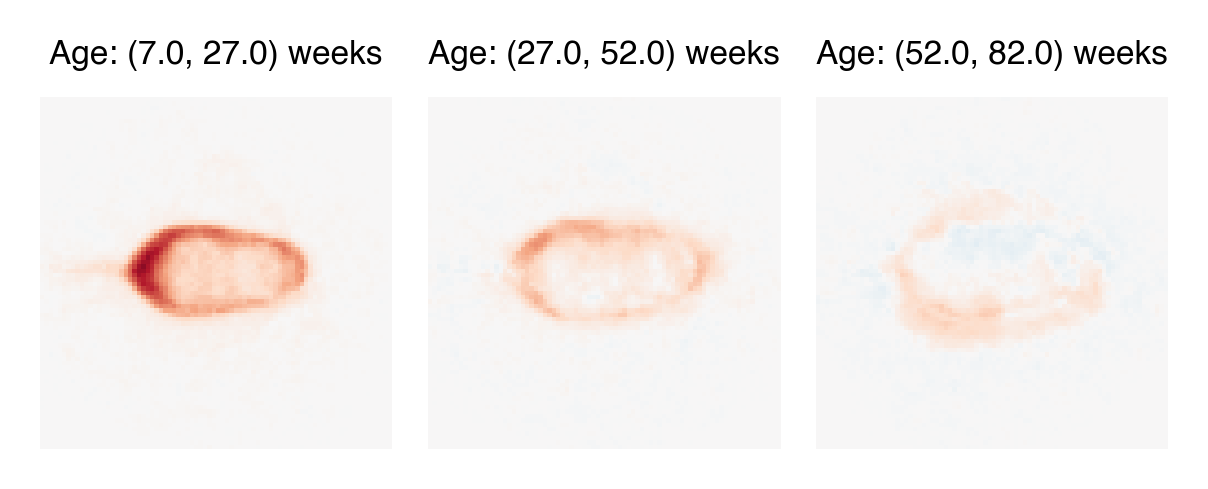

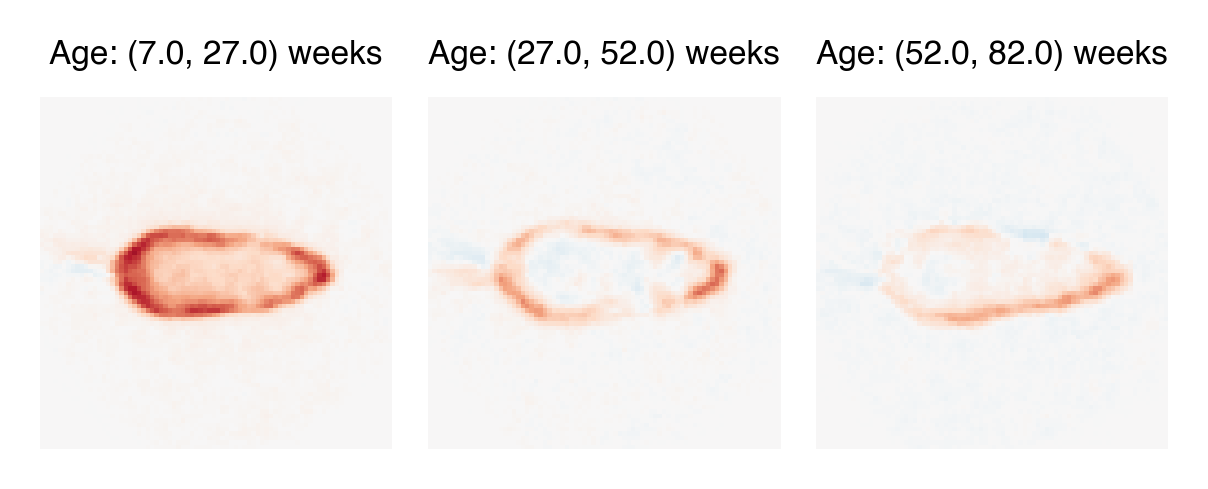

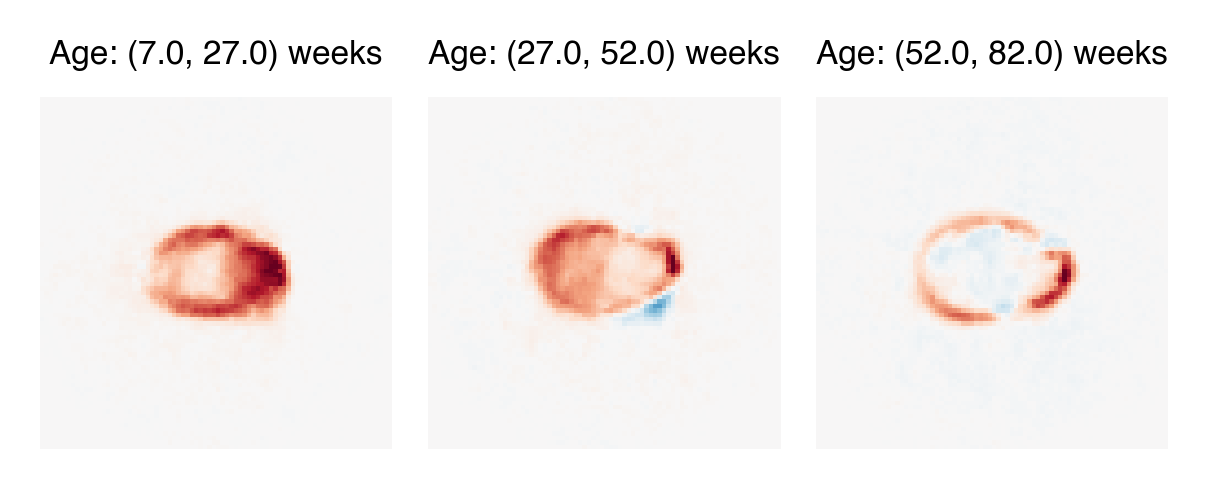

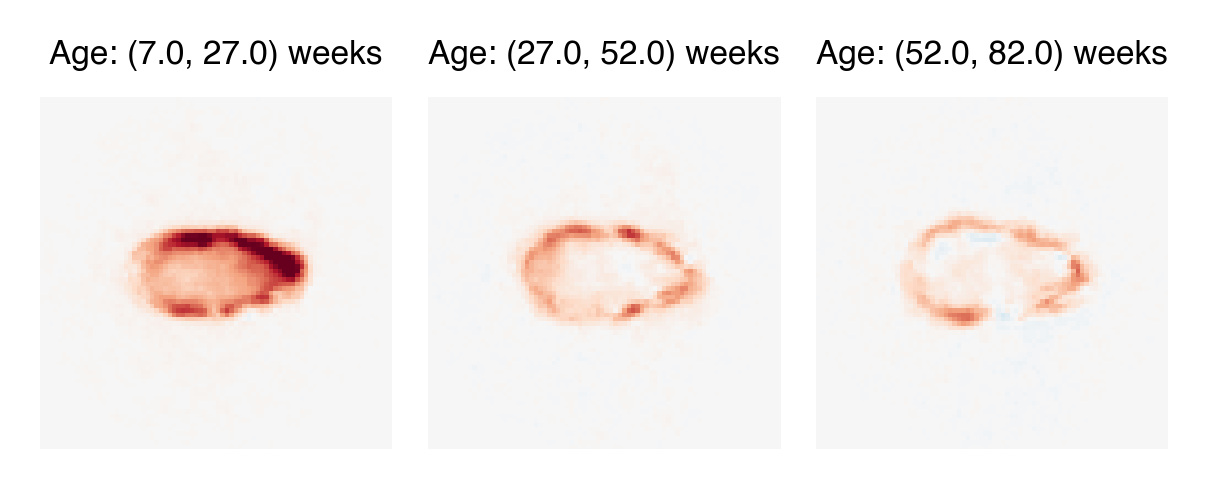

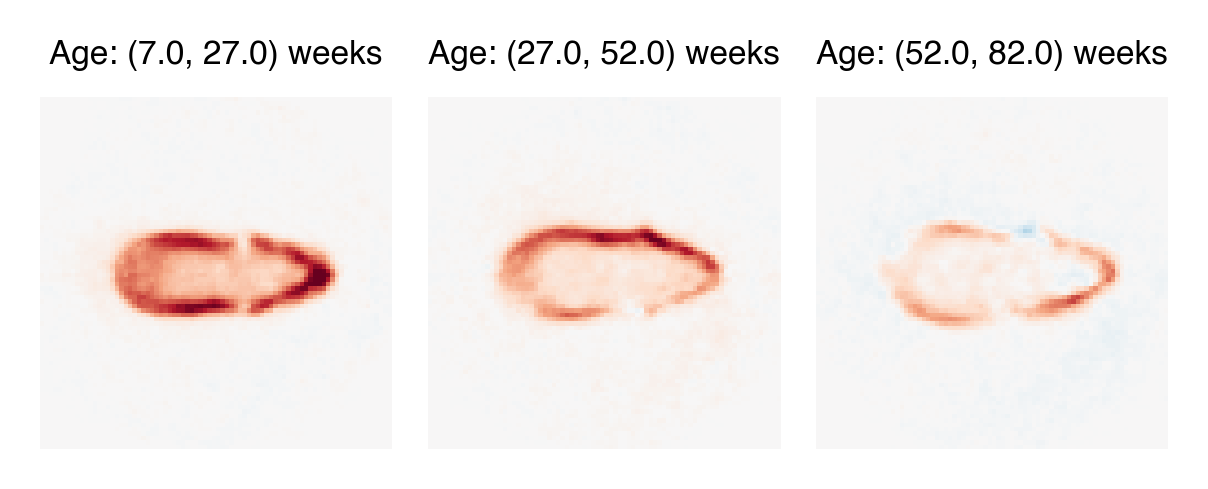

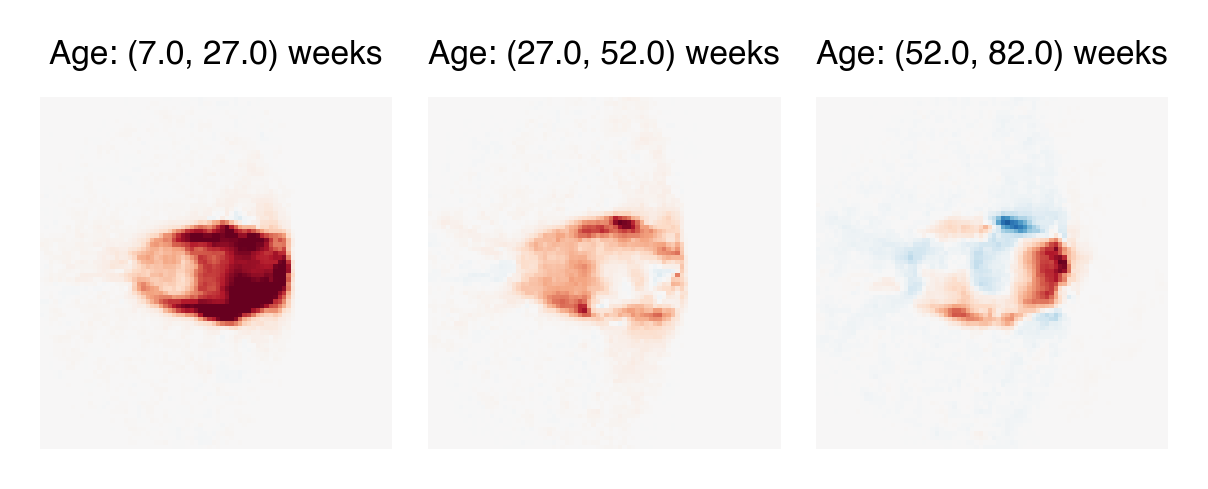

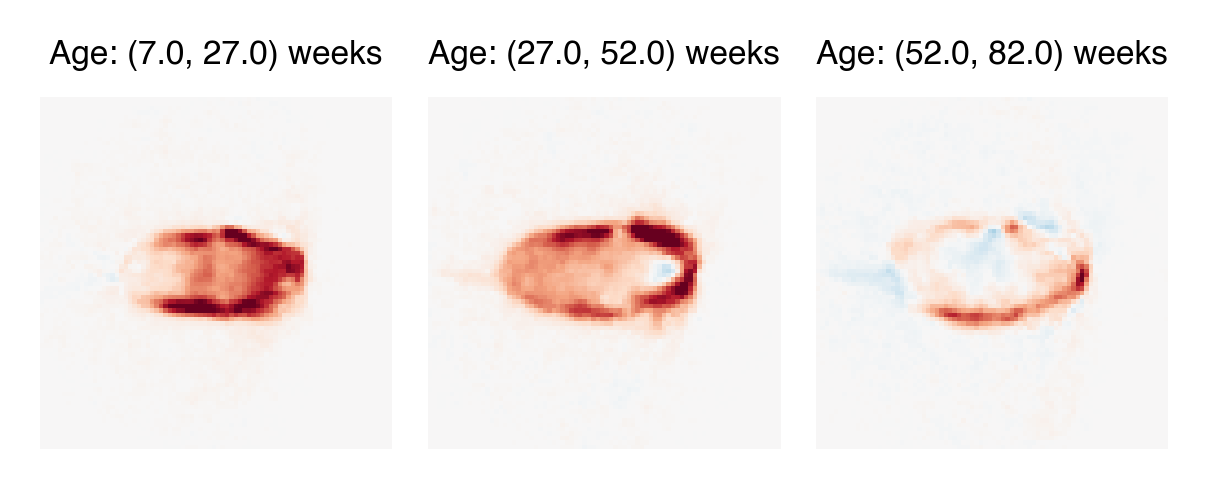

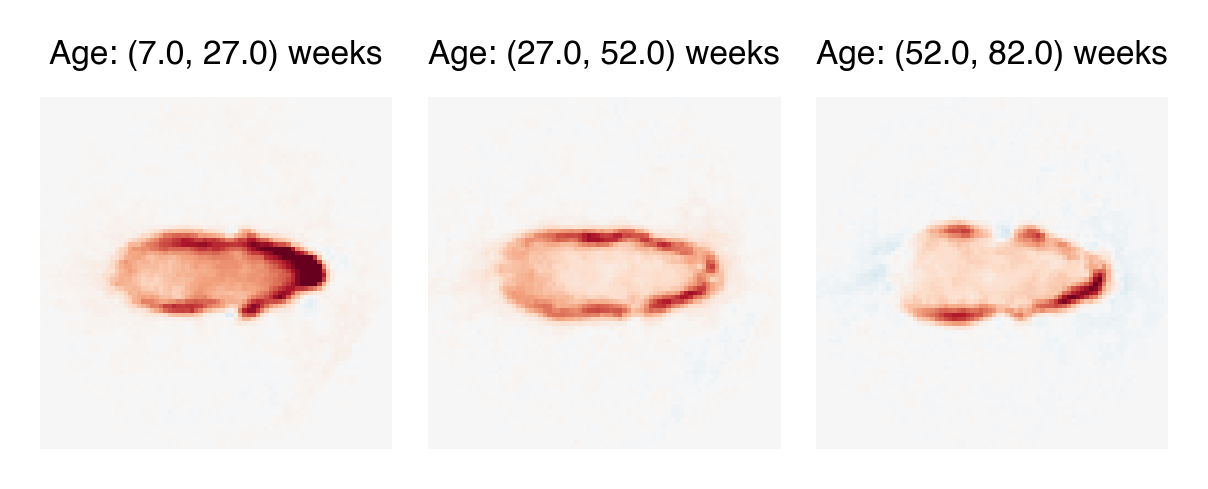

In [43]:
# compute differences between ages
for key in keys:
    fig, ax = plt.subplots(1, 3, figsize=(3, 1.5))

    plt_frames = og_point_frames[key]

    avgs = [np.mean(_frames, axis=0) for _frames in partition_all(len(plt_frames) // 4, plt_frames.values())]
    avg_ages = [np.round(np.mean(_ages), 0) for _ages in partition_all(len(plt_frames) // 4, plt_frames.keys())]

    diffs = [f2 - f1 for f1, f2 in sliding_window(2, avgs)]
    age_titles = [k for k in sliding_window(2, avg_ages)]

    for a, _age, _frame in zip(ax.flat, age_titles, diffs):
        a.imshow(_frame, cmap="RdBu_r", clim=(-20, 20))
        a.set(title="Age: {} weeks".format(_age), aspect="equal")
        a.axis("off")
    fig.tight_layout()

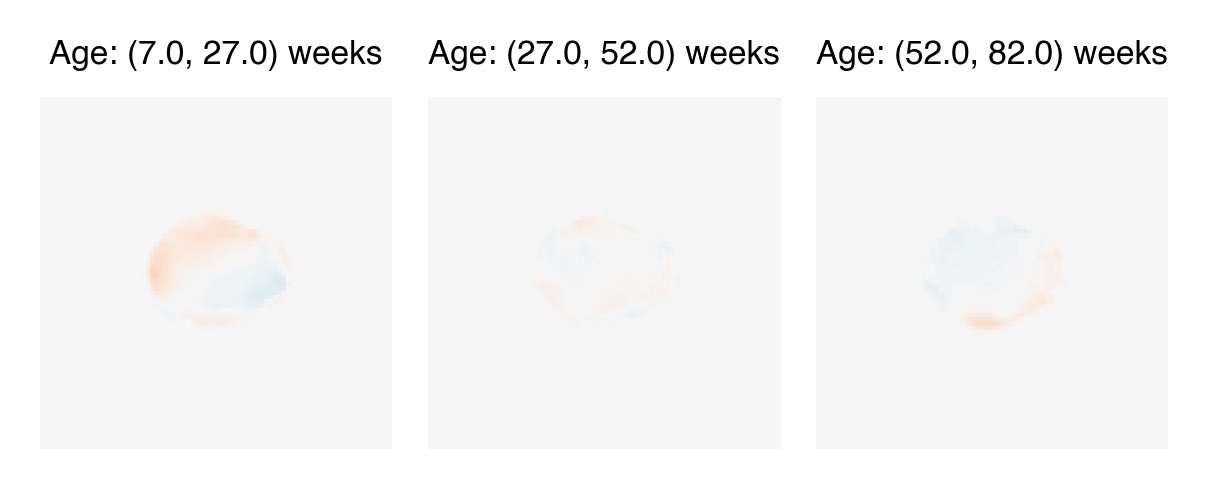

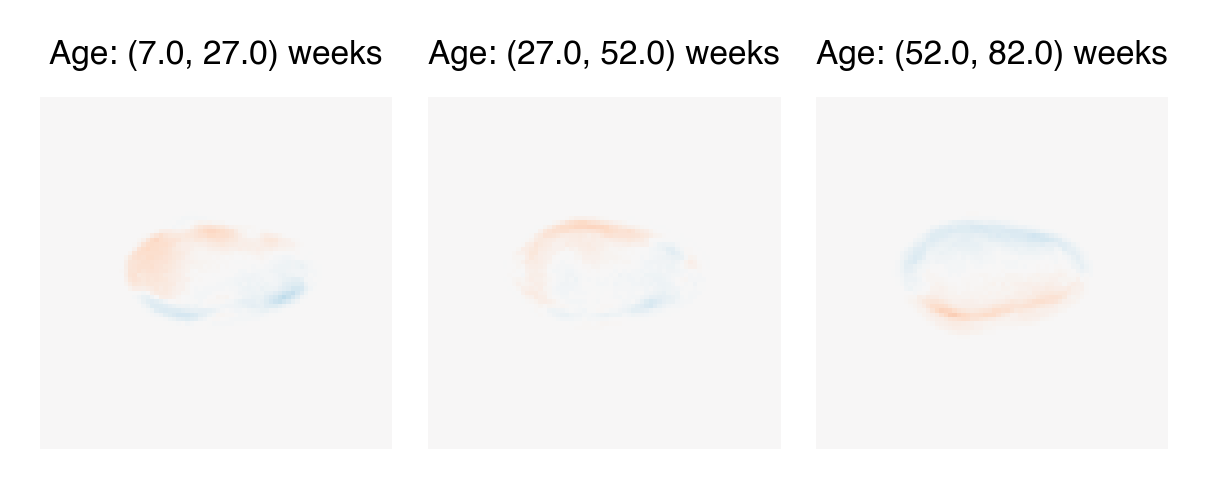

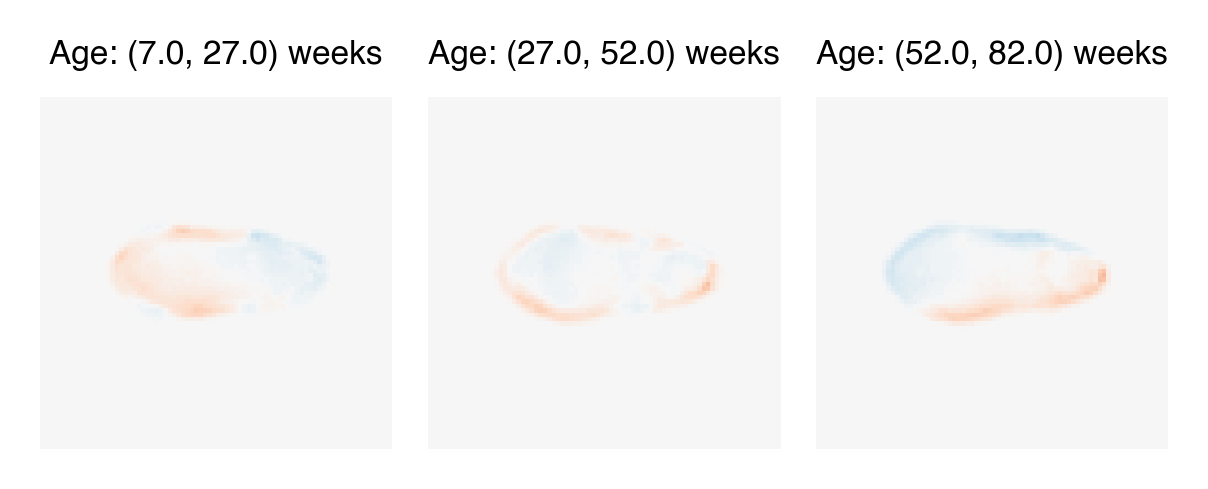

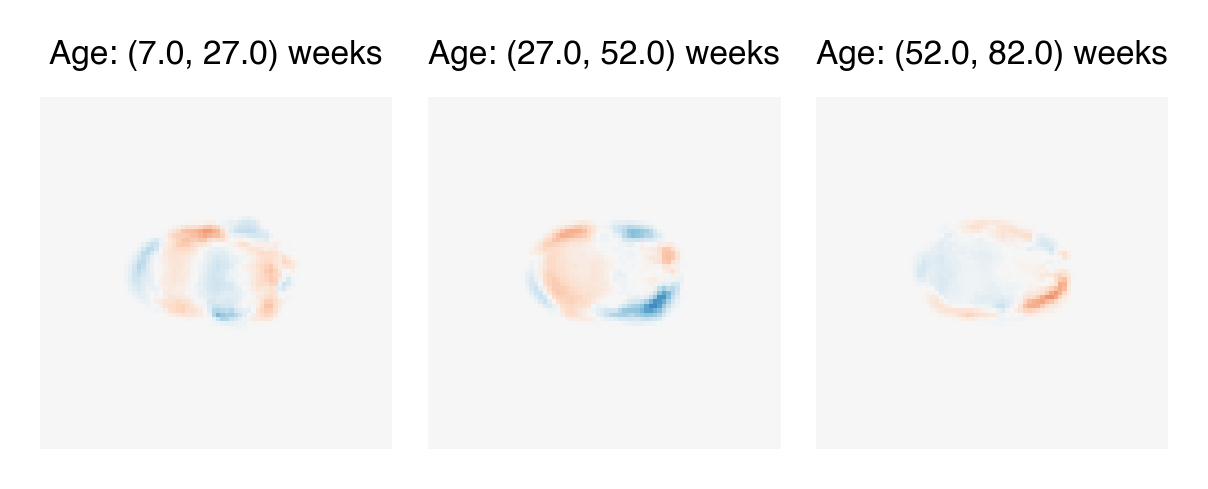

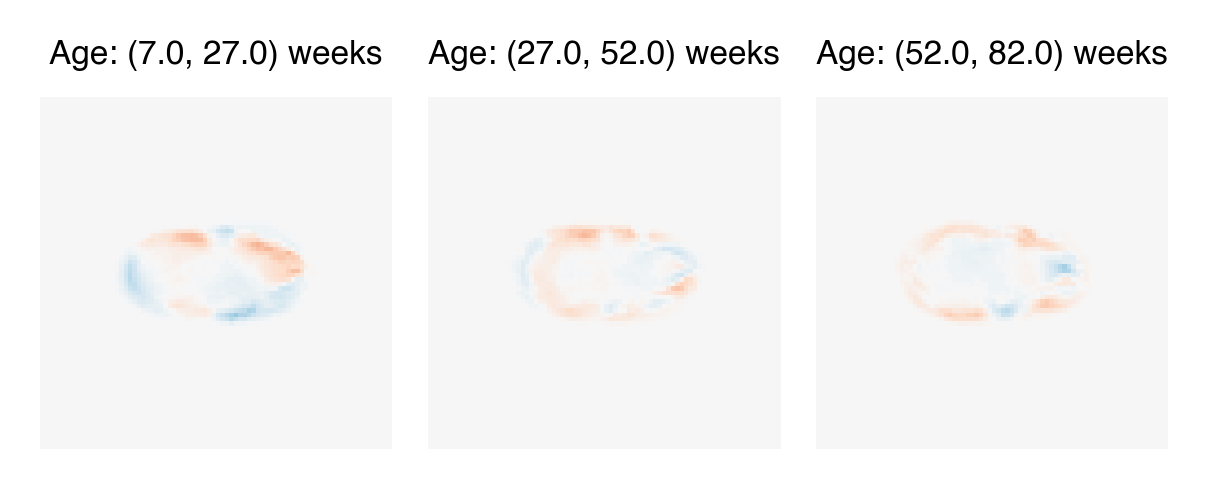

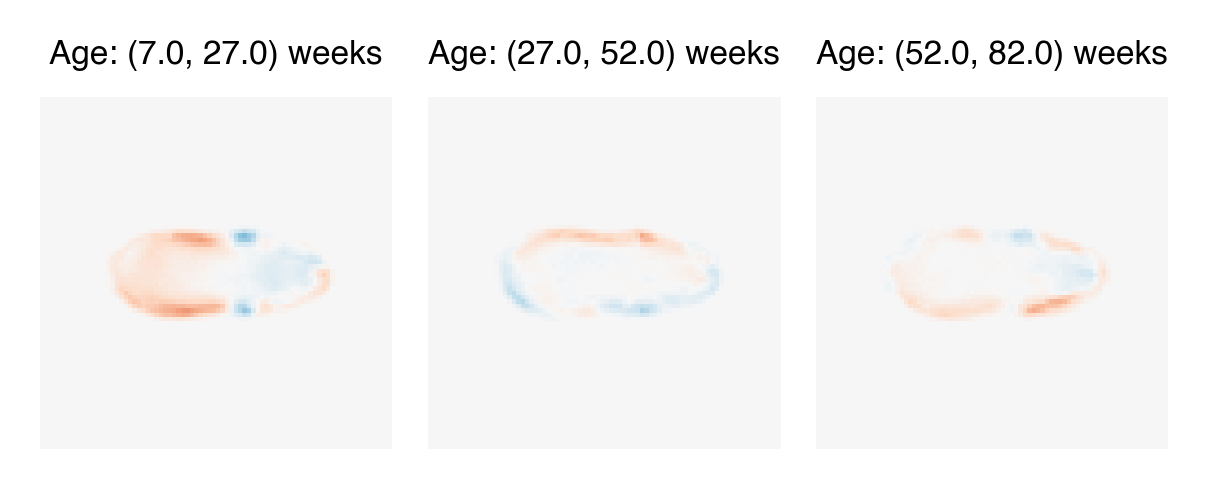

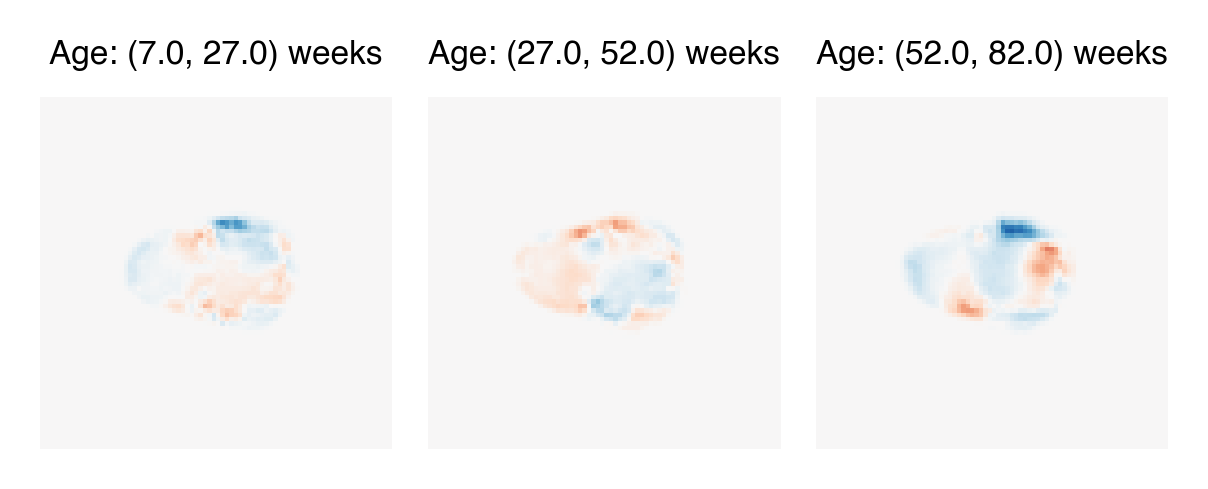

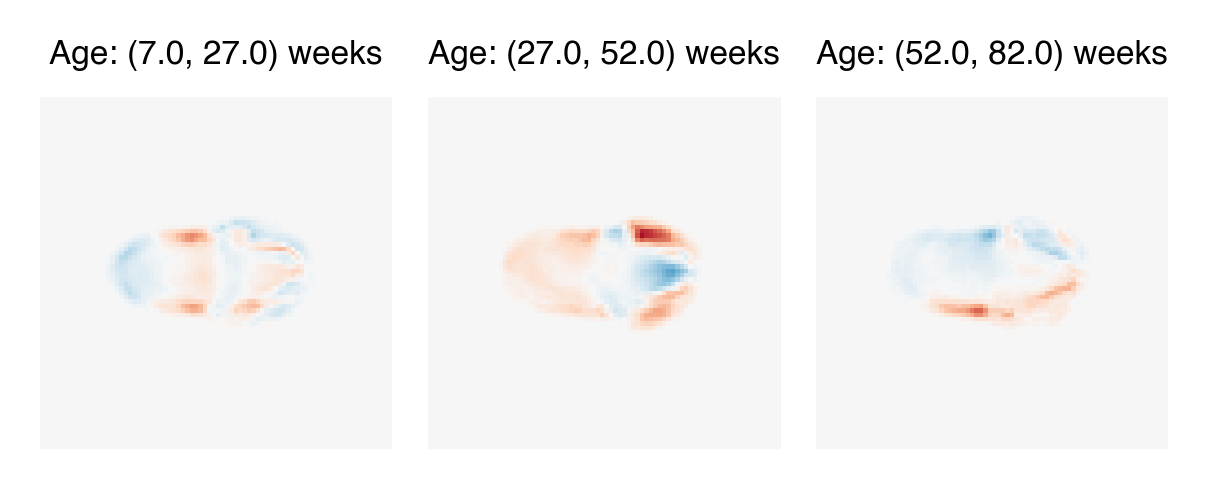

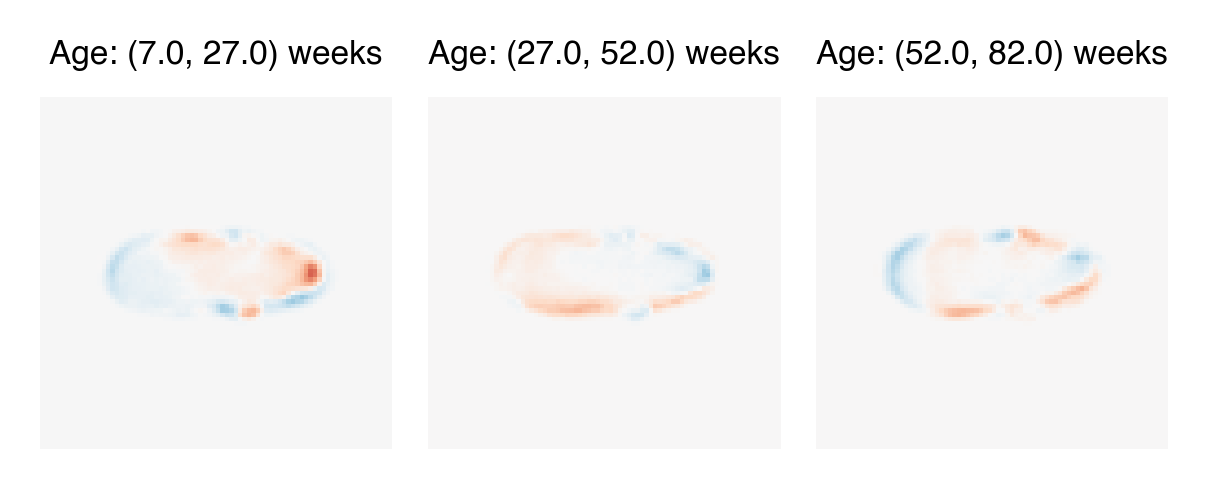

In [44]:
# compute differences between ages
for key in keys:
    fig, ax = plt.subplots(1, 3, figsize=(3, 1.5))

    plt_frames = point_frames[key]

    avgs = [np.mean(_frames, axis=0) for _frames in partition_all(len(plt_frames) // 4, plt_frames.values())]
    avg_ages = [np.round(np.mean(_ages), 0) for _ages in partition_all(len(plt_frames) // 4, plt_frames.keys())]

    diffs = [f2 - f1 for f1, f2 in sliding_window(2, avgs)]
    age_titles = [k for k in sliding_window(2, avg_ages)]

    for a, _age, _frame in zip(ax.flat, age_titles, diffs):
        a.imshow(_frame, cmap="RdBu_r", clim=(-20, 20))
        a.set(title="Age: {} weeks".format(_age), aspect="equal")
        a.axis("off")
    fig.tight_layout()